### Описание набора данных

| Column Name                            | Description                                               |
|----------------------------------------|-----------------------------------------------------------|
| FORCE_2020_LITHOFACIES_CONFIDENCE     | Qualitative measure of interpretation confidence          |
| FORCE_2020_LITHOFACIES_LITHOLOGY      | Interpreted Lithofacies                                   |
| RDEP                                   | Deep Reading Resistivity measurement                      |
| RSHA                                   | Shallow Reading Resistivity measurement                   |
| RMED                                   | Medium Deep Reading Resistivity measurement               |
| RXO                                    | Flushed Zone Resistivity measurement                      |
| RMIC                                   | Micro Resistivity measurement                             |
| SP                                     | Self Potential Log                                        |
| DTS                                    | Shear wave sonic log (us/ft)                              |
| DTC                                    | Compressional waves sonic log (us/ft)                     |
| NPHI                                   | Neutron Porosity log                                      |
| PEF                                    | Photo Electric Factor log                                 |
| GR                                     | Gamma Ray Log                                             |
| RHOB                                   | Bulk Density Log                                          |
| DRHO                                   | Density Correction log                                    |
| CALI                                   | Caliper log                                               |
| BS                                     | Borehole Size                                             |
| DCAL                                   | Differential Caliper log                                  |
| ROPA                                   | Average Rate of Penetration                               |
| SGR                                    | Spectra Gamma Ray log                                     |
| MUDWEIGHT                              | Weight of Drilling Mud                                    |
| ROP                                    | Rate of Penetration                                       |
| DEPTH_MD                               | Measured Depth                                            |
| x_loc                                  | X location of sample                                      |
| y_loc                                  | Y location of sample                                      |
| z_loc                                  | Z (TVDSS) Depth of sample                                 |


Данные содержат столбцы метаданных:
* WELL: название скважины
* DEPTH_MD: измеренная глубина
* X_LOC: UTM координата X
* Y_LOC: UTM координата Y
* Z_LOC: ГЛУБИНА
* GROUP: группа литостратиграфии NPD
* FORMATION: формация литостратиграфии NPD

Данные содержат кривые каротажа скважины. Например, следующие:
* BS: Размер бита
* CALI: Калипер
* RDEP: Глубокое сопротивление
* RHOB: Объемная плотность
* GR: Сырые данные гамма-излучения
* SGR: Спектральный гамма-излучение
* RMED: Среднее сопротивление
* ROP: Скорость бурения
* NPHI: Нейтронная пористость
* PEF: Фотоэлектрический коэффициент поглощения
* RSHA: Поверхностное сопротивление
* DTS: Звуковая скорость (поперечная)
* DTC: Звуковая скорость (компрессионная)

а также интерпретацию

* FORCE_2020_LITHOFACIES_LITHOLOGY: классификация литологии
* FORCE_2020_LITHOFACIES_CONFIDENCE: уверенность в интерпретации литологии (1: высокая, 2: средняя, 3: низкая)

### 1. Установка библиотек и загрузка данных

In [1]:
import joblib
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from numpy import std
from numpy import mean
import lightgbm as lgbm
import plotly.express as px
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import matplotlib.colors as colors
from sklearn.metrics import f1_score
from pandas import DataFrame, Series
from scipy.ndimage import median_filter
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree, export_text
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report


sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20, 16)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [5]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [6]:
df = pd.read_csv('../data/Vovle/CSV_train.csv', sep=';')

In [7]:
df.head()

WELL  DEPTH_MD         X_LOC      Y_LOC       Z_LOC         GROUP  \
0  15/9-13   494.528  437641.96875  6470972.5 -469.501831  NORDLAND GP.   
1  15/9-13   494.680  437641.96875  6470972.5 -469.653809  NORDLAND GP.   
2  15/9-13   494.832  437641.96875  6470972.5 -469.805786  NORDLAND GP.   
3  15/9-13   494.984  437641.96875  6470972.5 -469.957794  NORDLAND GP.   
4  15/9-13   495.136  437641.96875  6470972.5 -470.109772  NORDLAND GP.   

  FORMATION       CALI  RSHA      RMED  ...        ROP  DTS  DCAL      DRHO  \
0       NaN  19.480835   NaN  1.611410  ...  34.636410  NaN   NaN -0.574928   
1       NaN  19.468800   NaN  1.618070  ...  34.636410  NaN   NaN -0.570188   
2       NaN  19.468800   NaN  1.626459  ...  34.779556  NaN   NaN -0.574245   
3       NaN  19.459282   NaN  1.621594  ...  39.965164  NaN   NaN -0.586315   
4       NaN  19.453100   NaN  1.602679  ...  57.483765  NaN   NaN -0.597914   

   MUDWEIGHT  RMIC  ROPA  RXO  FORCE_2020_LITHOFACIES_LITHOLOGY  \
0        NaN   NaN   NaN  NaN                             65000   
1        NaN   NaN   NaN  NaN                             65000   
2        NaN   NaN   NaN  NaN                             65000   
3        NaN   NaN   NaN  NaN                             65000   
4        NaN   NaN   NaN  NaN                             65000   

   FORCE_2020_LITHOFACIES_CONFIDENCE  
0                                1.0  
1                                1.0  
2                                1.0  
3                                1.0  
4                                1.0  

[5 rows x 29 columns]

In [8]:
columns_rows = df.shape

In [9]:
columns_rows[0]

1170511

In [10]:
print('Columns of train data is {:}'.format(columns_rows[1]), 'and rows of train data is {:}'.format(columns_rows[0]))

Columns of train data is 29 and rows of train data is 1170511


In [11]:
test_df = pd.read_csv('../data/Vovle/CSV_test.csv', sep=';')

In [10]:
test_df.head()

WELL    DEPTH_MD         X_LOC      Y_LOC       Z_LOC         GROUP  \
0  15/9-14  480.628001  423244.50000  6461862.5 -455.624420  NORDLAND GP.   
1  15/9-14  480.780001  423244.50000  6461862.5 -455.776428  NORDLAND GP.   
2  15/9-14  480.932001  423244.50000  6461862.5 -455.928436  NORDLAND GP.   
3  15/9-14  481.084001  423244.50000  6461862.5 -456.080444  NORDLAND GP.   
4  15/9-14  481.236001  423244.53125  6461862.5 -456.232422  NORDLAND GP.   

  FORMATION     CALI  RSHA      RMED  ...         SP  BS         ROP  DTS  \
0       NaN  19.2031   NaN  1.613886  ...  35.525719 NaN   96.461990  NaN   
1       NaN  19.2031   NaN  1.574376  ...  36.158520 NaN   96.454399  NaN   
2       NaN  19.2031   NaN  1.436627  ...  36.873703 NaN   96.446686  NaN   
3       NaN  19.2031   NaN  1.276094  ...  37.304054 NaN  161.170166  NaN   
4       NaN  19.2031   NaN  1.204704  ...  37.864922 NaN  172.489120  NaN   

   DCAL      DRHO  MUDWEIGHT  RMIC  ROPA  RXO  
0   NaN -0.538873   0.130611   NaN   NaN  NaN  
1   NaN -0.539232   0.130611   NaN   NaN  NaN  
2   NaN -0.540830   0.130611   NaN   NaN  NaN  
3   NaN -0.543943   0.130611   NaN   NaN  NaN  
4   NaN -0.542104   0.130611   NaN   NaN  NaN  

[5 rows x 27 columns]

In [11]:
test_cols_rows = test_df.shape

In [12]:
print('Columns of test data is {:}'.format(test_cols_rows[1]), 'and rows of test data is {:}'.format(test_cols_rows[0]))

Columns of test data is 27 and rows of test data is 136786


### 2. EDA

Просмотр количества значений и типов столбцов

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 29 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   WELL                               1170511 non-null  object 
 1   DEPTH_MD                           1170511 non-null  float64
 2   X_LOC                              1159736 non-null  float64
 3   Y_LOC                              1159736 non-null  float64
 4   Z_LOC                              1159736 non-null  float64
 5   GROUP                              1169233 non-null  object 
 6   FORMATION                          1033517 non-null  object 
 7   CALI                               1082634 non-null  float64
 8   RSHA                               630650 non-null   float64
 9   RMED                               1131518 non-null  float64
 10  RDEP                               1159496 non-null  float64
 11  RHOB                    

Описательная статистика численных столбцов

In [14]:
df.describe()

DEPTH_MD         X_LOC         Y_LOC         Z_LOC          CALI  \
count  1.170511e+06  1.159736e+06  1.159736e+06  1.159736e+06  1.082634e+06   
mean   2.184087e+03  4.856310e+05  6.681276e+06 -2.138527e+03  1.318568e+01   
std    9.971821e+02  3.455641e+04  1.281524e+05  9.709426e+02  3.798907e+00   
min    1.360860e+02  4.268988e+05  6.406641e+06 -5.395563e+03  2.344000e+00   
25%    1.418597e+03  4.547996e+05  6.591327e+06 -2.811502e+03  9.429712e+00   
50%    2.076605e+03  4.769203e+05  6.737311e+06 -2.042785e+03  1.255575e+01   
75%    2.864393e+03  5.201532e+05  6.784886e+06 -1.391866e+03  1.671075e+01   
max    5.436632e+03  5.726328e+05  6.856661e+06 -1.110860e+02  2.827900e+01   

                RSHA          RMED          RDEP          RHOB            GR  \
count  630650.000000  1.131518e+06  1.159496e+06  1.009242e+06  1.170511e+06   
mean       10.694664  4.986978e+00  1.069103e+01  2.284987e+00  7.091370e+01   
std       100.642597  5.467269e+01  1.139480e+02  2.532835e-01  3.423149e+01   
min         0.000100 -8.418695e-03  3.170056e-02  7.209712e-01  1.092843e-01   
25%         0.854120  9.140862e-01  9.102396e-01  2.092203e+00  4.762722e+01   
50%         1.399020  1.443584e+00  1.439000e+00  2.321228e+00  6.836763e+01   
75%         3.099348  2.680930e+00  2.557220e+00  2.488580e+00  8.903551e+01   
max      2193.904541  1.988616e+03  1.999887e+03  3.457820e+00  1.076964e+03   

       ...            ROP            DTS           DCAL           DRHO  \
count  ...  535071.000000  174613.000000  298833.000000  987857.000000   
mean   ...     137.367965     204.655019       1.223849       0.012196   
std    ...    1539.383558      71.068461      54.372859       7.477798   
min    ...      -0.117977      69.163177     -12.215459   -7429.338867   
25%    ...       5.628000     155.936707       0.148438      -0.009253   
50%    ...      17.799999     188.200653       0.557320       0.001752   
75%    ...      34.812794     224.645081       1.299655       0.021702   
max    ...   47015.125000     676.578125   10011.422852       2.836938   

           MUDWEIGHT           RMIC           ROPA            RXO  \
count  316151.000000  176160.000000  192325.000000  327427.000000   
mean        1.216329       7.796809      23.505069     -95.779496   
std        10.180834      89.741807      22.632800     348.980030   
min         0.125818       0.056586    -999.250122    -999.900024   
25%         0.143792       0.891272      11.281895       0.687681   
50%         0.155774       1.967156      20.131153       1.366672   
75%         1.168307       5.084564      31.138481       3.420790   
max       185.730927   10000.000000     742.797852   35930.671875   

       FORCE_2020_LITHOFACIES_LITHOLOGY  FORCE_2020_LITHOFACIES_CONFIDENCE  
count                      1.170511e+06                       1.170332e+06  
mean                       6.138598e+04                       1.164258e+00  
std                        1.389170e+04                       4.451180e-01  
min                        3.000000e+04                       1.000000e+00  
25%                        6.500000e+04                       1.000000e+00  
50%                        6.500000e+04                       1.000000e+00  
75%                        6.500000e+04                       1.000000e+00  
max                        9.900000e+04                       3.000000e+00  

[8 rows x 26 columns]

Количество записей по каждой из горных пород

In [16]:
df['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()

65000    720803
30000    168937
65030    150455
70000     56320
80000     33329
99000     15245
70032     10513
88000      8213
90000      3820
74000      1688
86000      1085
93000       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [17]:
well_names_uniq = df.WELL.unique()
X_cor = df.groupby(['WELL'])['X_LOC'].mean()  #location coordinate 
Y_cor = df.groupby(['WELL'])['Y_LOC'].mean()
data_count = df.groupby(['WELL']).count().sum(axis='columns')

loc_wells_df = pd.DataFrame({'WELL':well_names_uniq, 'X_LOC': X_cor, 'Y_LOC': Y_cor, 'data_points': data_count})

In [18]:
xx = loc_wells_df.X_LOC
yy = loc_wells_df.Y_LOC
ss = loc_wells_df.data_points
ind = loc_wells_df.index
#cc = loc_wells_df.well_type

def mapPlot():
    fig, ax = plt.subplots(figsize=(18,10))

    sns.scatterplot(data=loc_wells_df, x=xx, y=yy, size=ss, alpha=.7,
                 palette=['red', 'blue', 'green'],sizes=(10, 300), ax=ax)

    ax.set_title('Well Distributions: circle size based on data availability', fontsize = '16')
    ax.set_xlabel('X_coordinate (UTM)', fontsize = '12')
    ax.set_ylabel('Y_coordinate (UTM)', fontsize = '12')

    for x,y,z in zip(xx,yy,ind):
        label_s = "{}".format(z)
        ax.annotate(label_s, (x,y),  textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize = '8') 

    ax.grid(True, color='0.6',axis='both', dashes=(5,2,1,2))

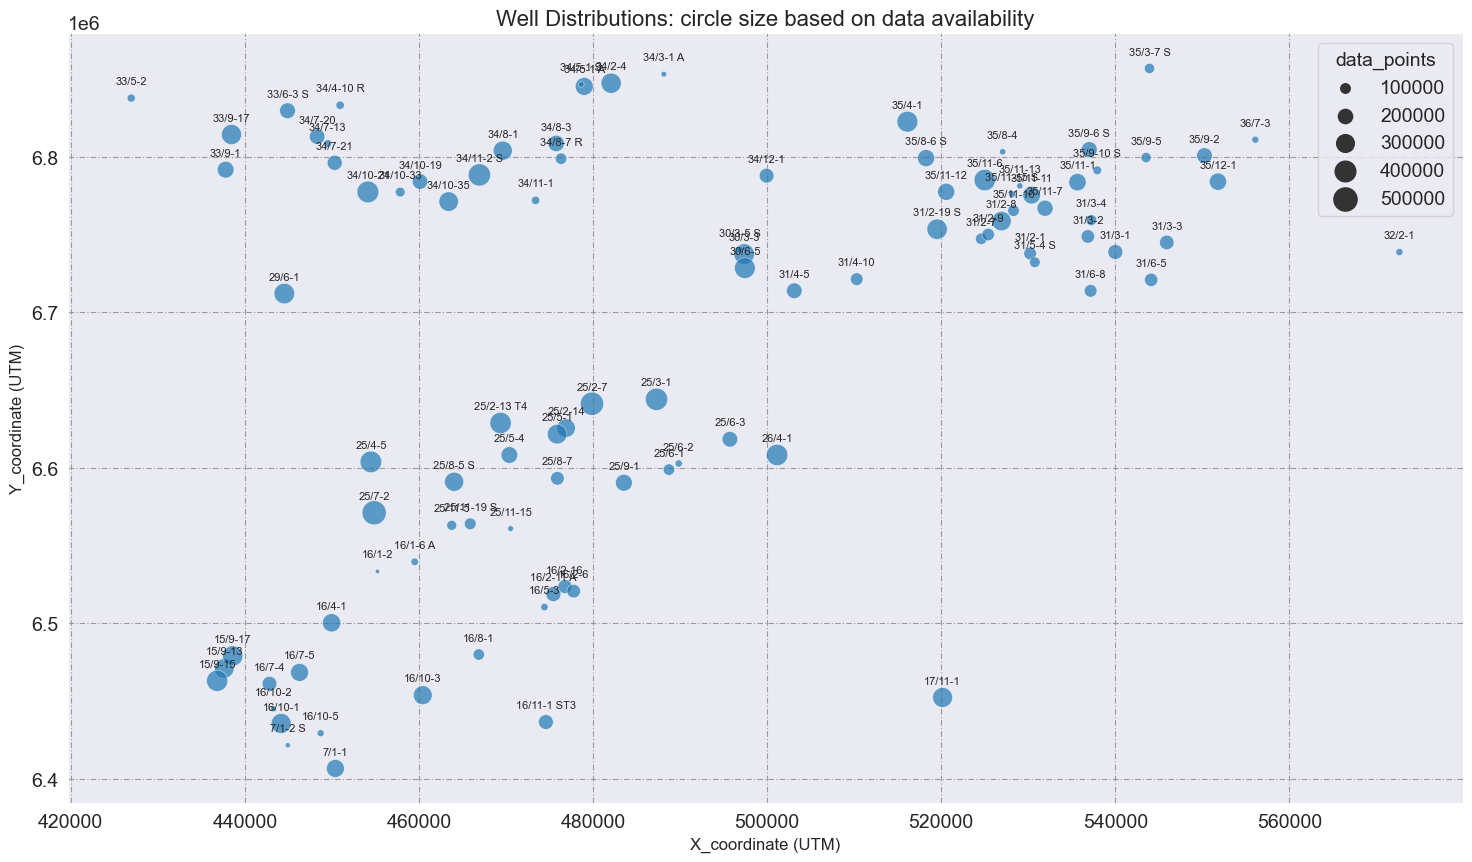

In [19]:
mapPlot()

#### 2.2 Визуализация каротажных кривых

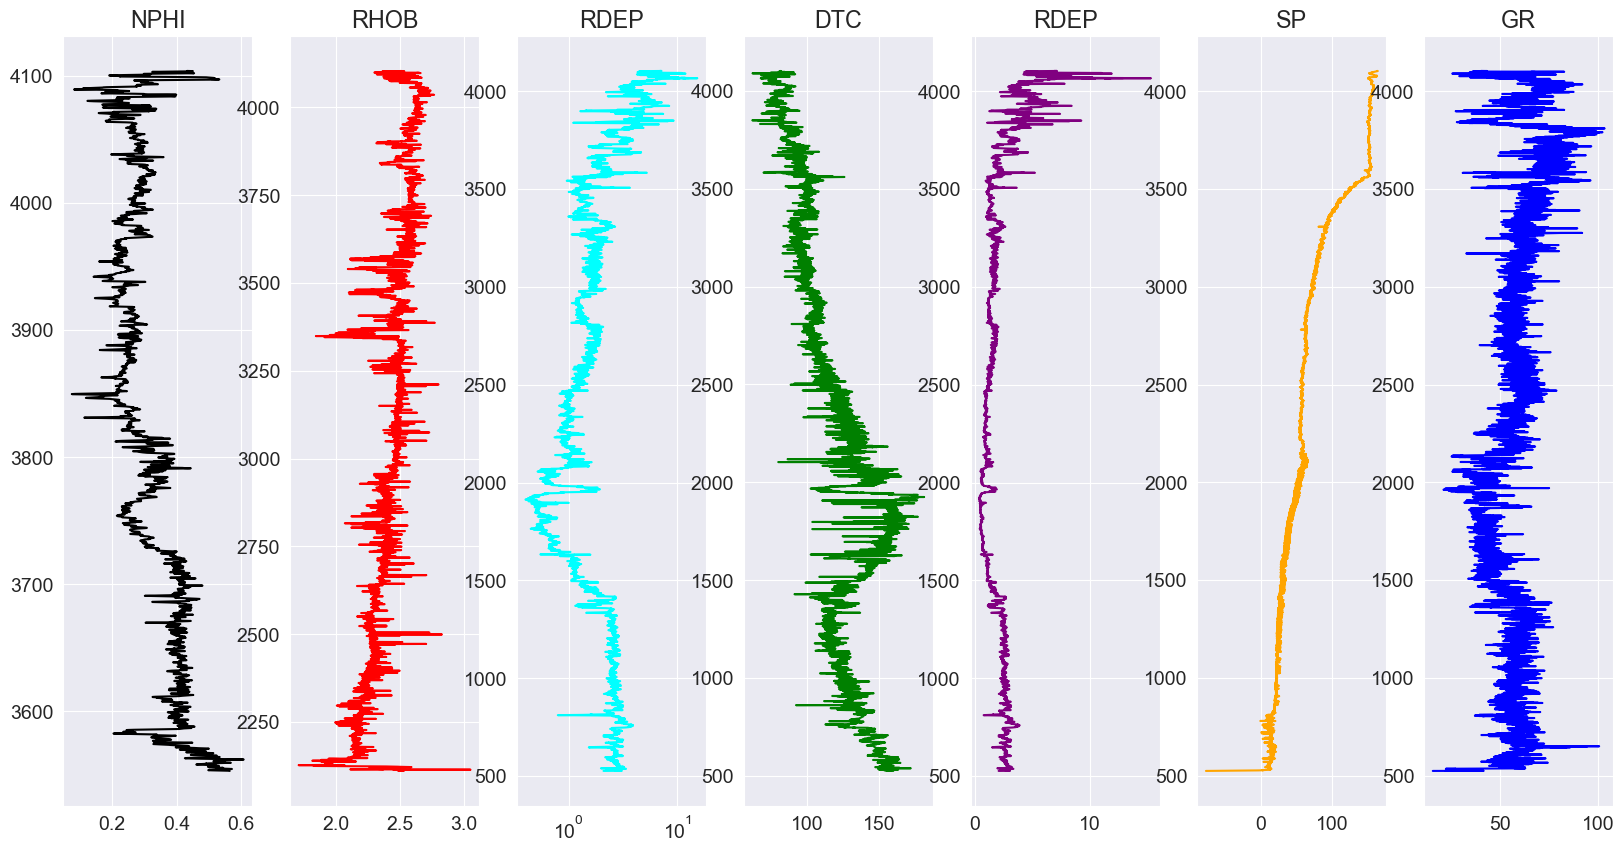

In [23]:
logs = ['NPHI', 'RHOB', 'RDEP', 'DTC', 'RDEP', 'SP', 'GR']

fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

colors = ['black', 'red', 'cyan', 'green', 'purple', 'orange', 'blue', 'yellow', 'magenta', 'brown', 'pink', 'lime']

for i in range(len(logs)):
    if i == 2:
    # for resistivity, semilog plot
        ax[i].semilogx(df.loc[df['WELL'] == '34/2-4'][logs[i]], df.loc[df['WELL'] == '34/2-4']['DEPTH_MD'], color=colors[i])
    else:
    # for non-resistivity, normal plot
        ax[i].plot(df.loc[df['WELL'] == '34/2-4'][logs[i]], df.loc[df['WELL'] == '34/2-4']['DEPTH_MD'], color=colors[i])

    ax[i].set_title(logs[i])

plt.show()

### 2.3 Визуализации

Визуализируем количество записей о каждой горной породе

In [12]:
lithology_keys = {} # initialize dictionary
litho=['Sandstone', 'Shale', 'SandyShale', 'Limestone', 'Chalk', 'Dolomite', 
       'Marl', 'Anhydrite', 'Halite', 'Coal', 'Basement', 'Tuff']
col = np.sort(df['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique())
for index, name in enumerate(col):
    lithology_keys[name] = litho[index]
    
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

df['FaciesLabels'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [90]:
df['FaciesLabels'].value_counts()

Shale              720803
Sandstone          168937
Sandstone/Shale    150455
Limestone           56320
Marl                33329
Tuff                15245
Chalk               10513
Halite               8213
Coal                 3820
Dolomite             1688
Anhydrite            1085
Basement              103
Name: FaciesLabels, dtype: int64

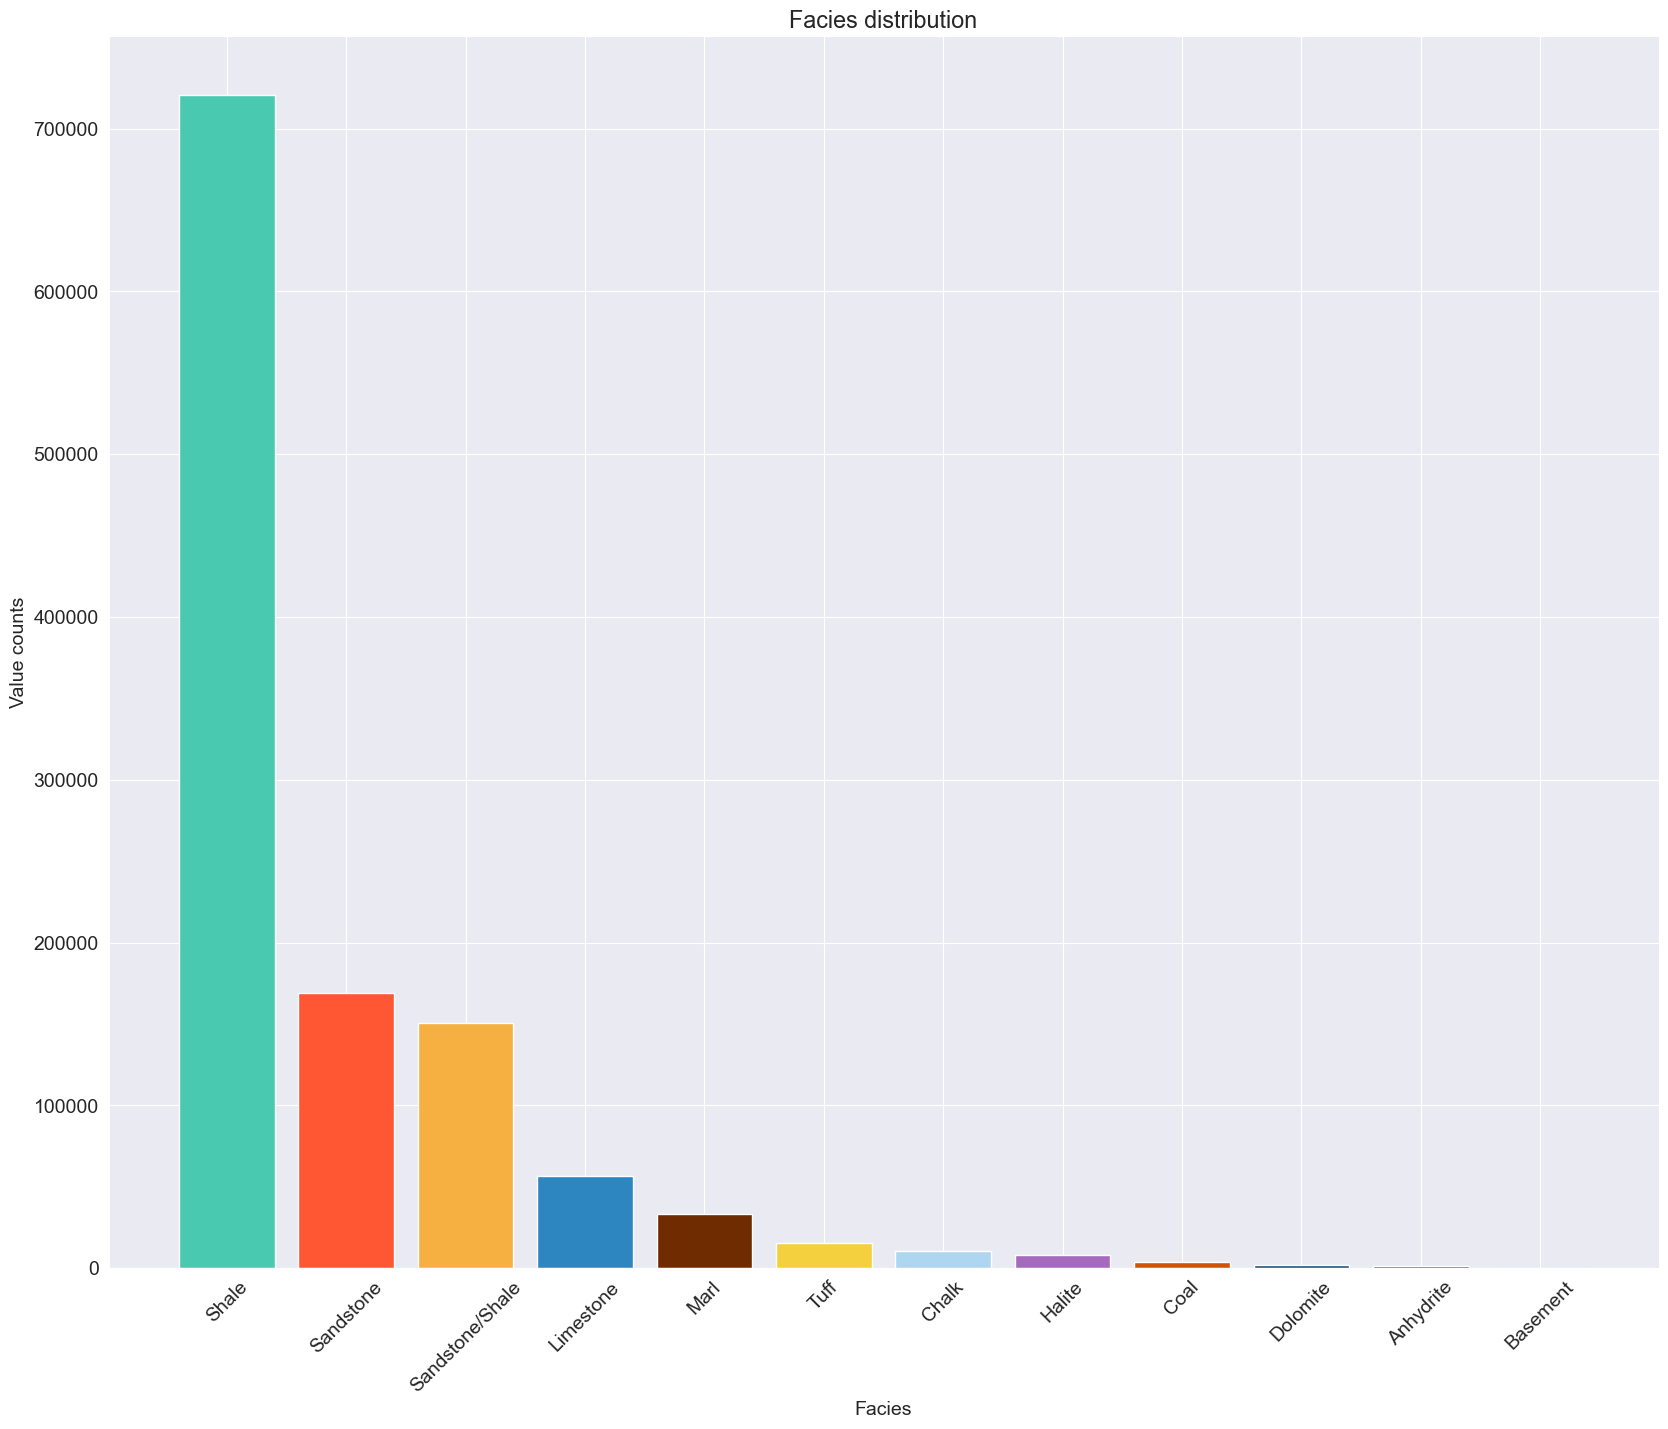

In [26]:
# Определение цветов для каждой фации
facies_colors = {'Sandstone': '#FF5733', 'Sandstone/Shale': '#F5B041', 'Shale': '#48C9B0',
                 'Marl': '#6E2C00', 'Dolomite': '#1B4F72', 'Limestone': '#2E86C1',
                 'Chalk': '#AED6F1', 'Halite': '#A569BD', 'Anhydrite': '#196F3D',
                 'Tuff': '#F4D03F', 'Coal': '#D35400', 'Basement': '#85929E'}

facies_counts = df['FaciesLabels'].value_counts()

plt.bar(facies_counts.index, facies_counts.values, color=[facies_colors[f] for f in facies_counts.index])
plt.title('Facies distribution')
plt.xlabel('Facies')
plt.ylabel('Value counts')

plt.xticks(rotation=45) 

plt.show()

Выбор признаков для решения задачи классификации

In [15]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

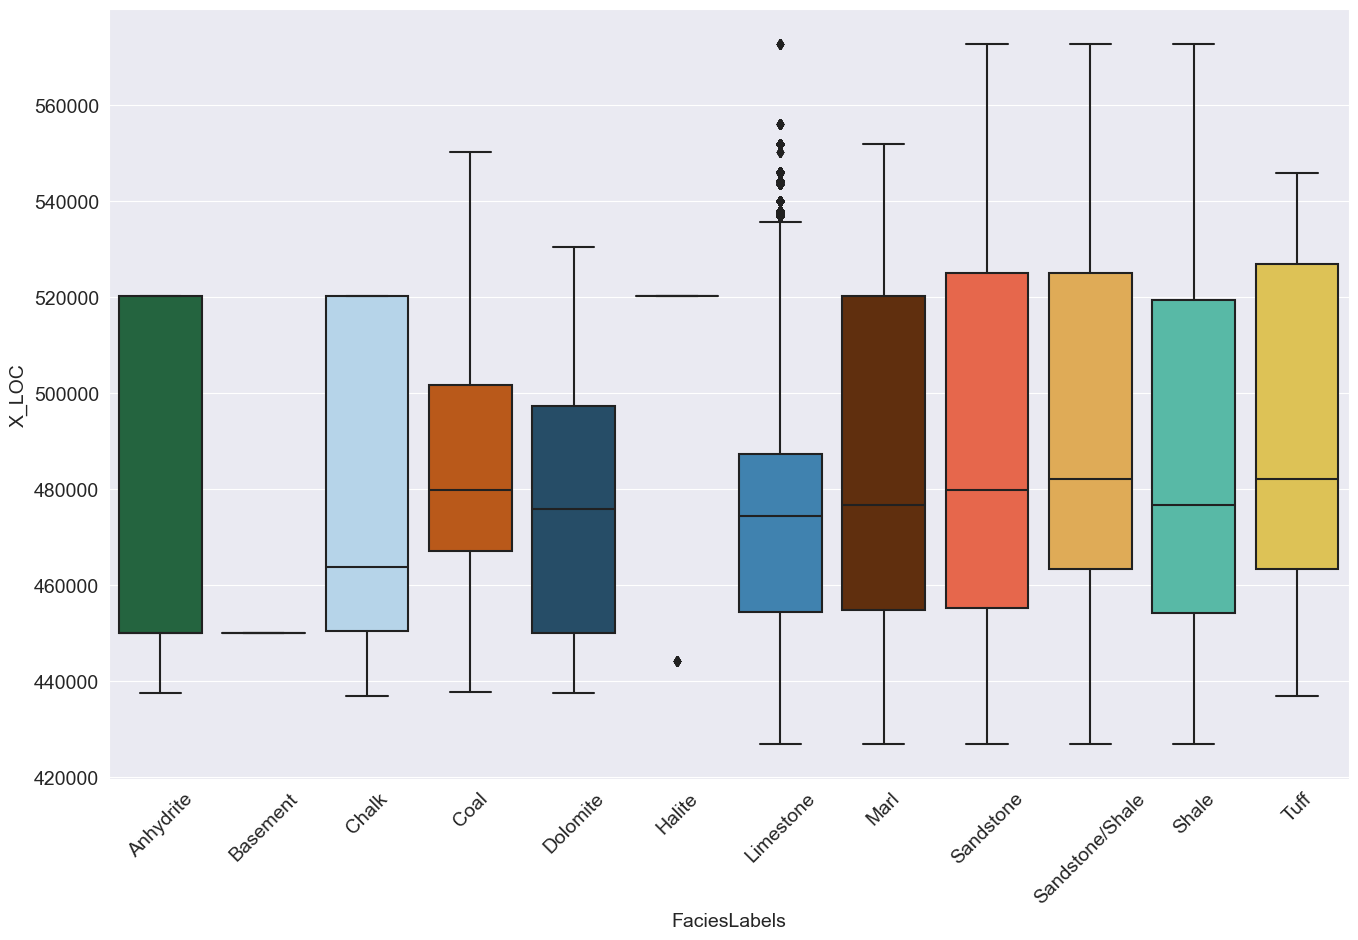

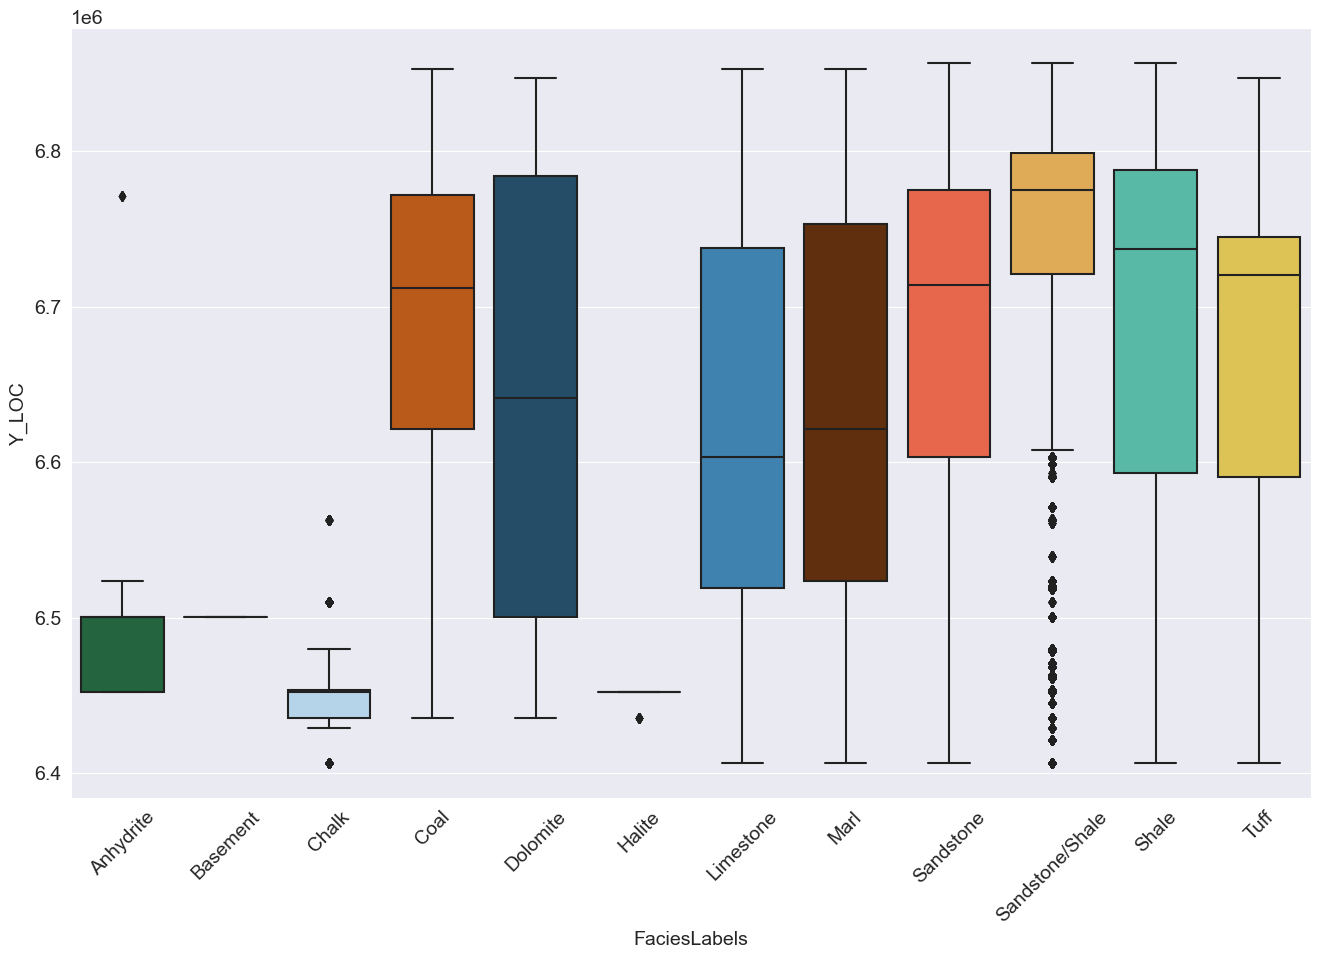

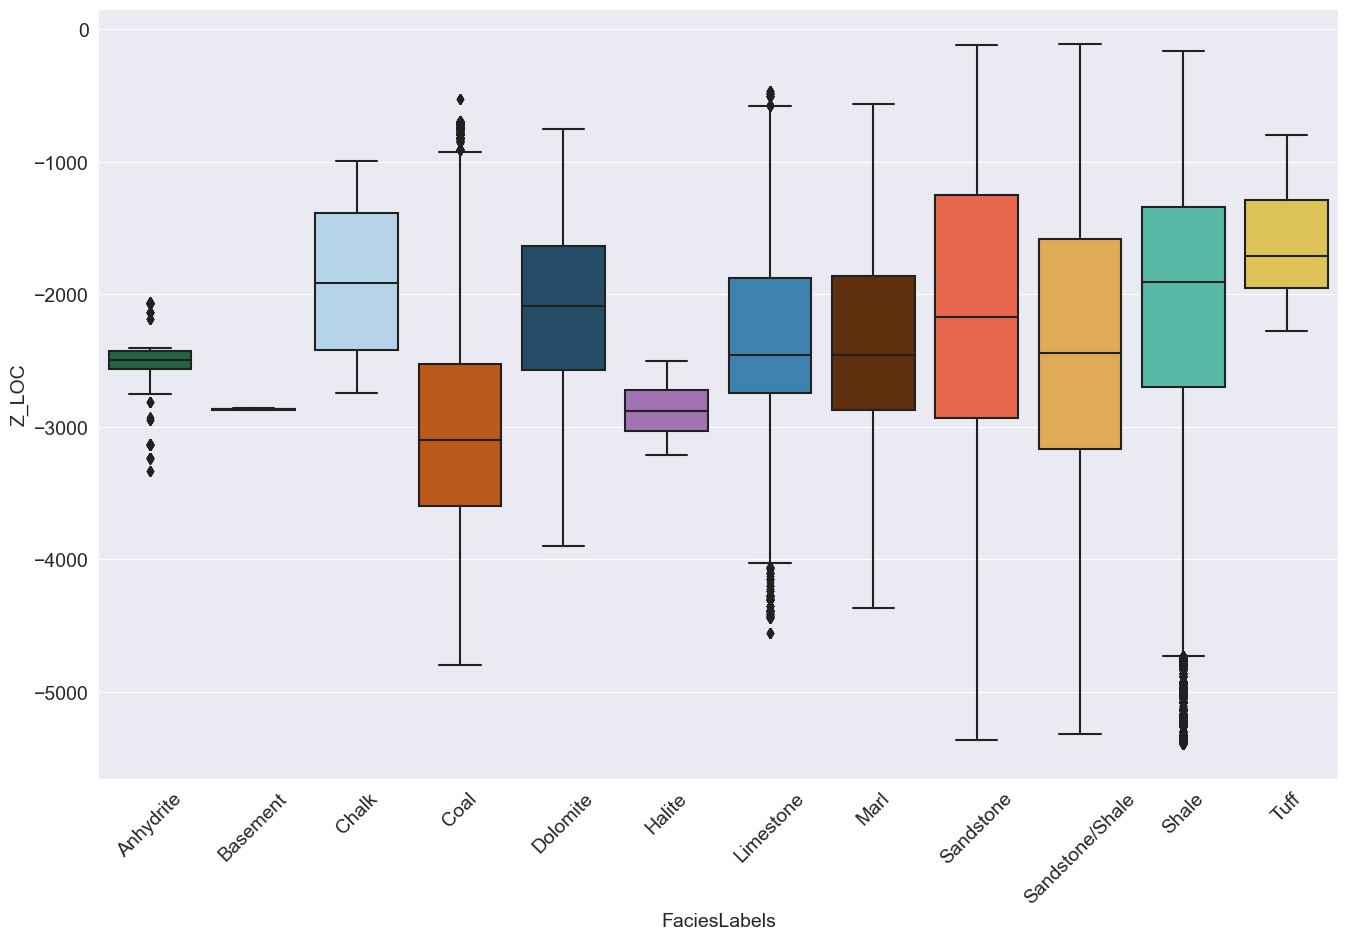

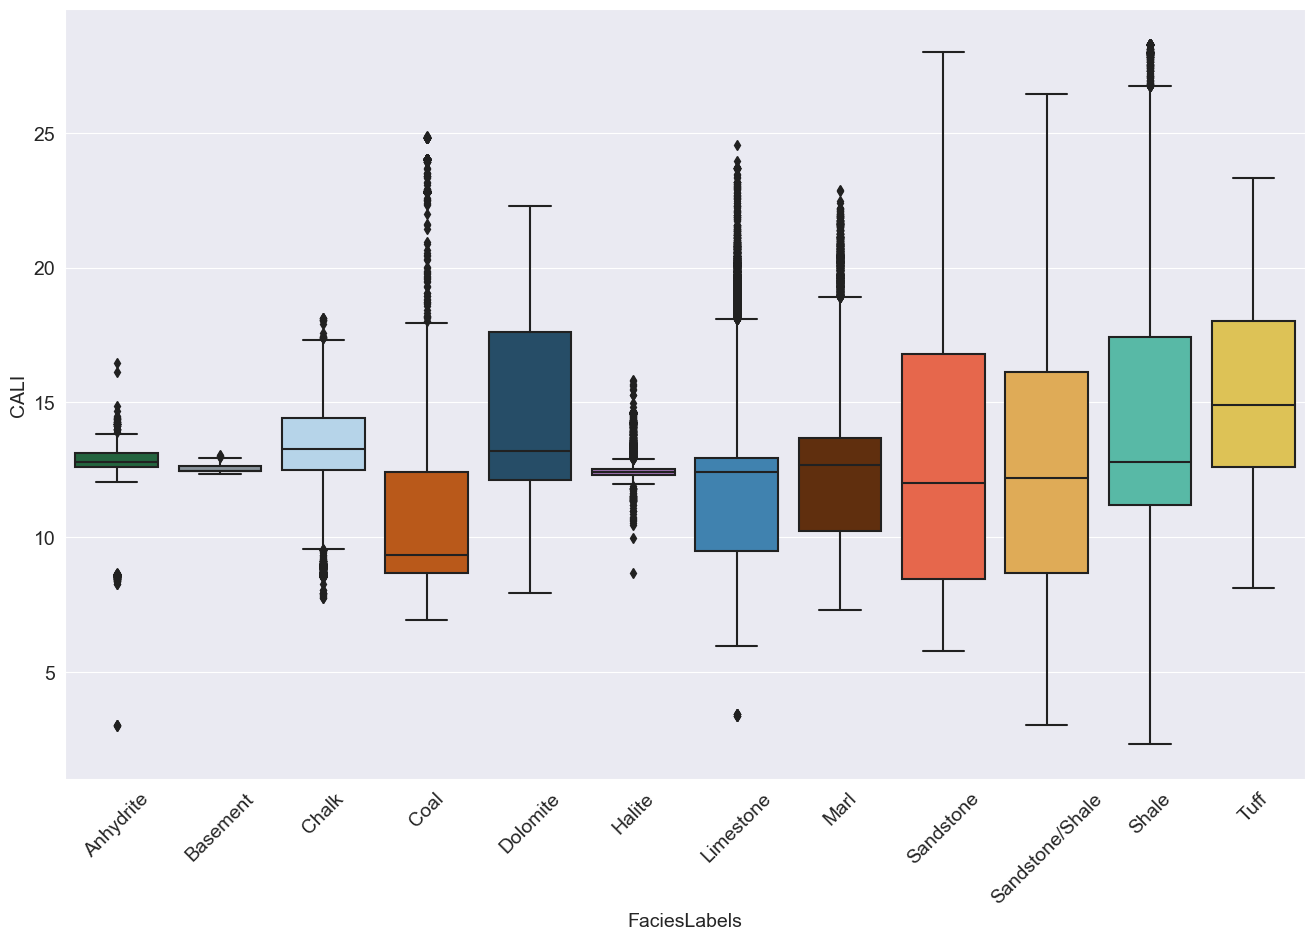

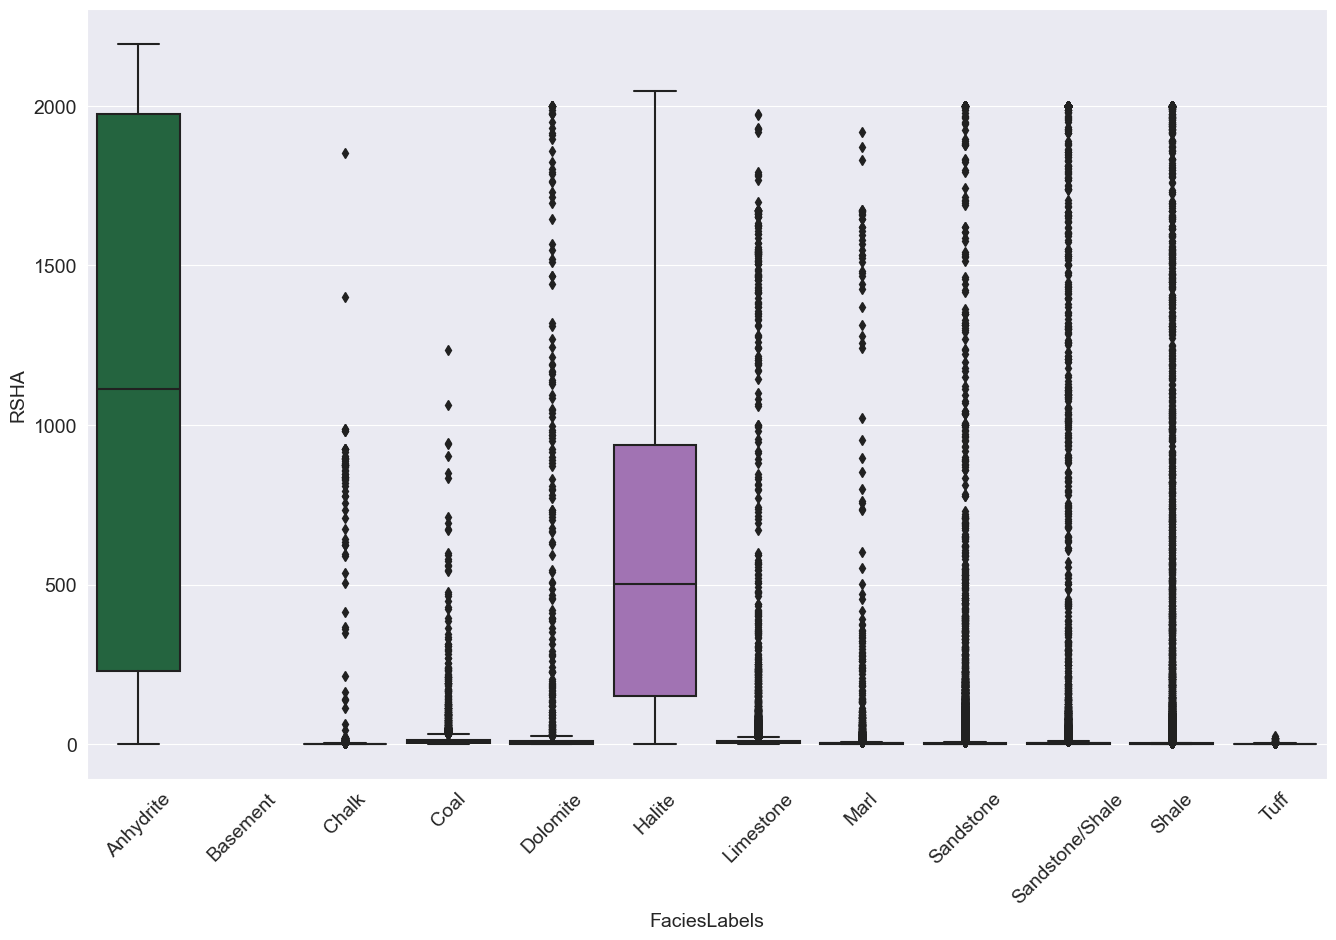

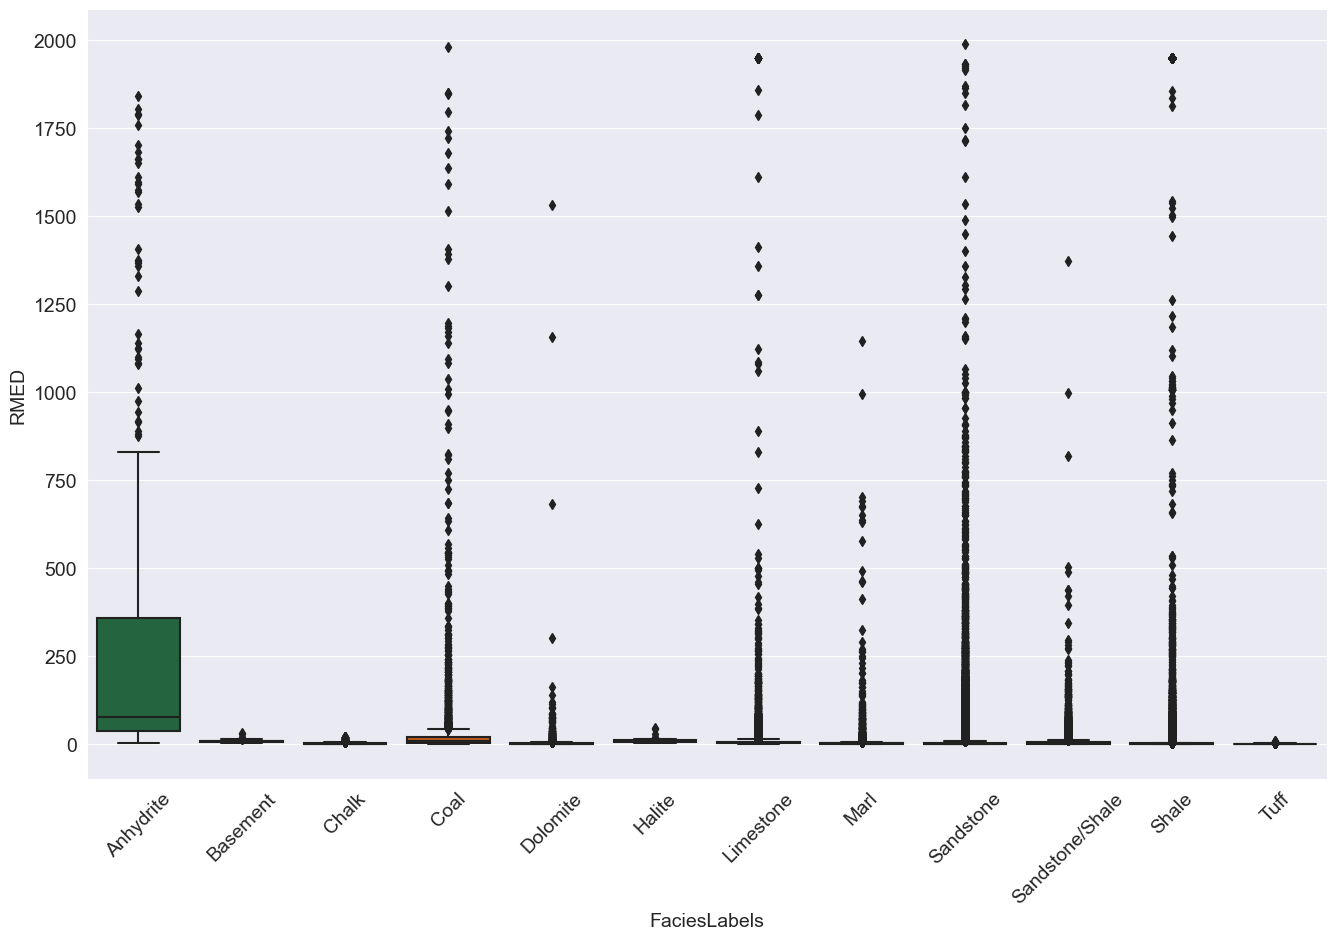

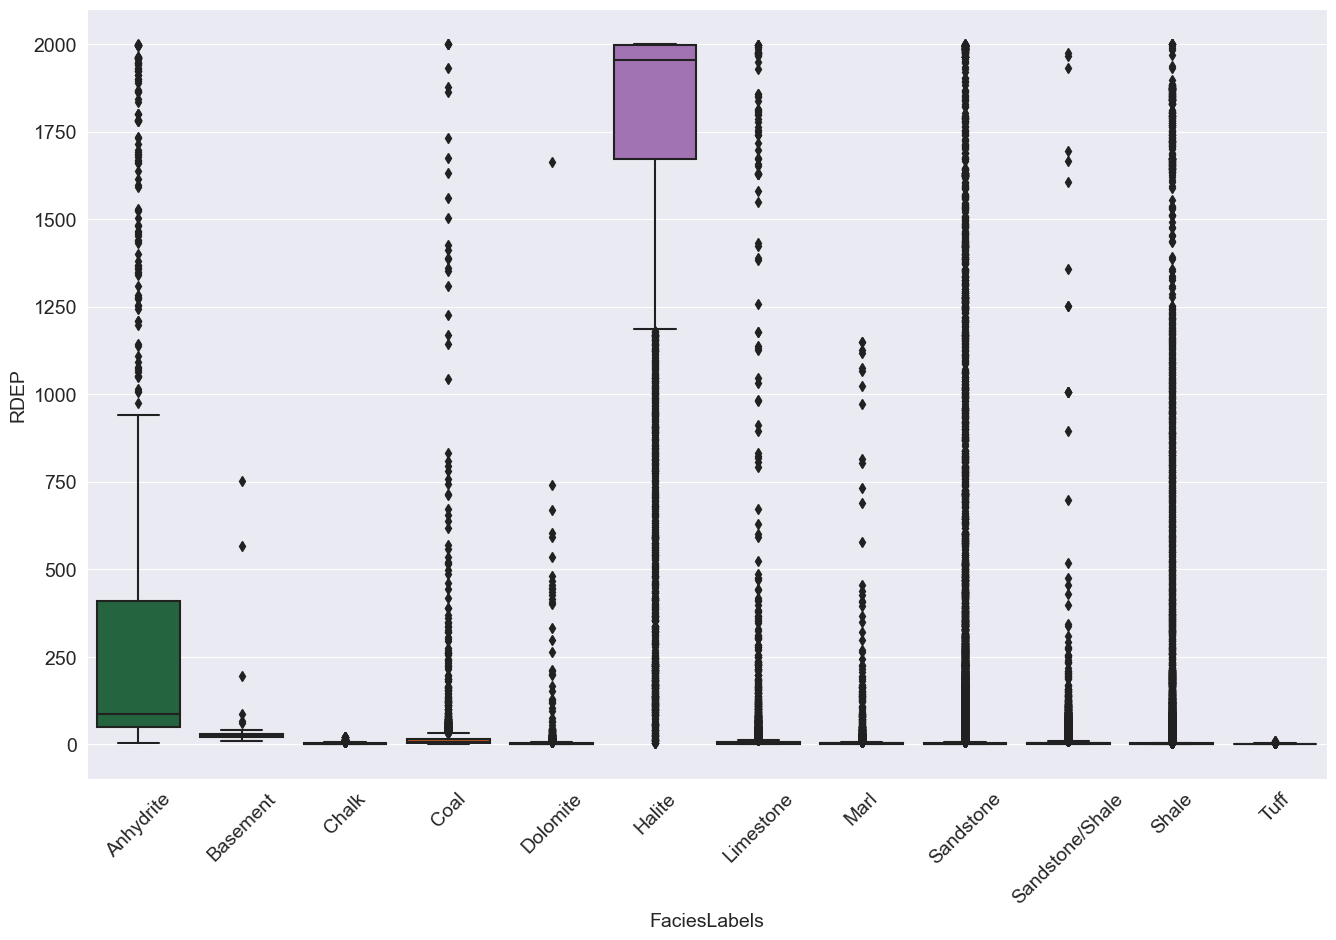

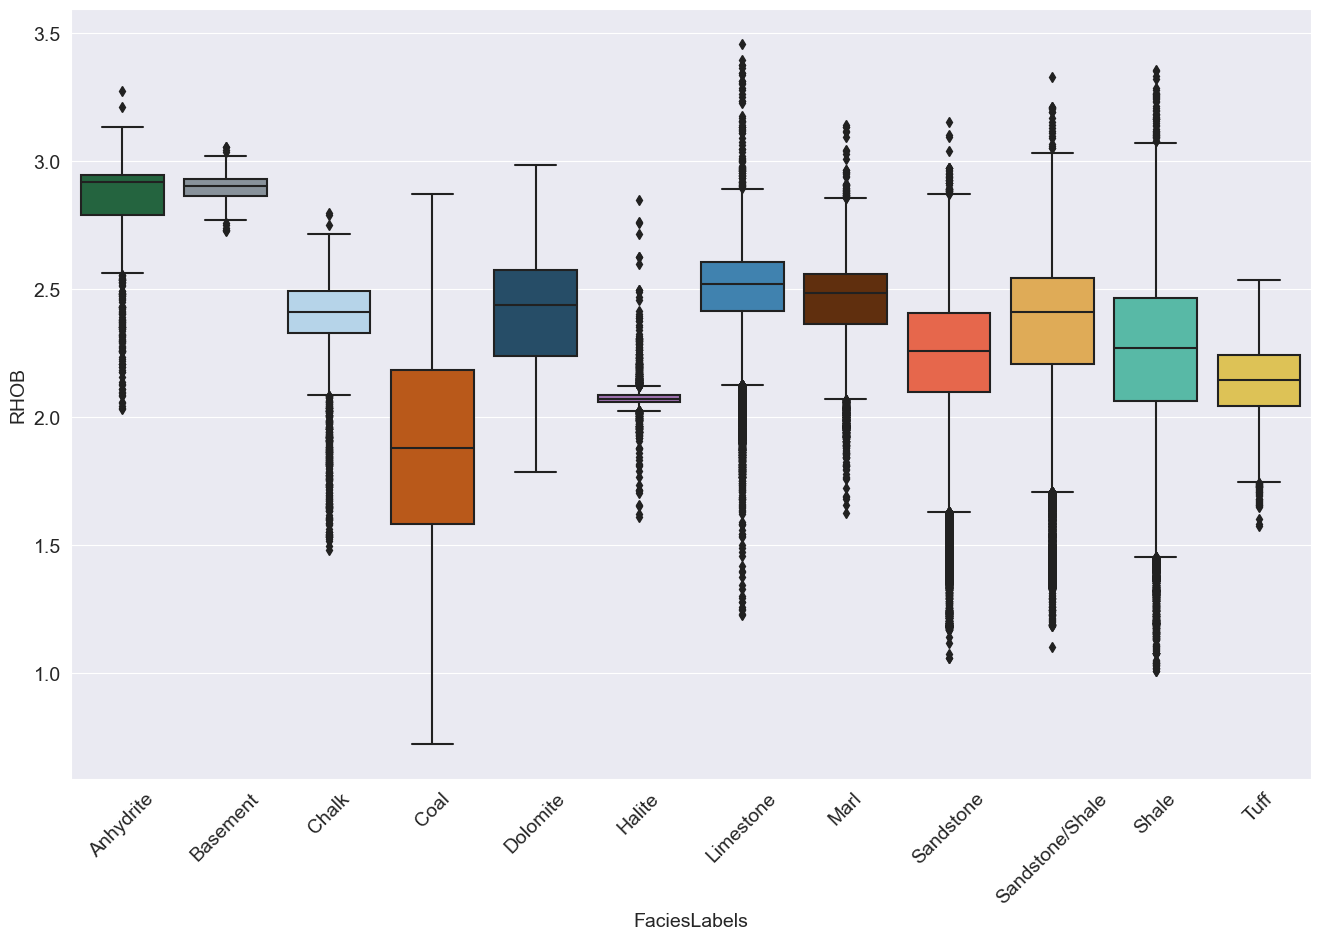

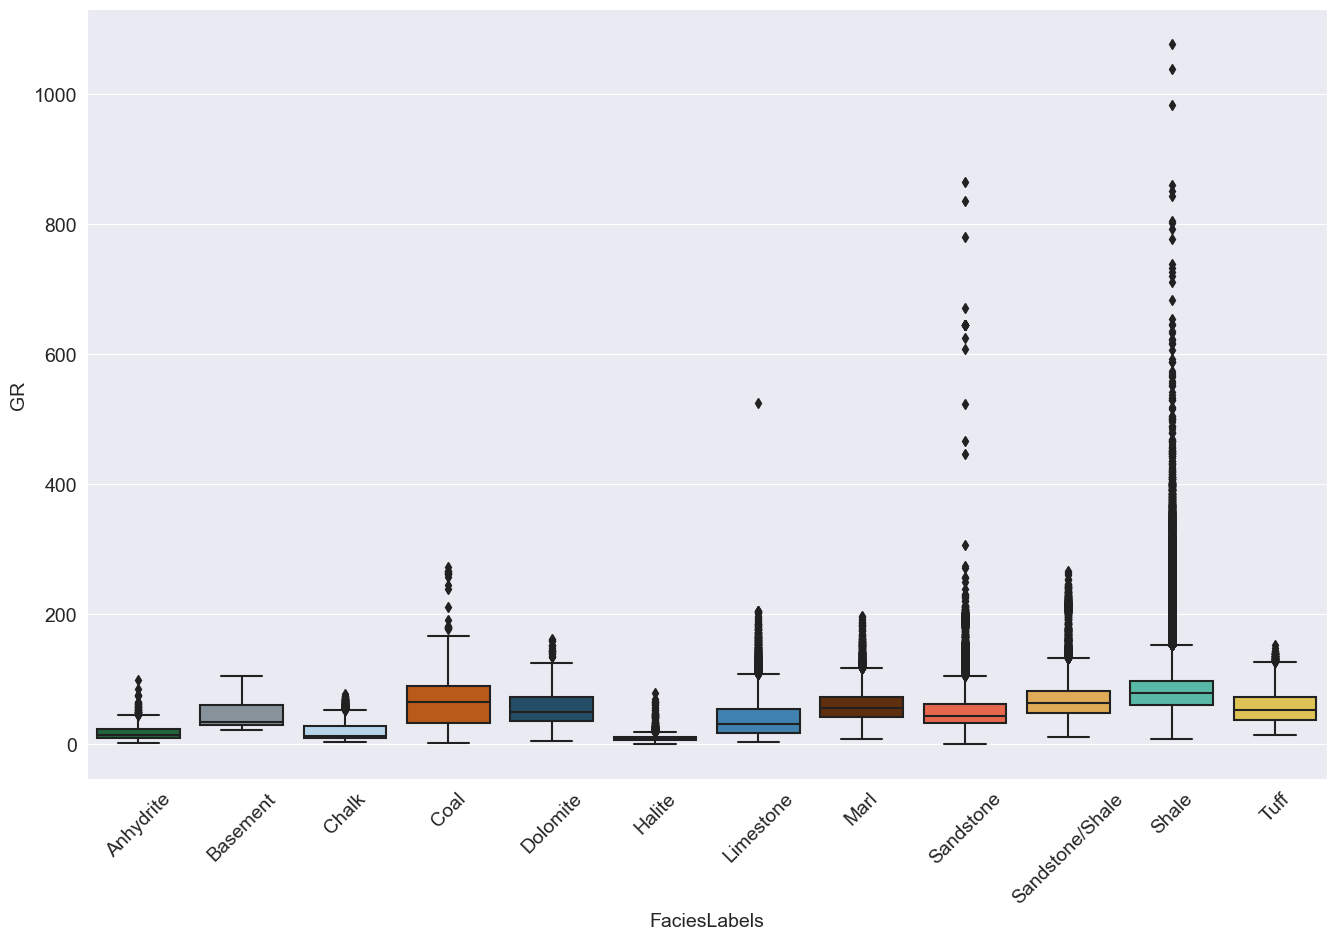

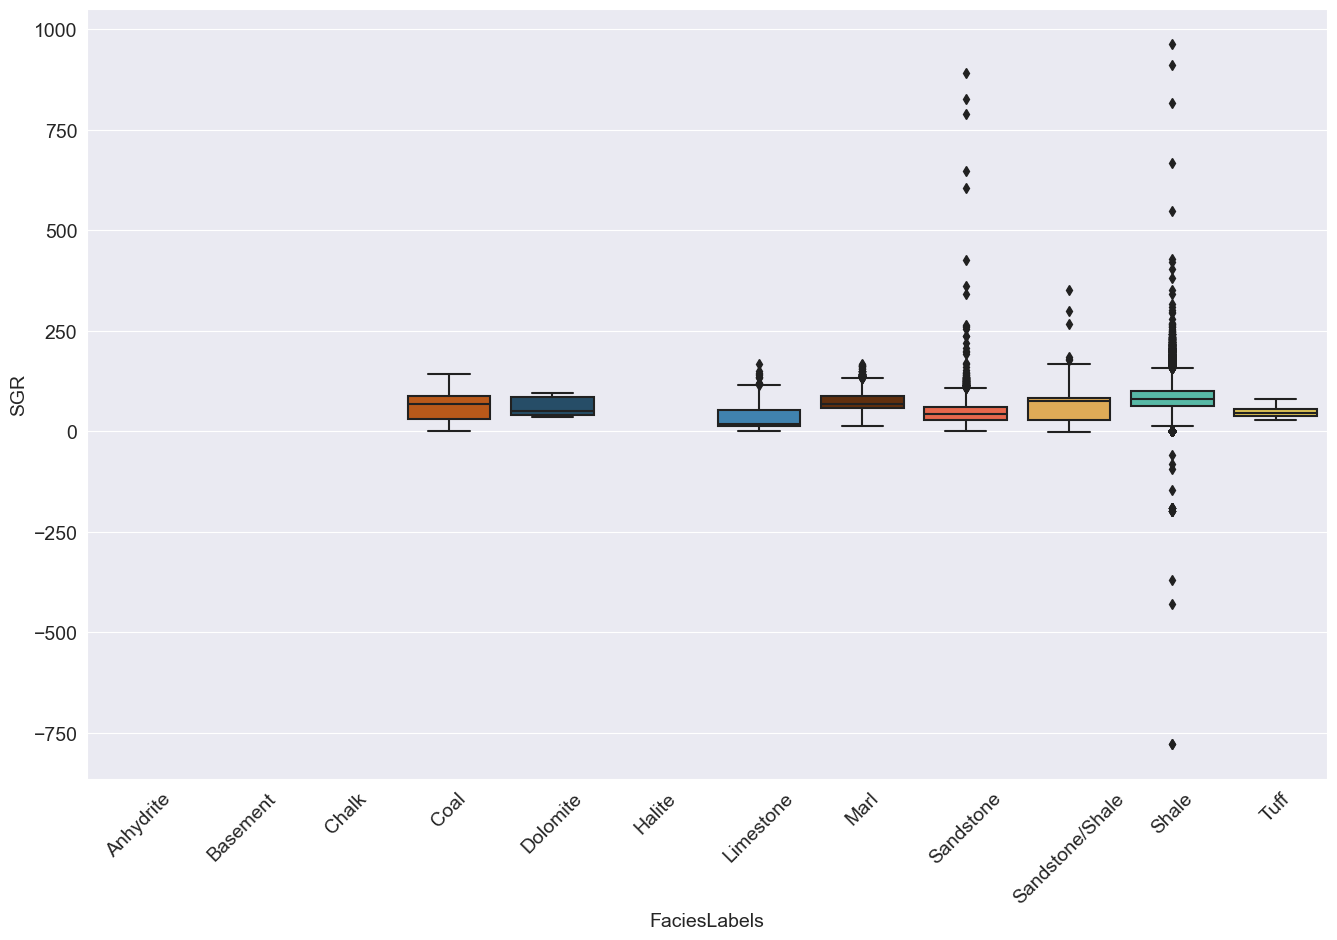

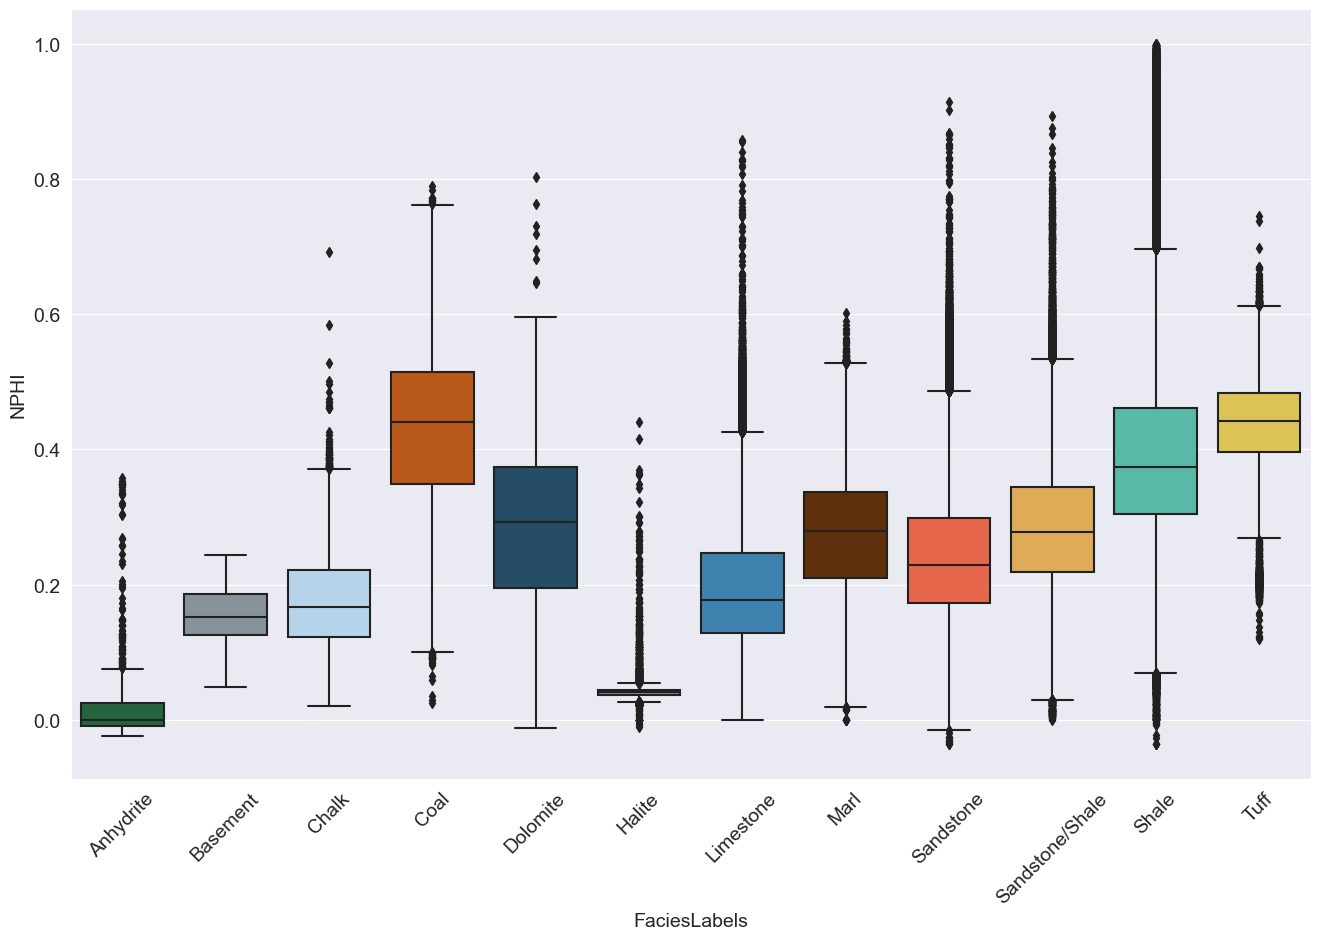

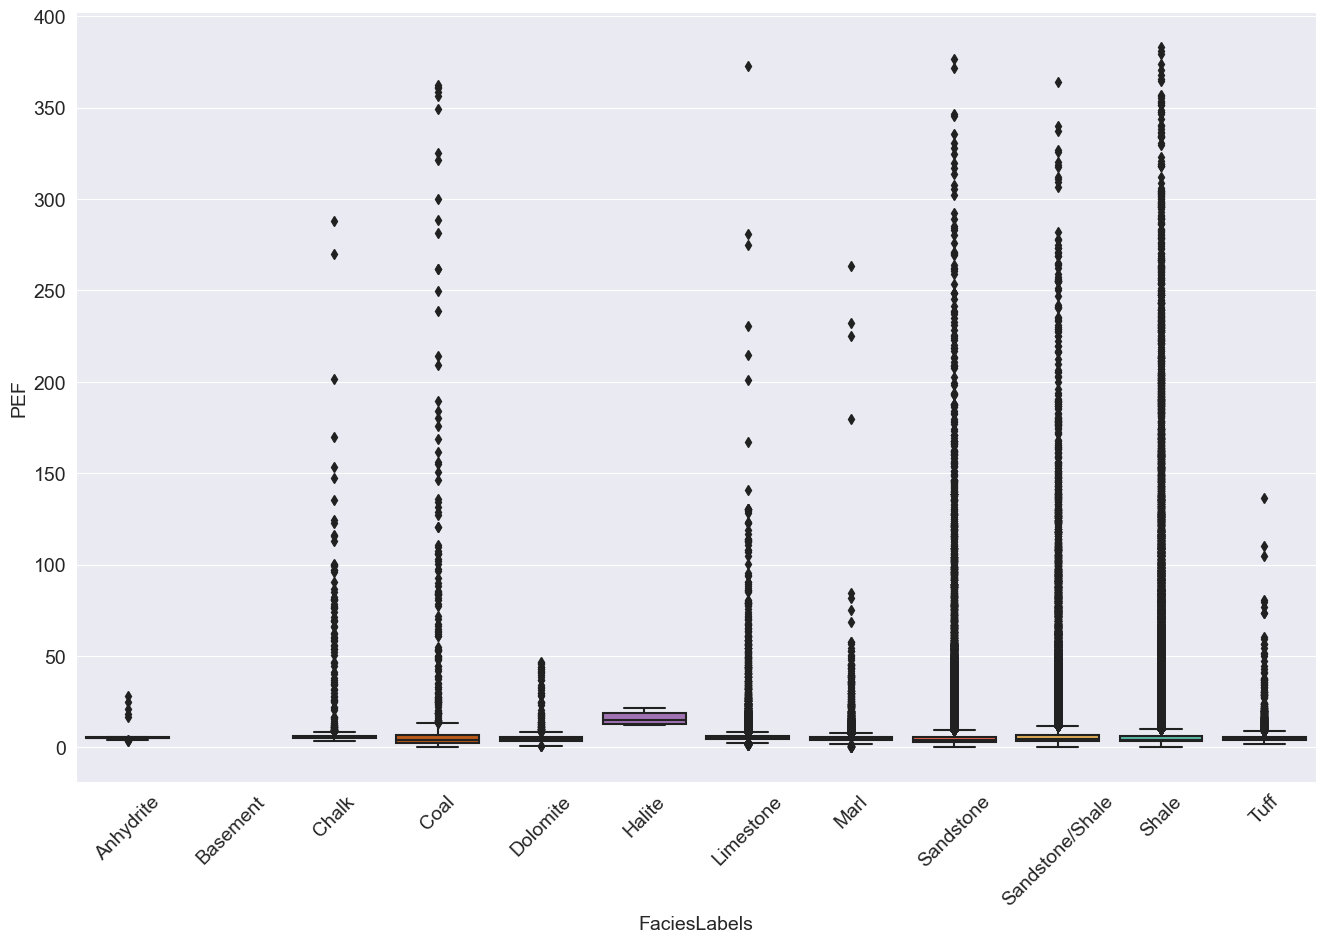

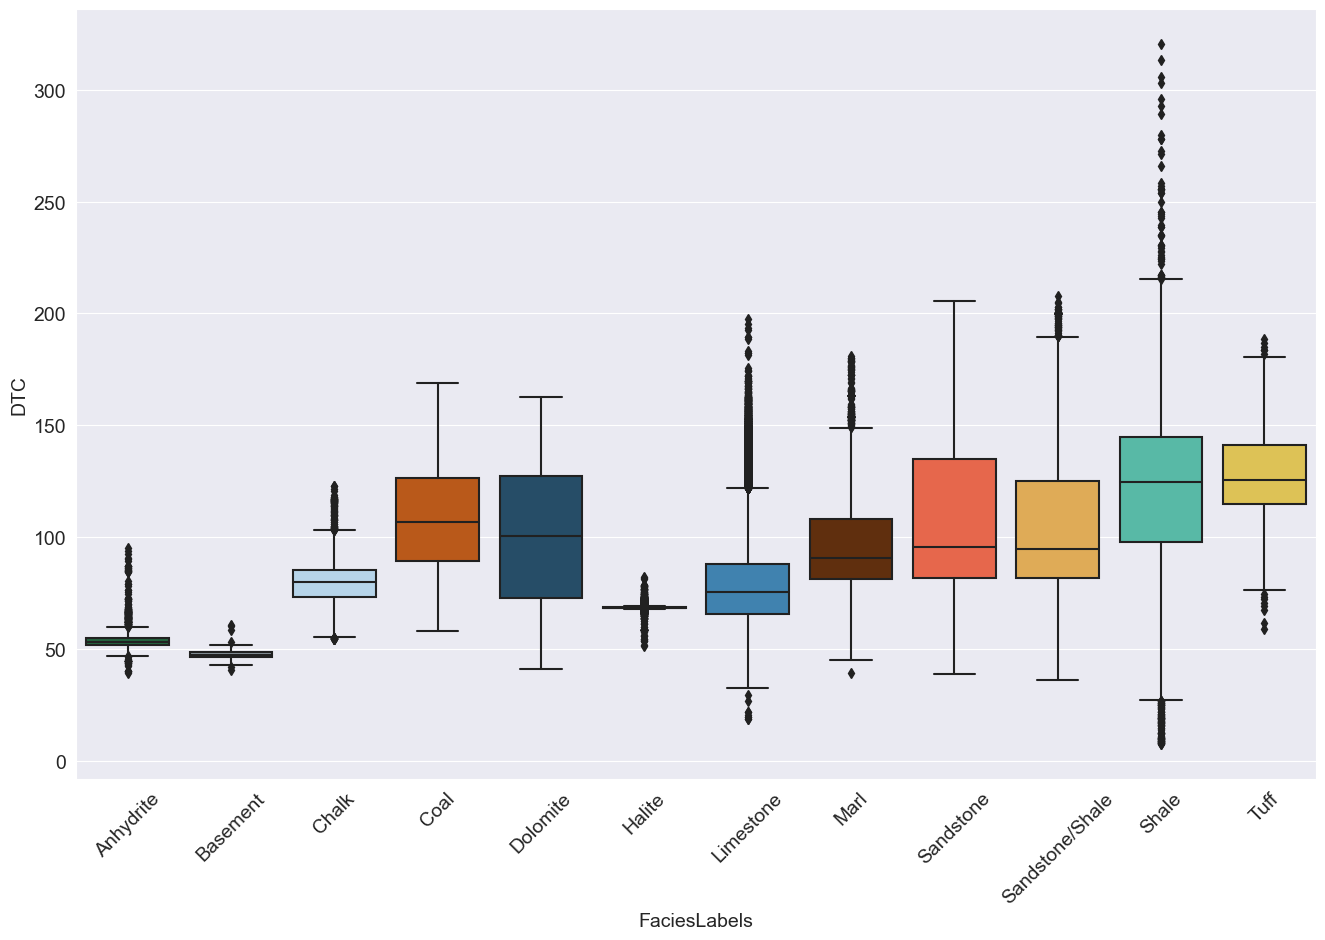

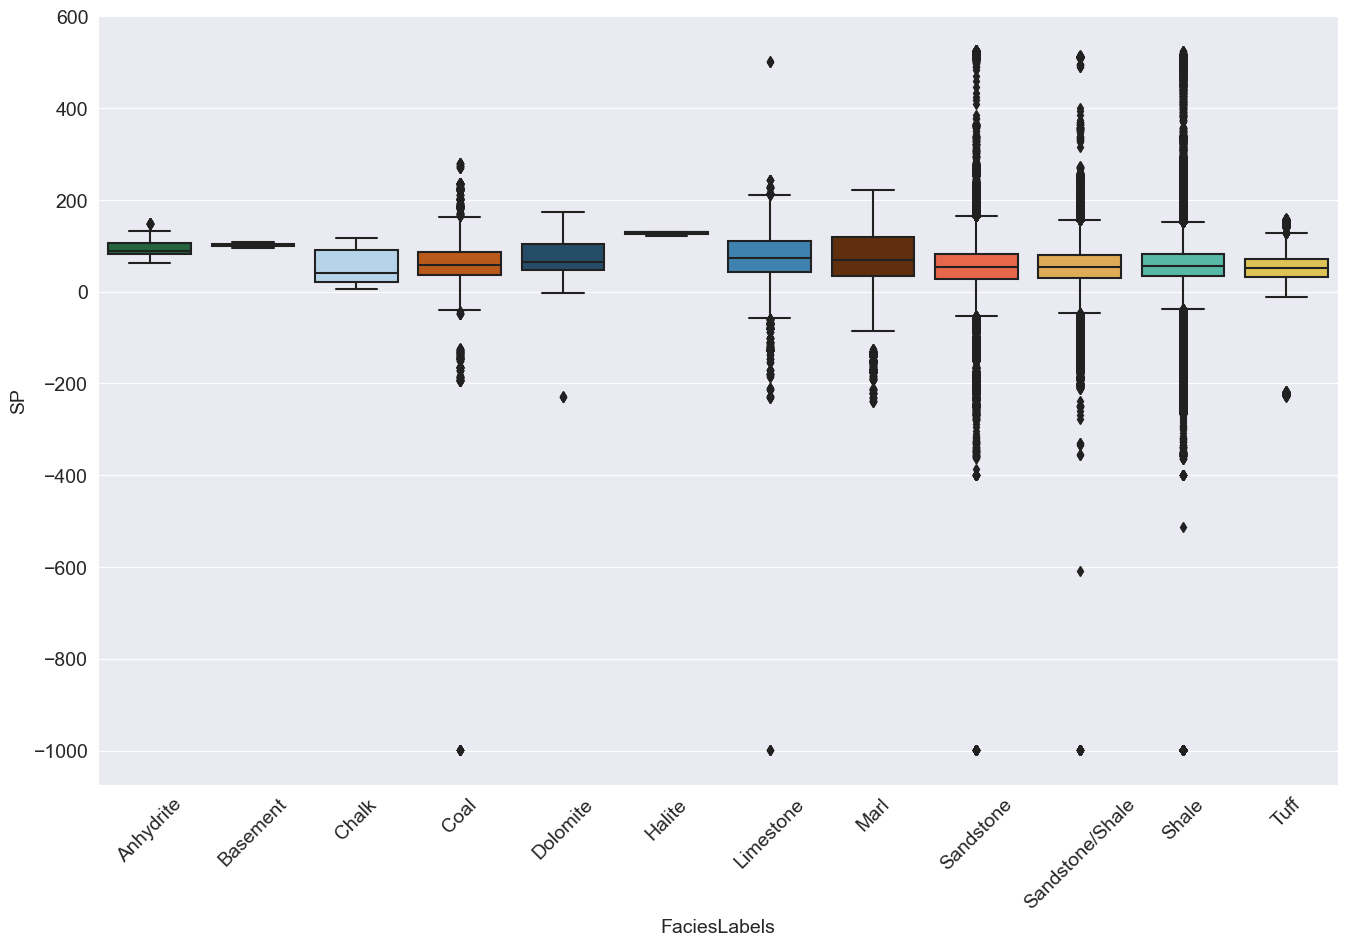

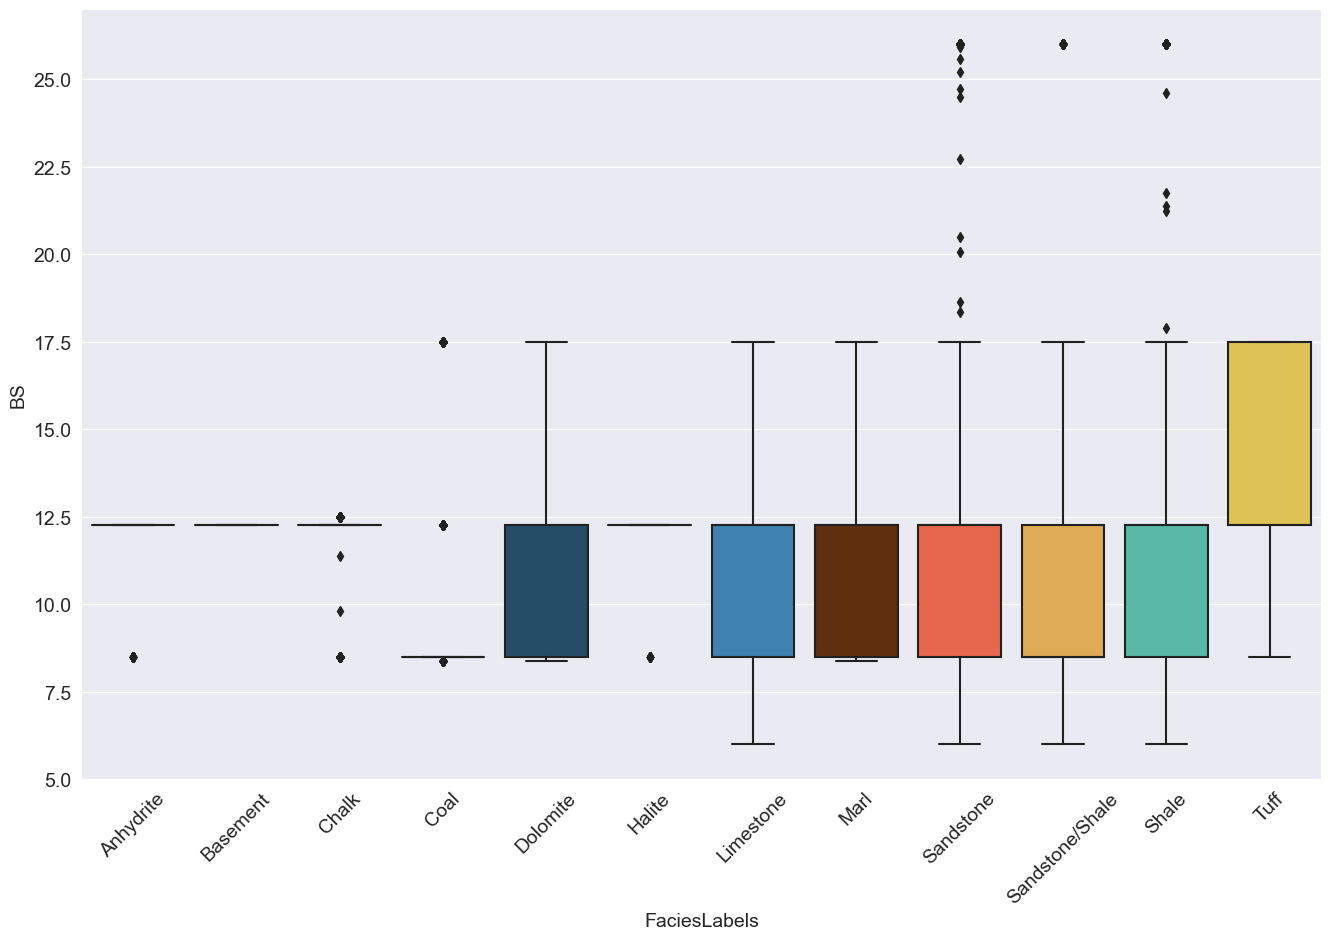

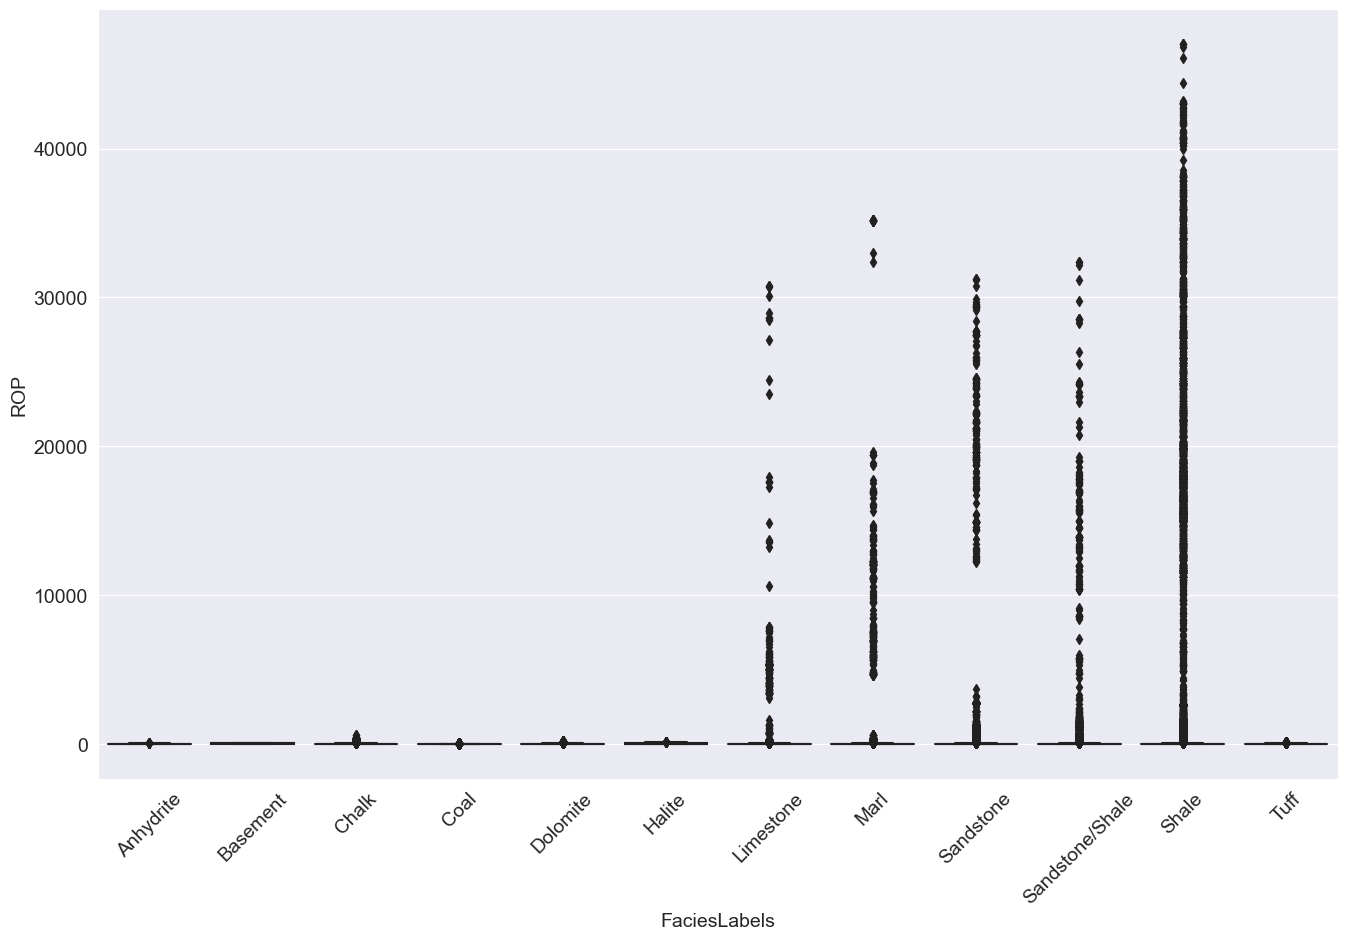

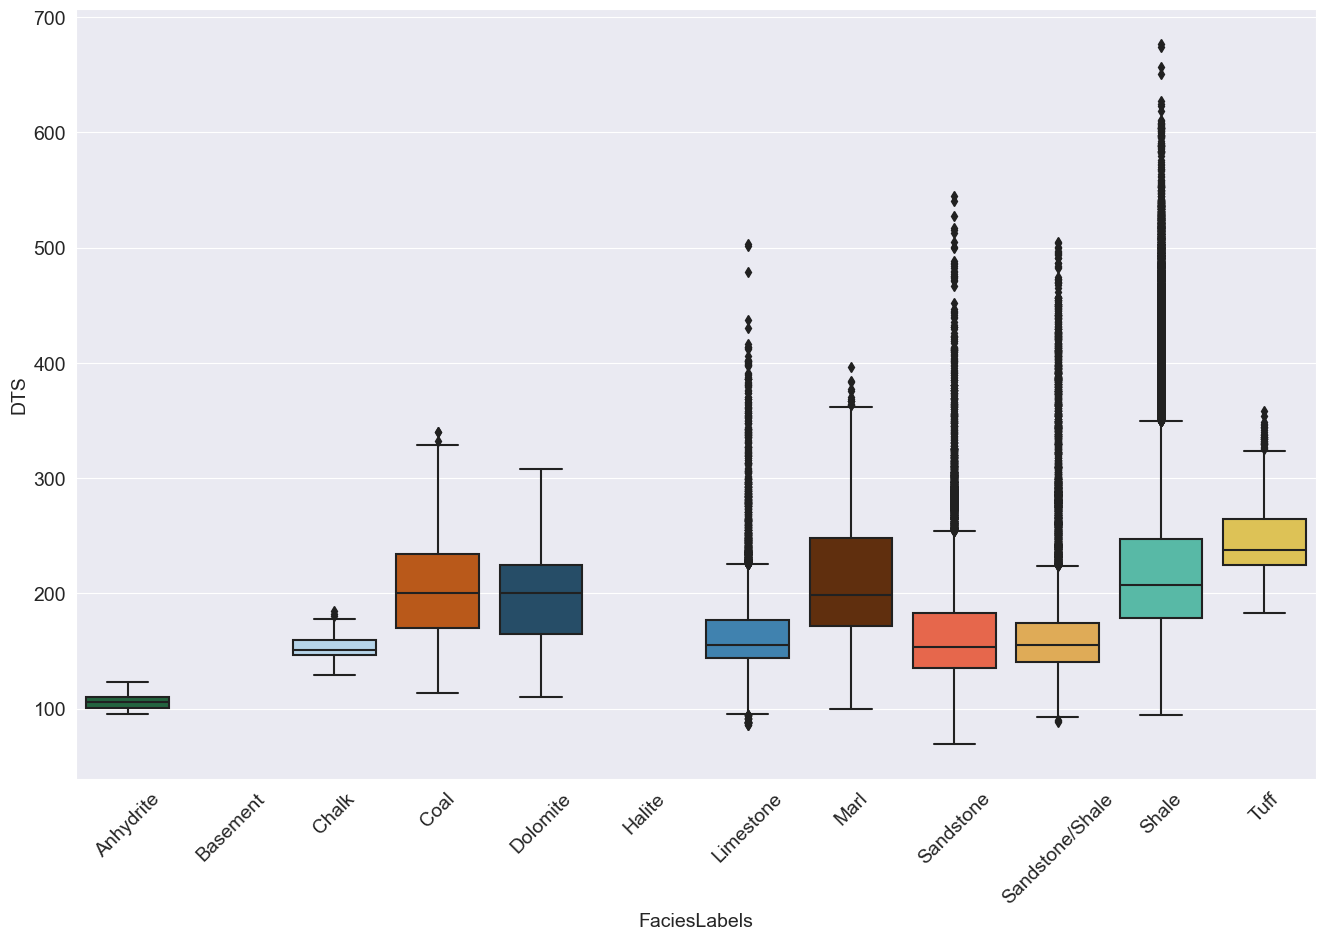

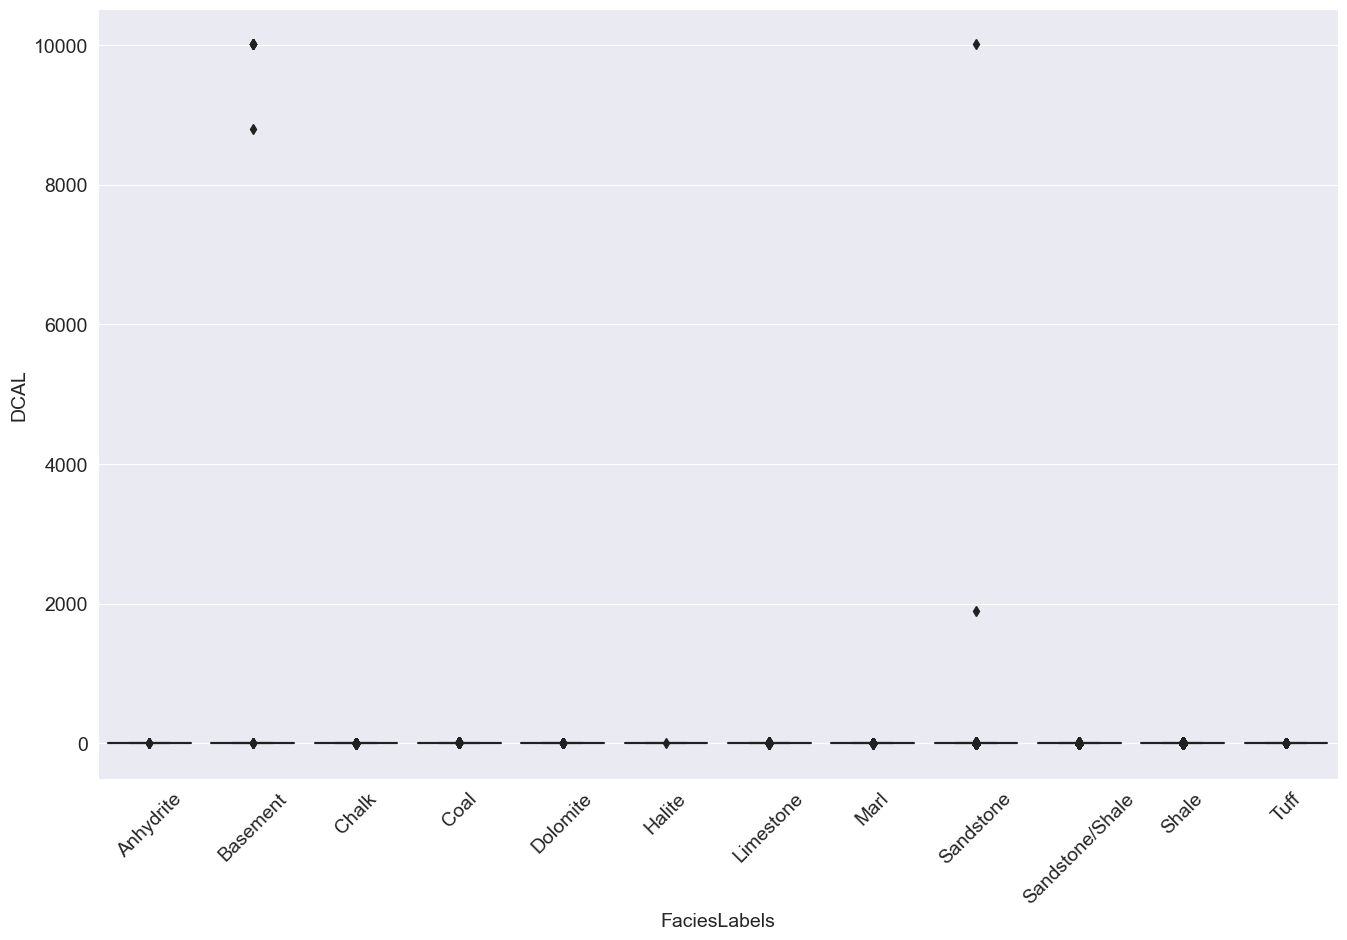

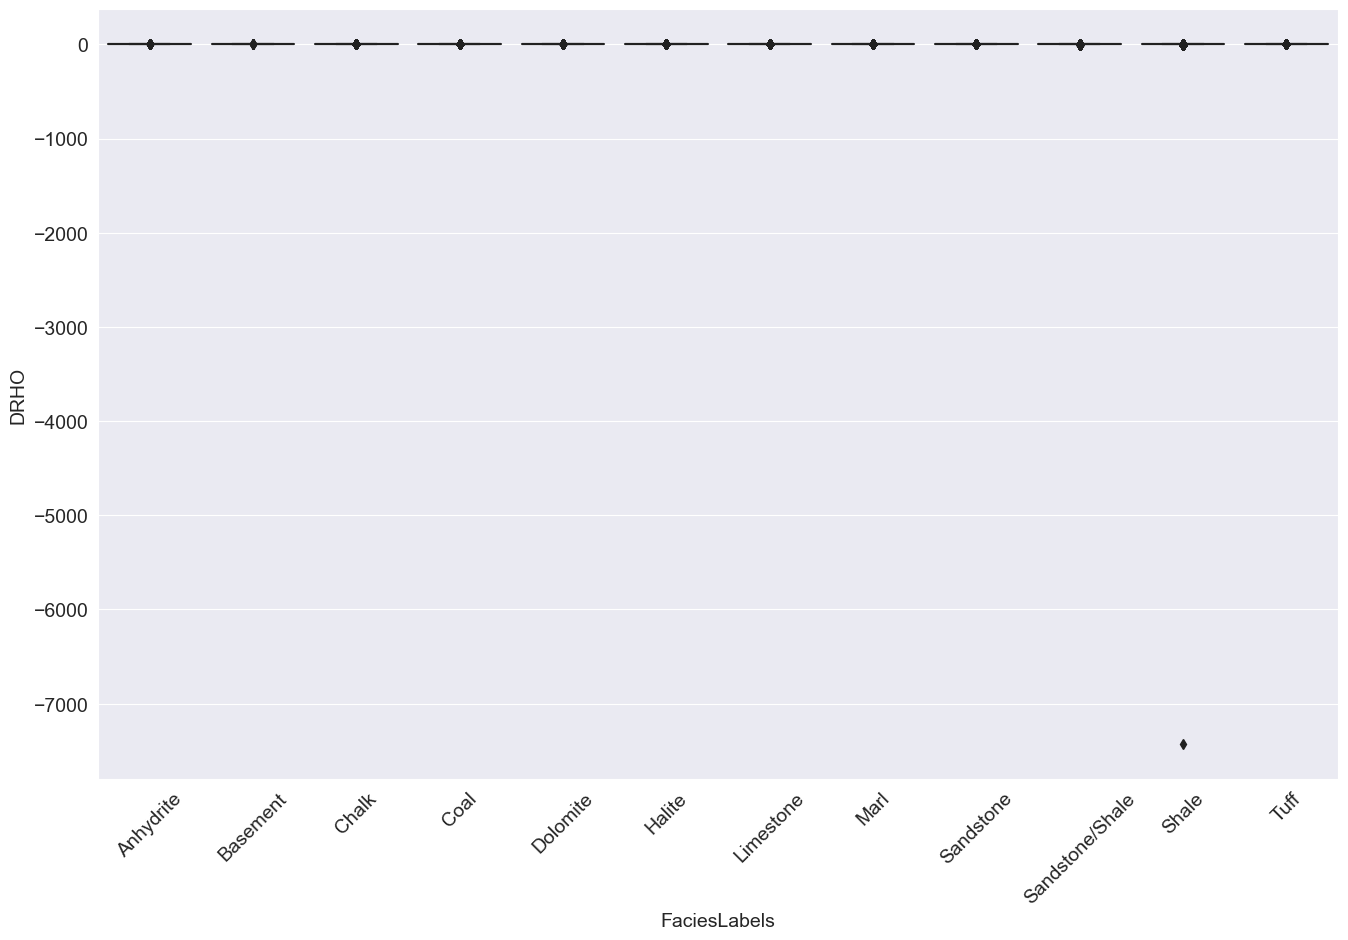

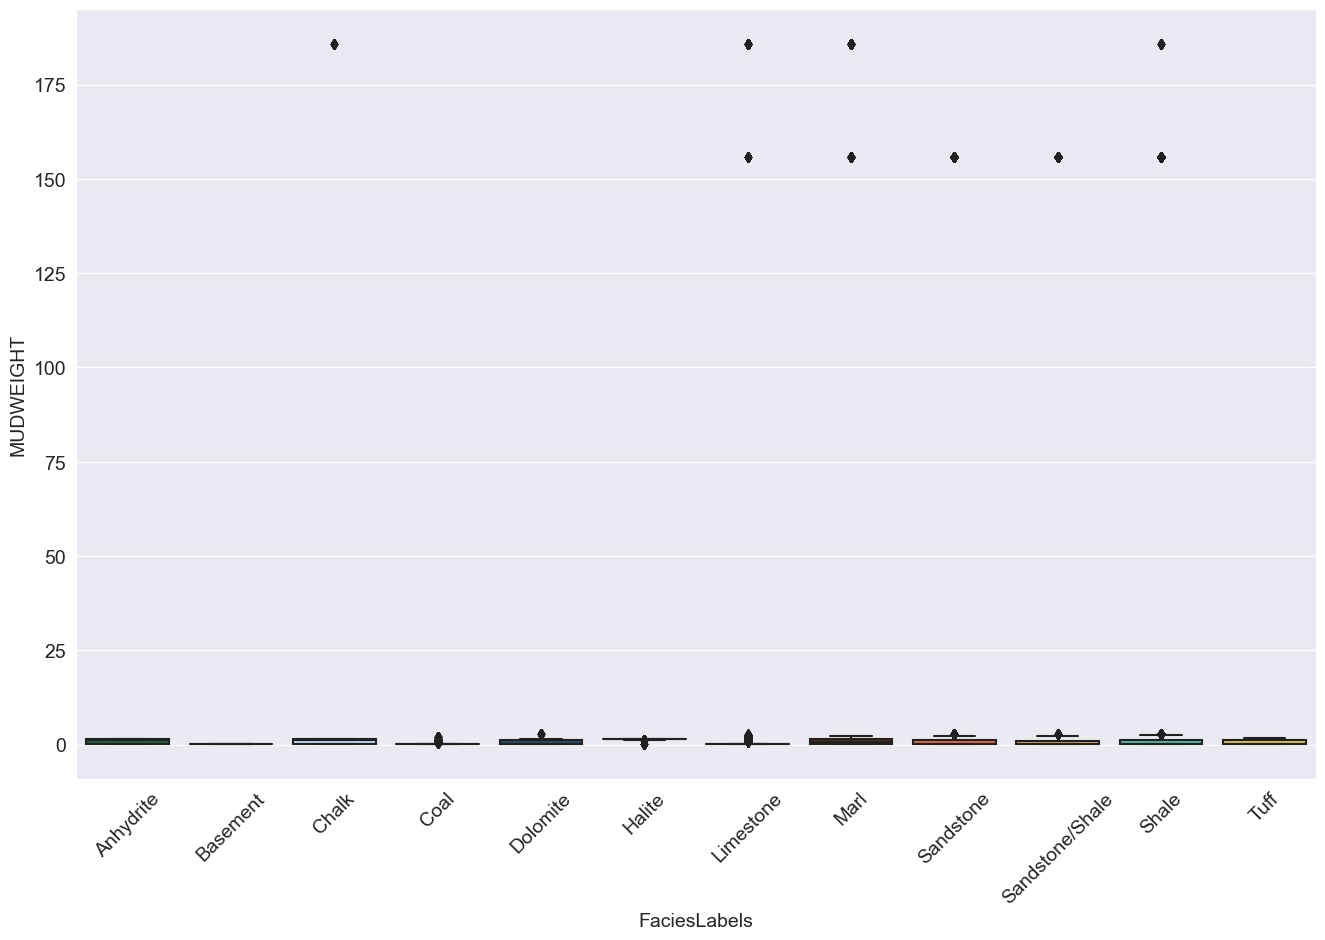

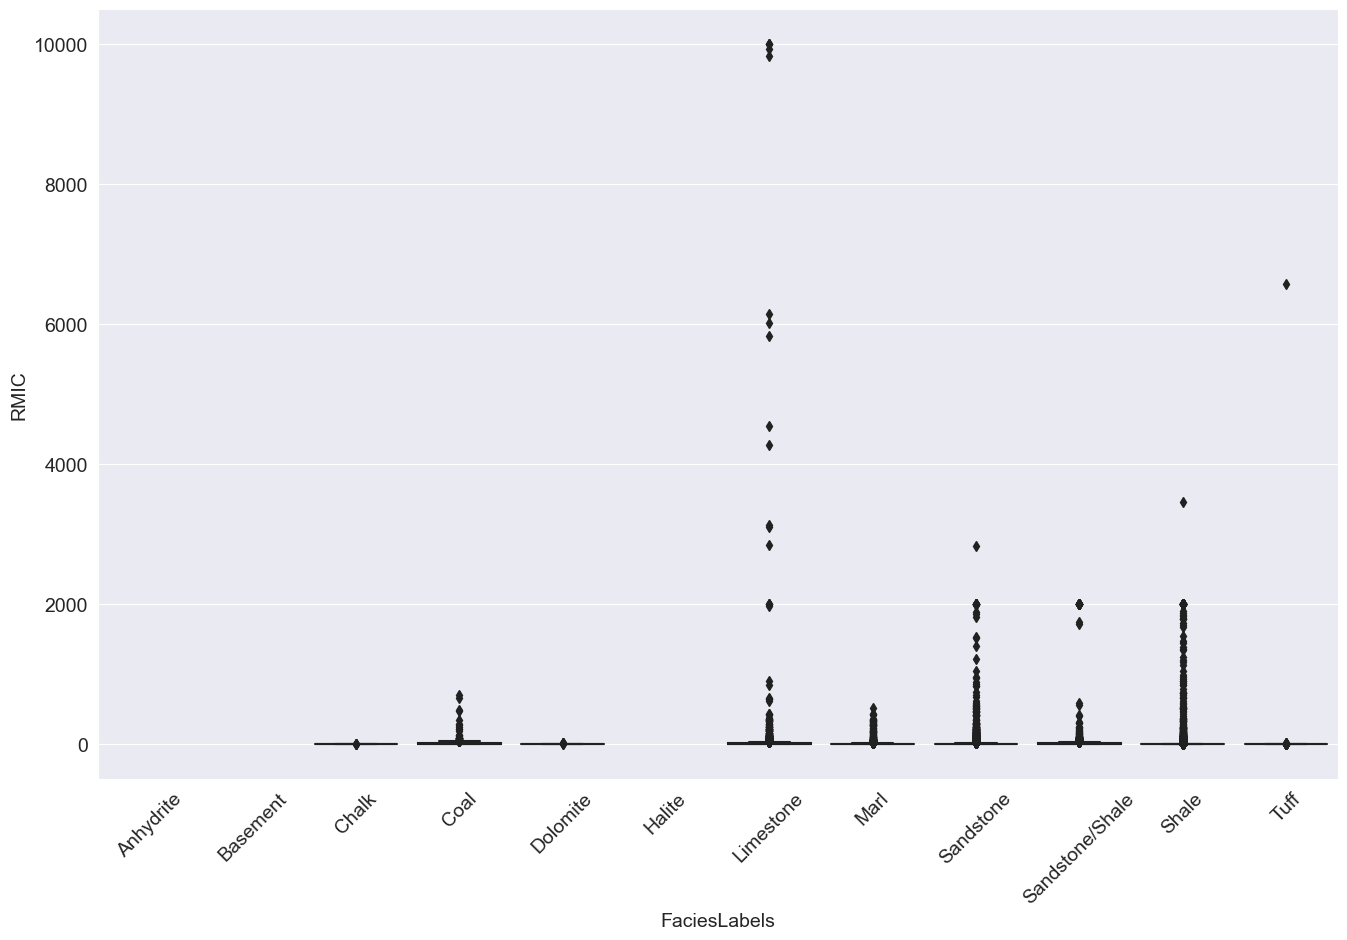

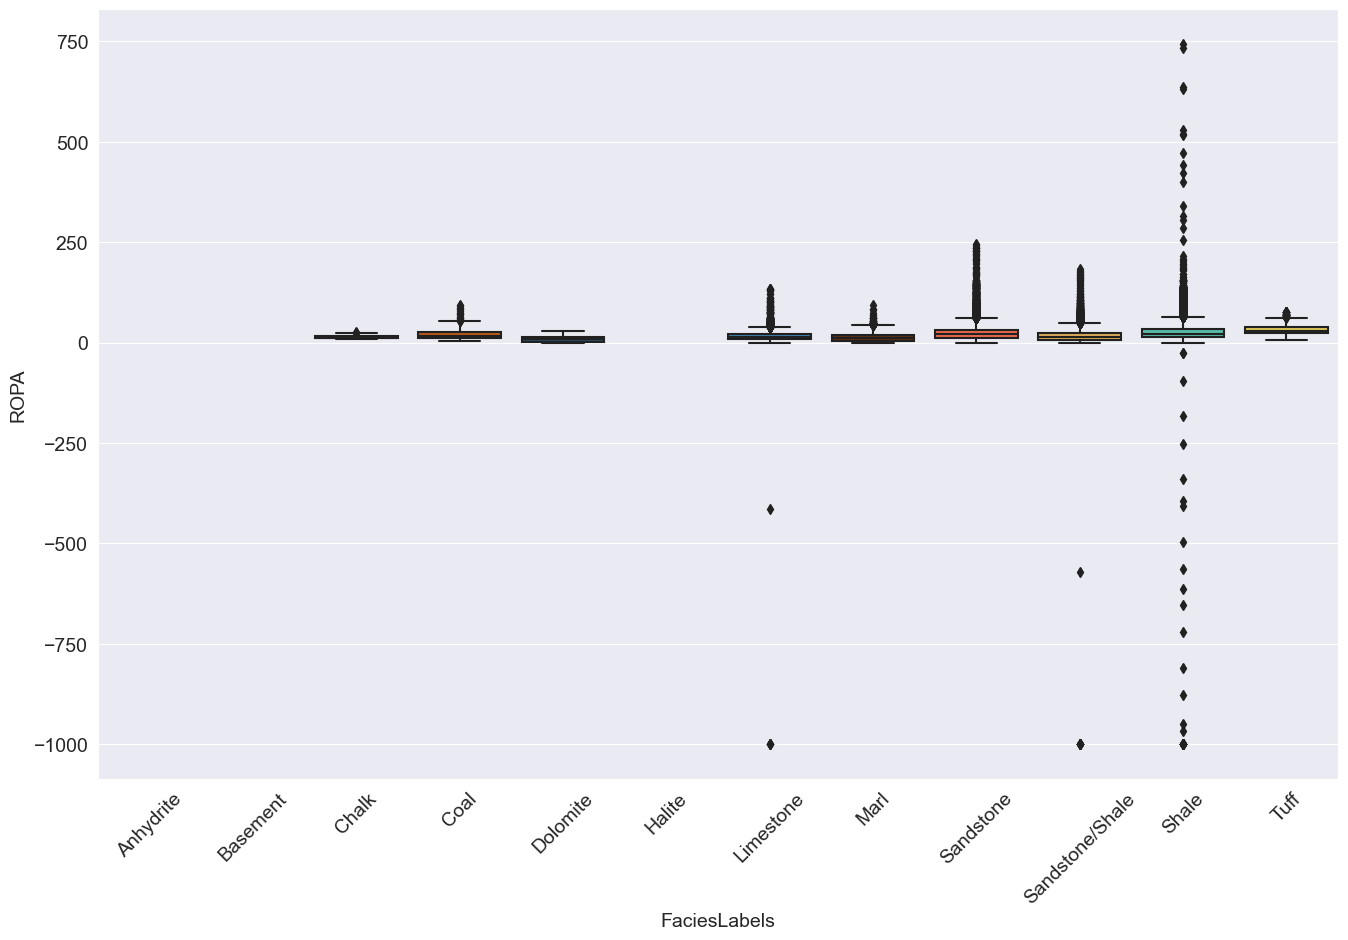

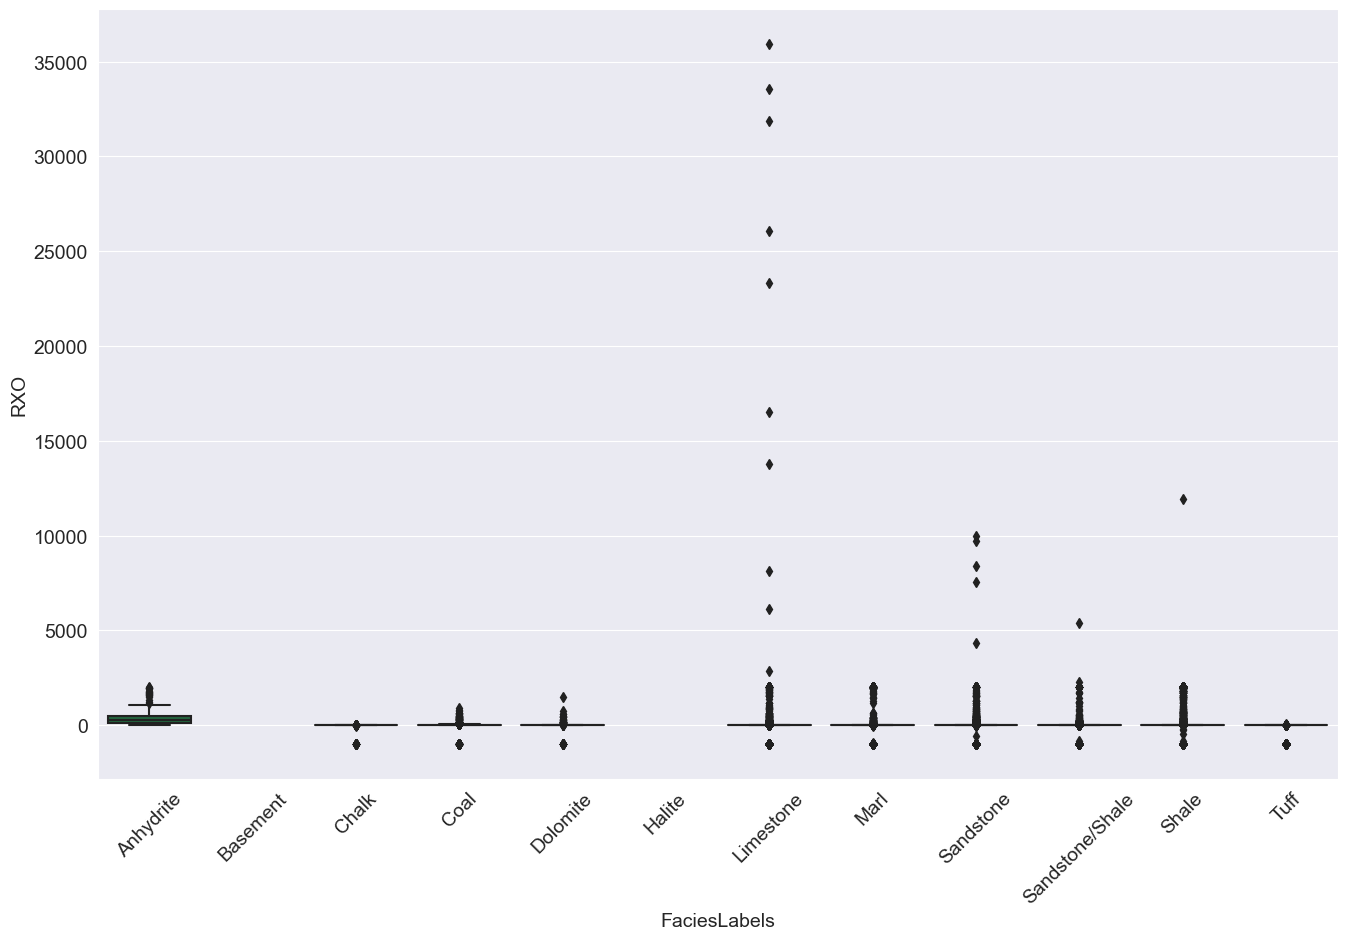

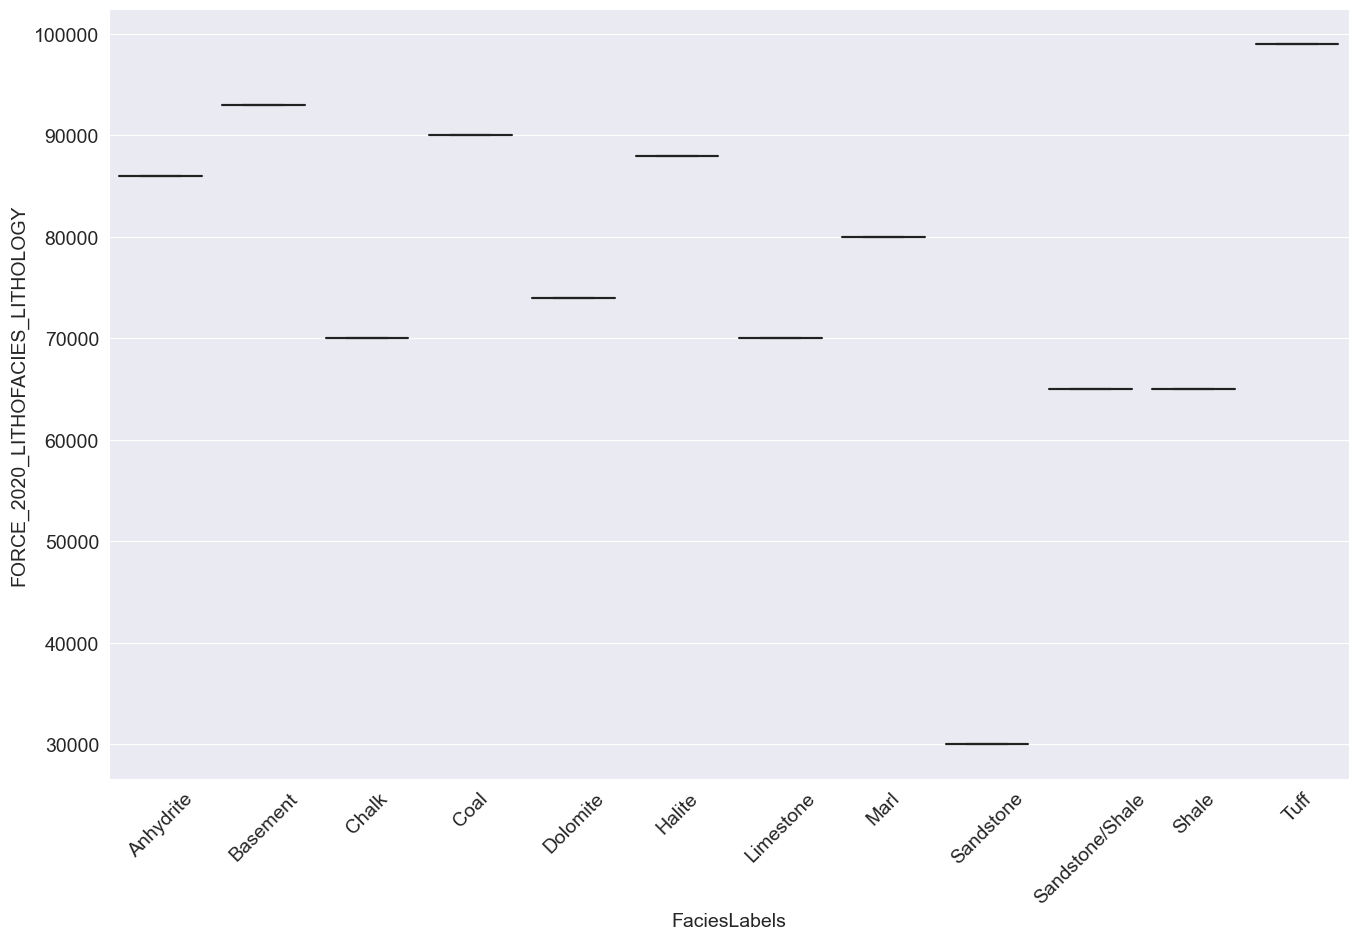

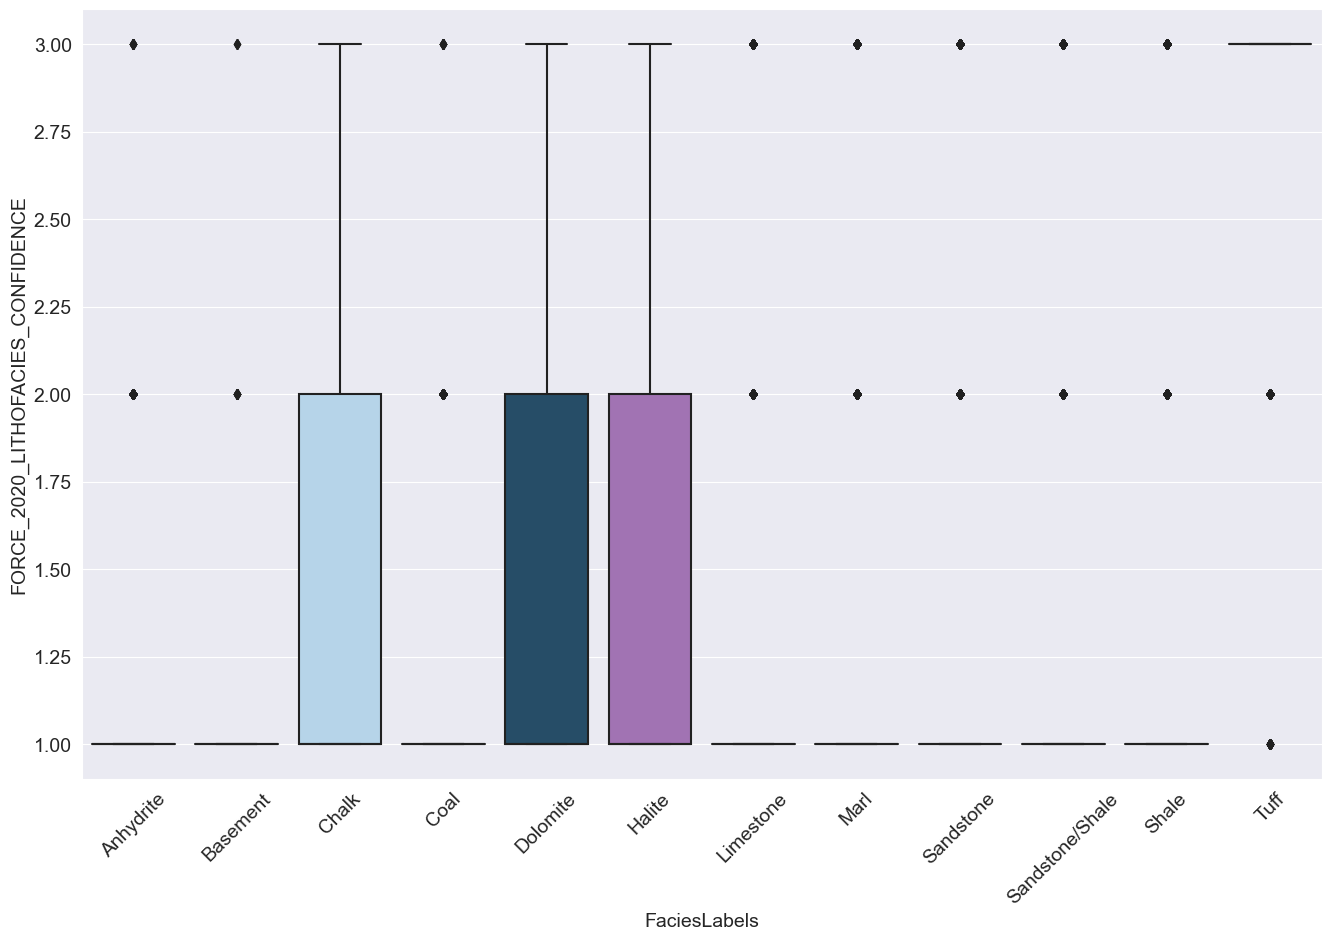

In [28]:
#Ящики с усами
for col in numeric_columns[1:]:
    if col != 'NM_M':
        fig = plt.figure()
        fig.set_size_inches(16, 10)
        sns.boxplot(y=col, x=df['FaciesLabels'].astype('category'), data=df, palette=facies_colors)
        plt.xticks(rotation=45)
        plt.show()

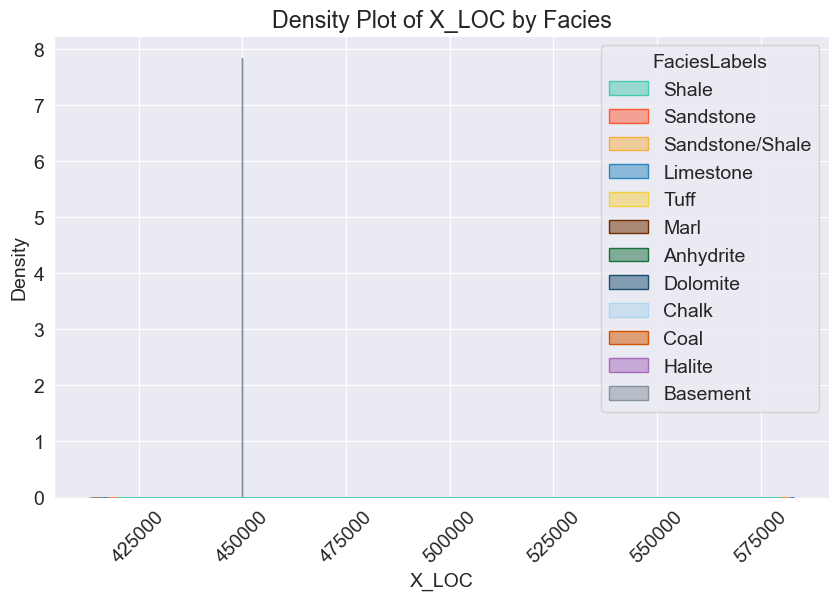

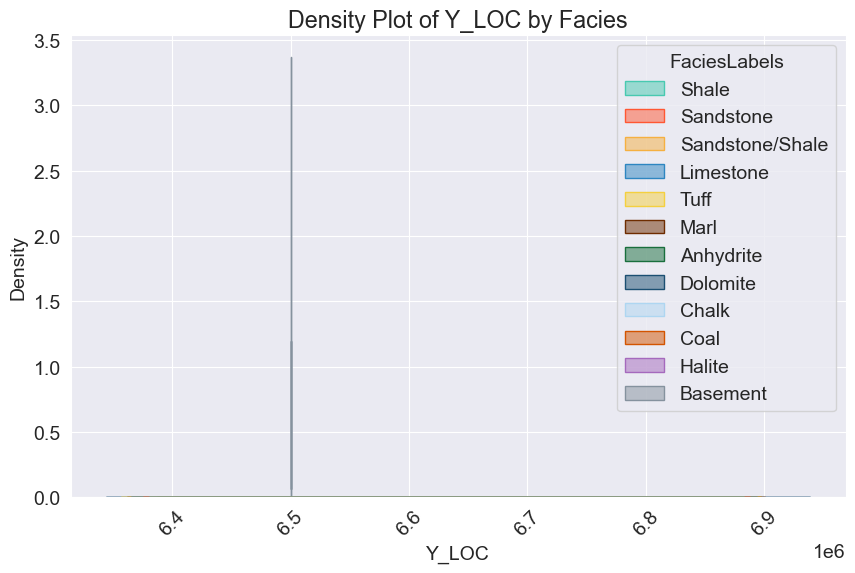

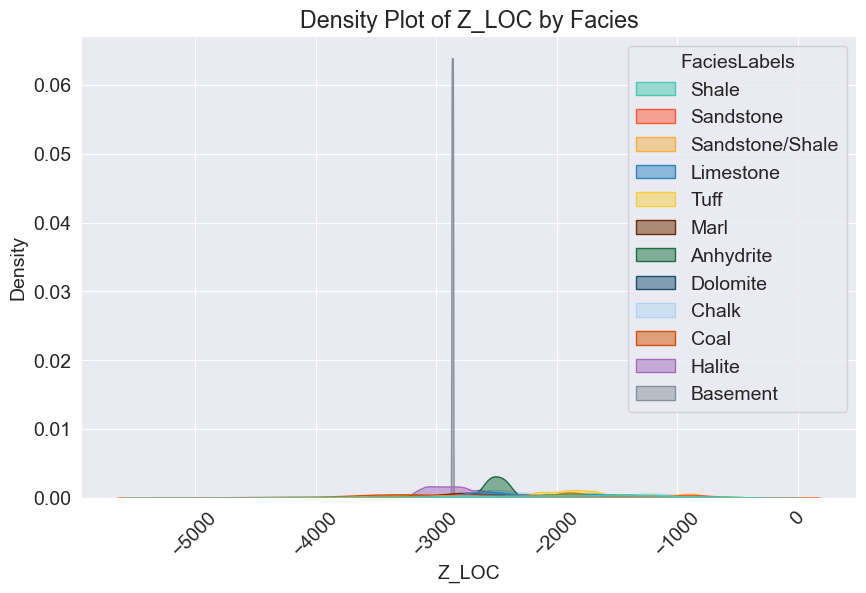

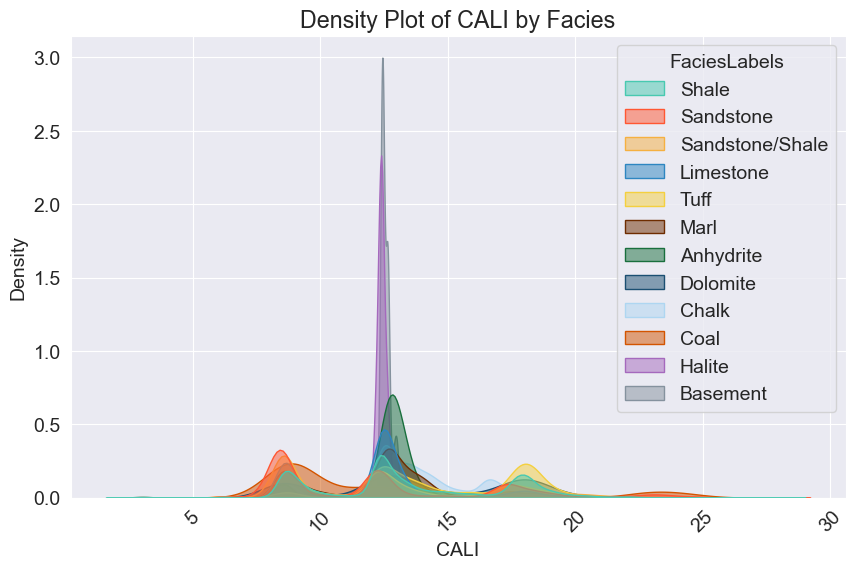

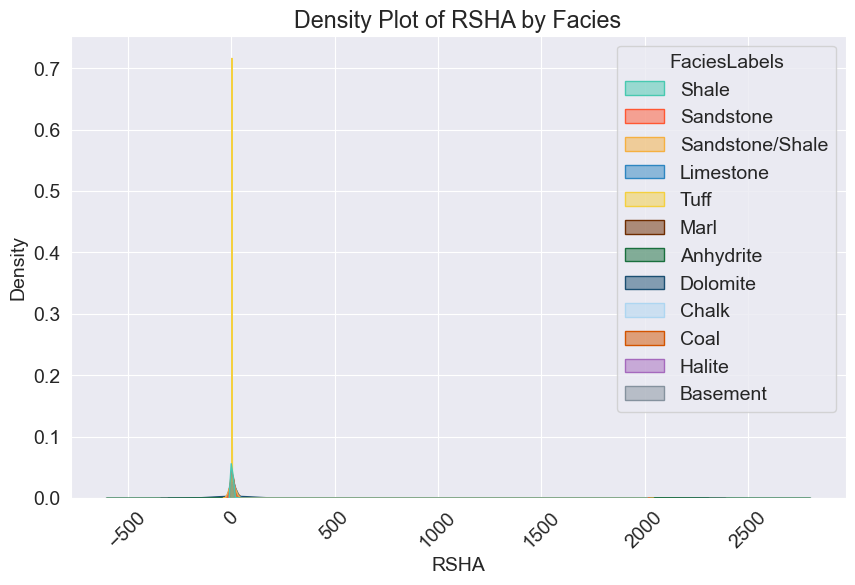

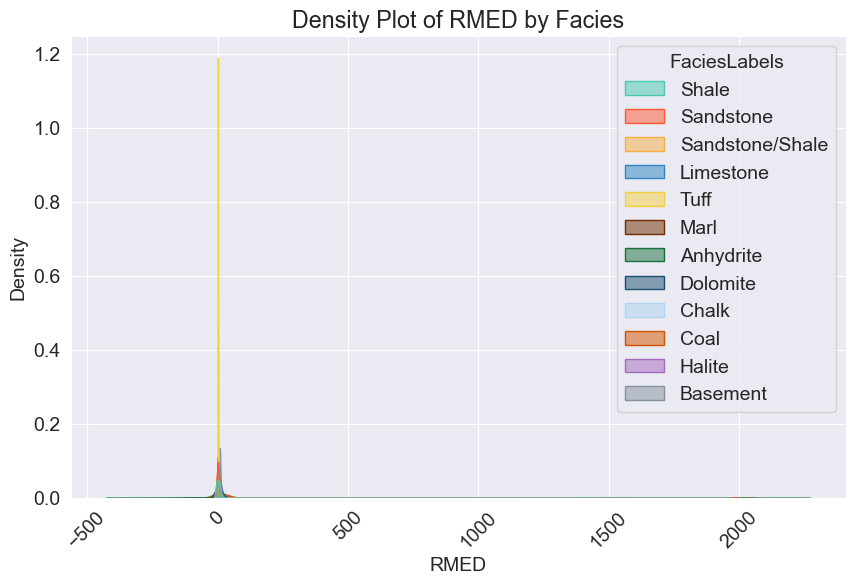

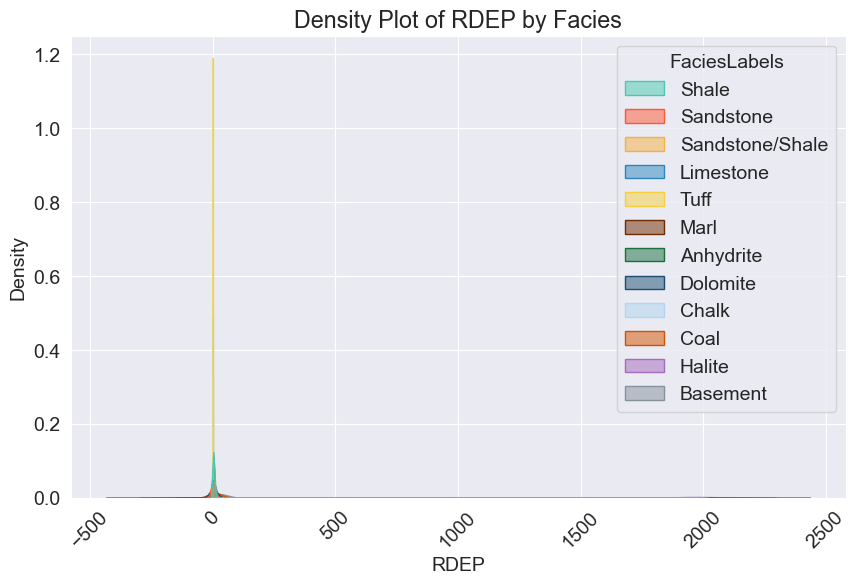

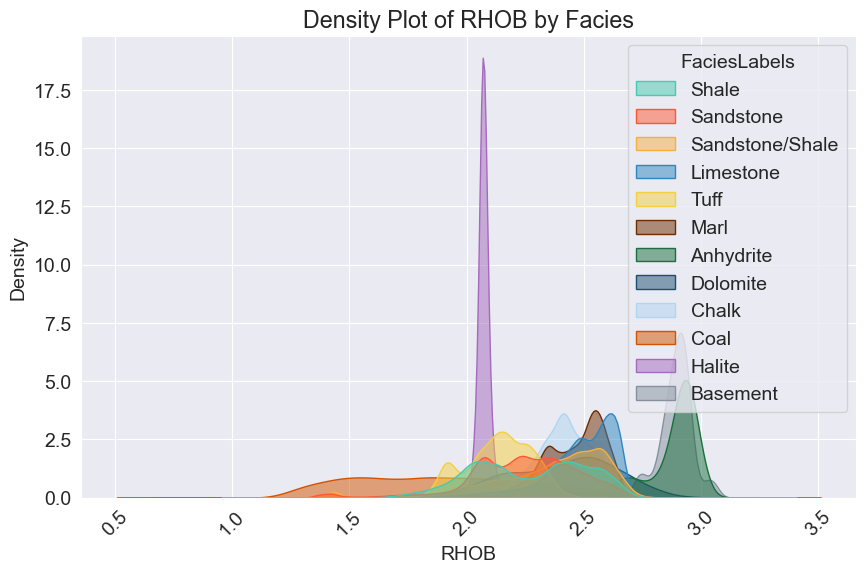

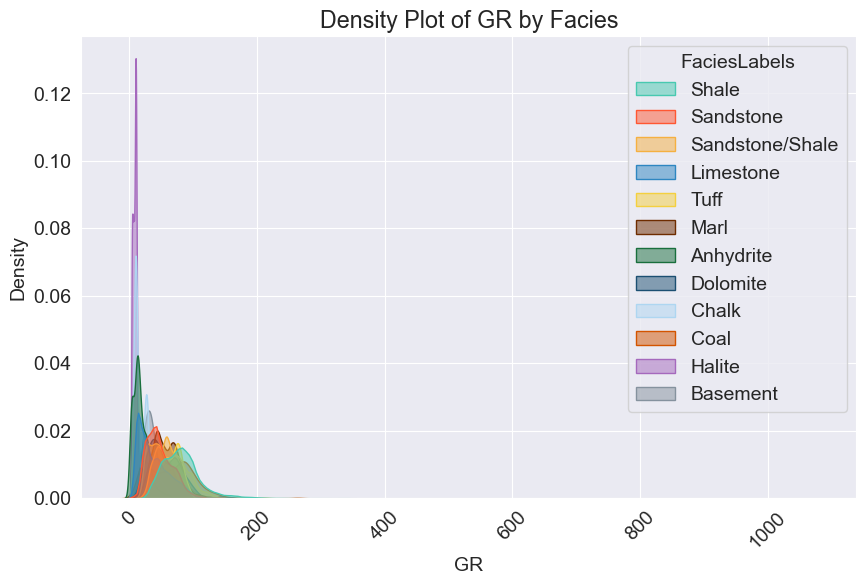

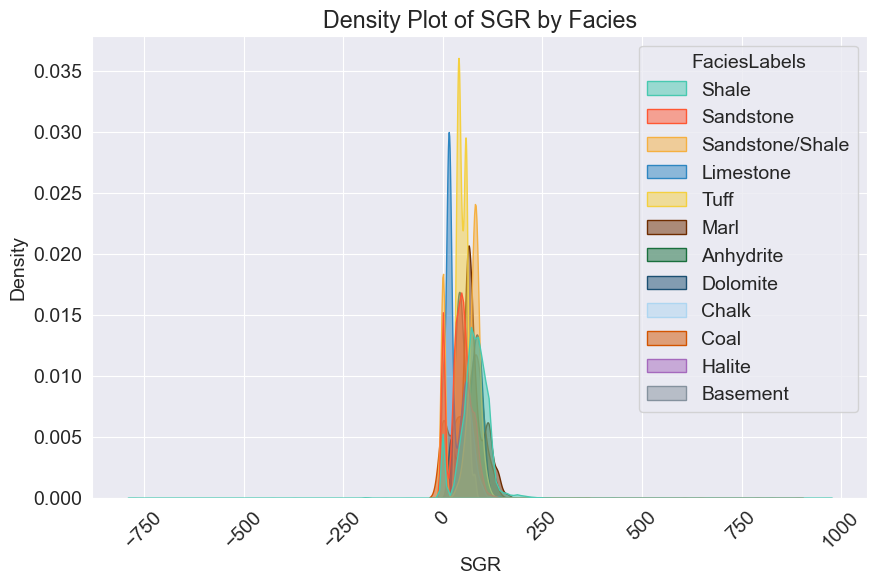

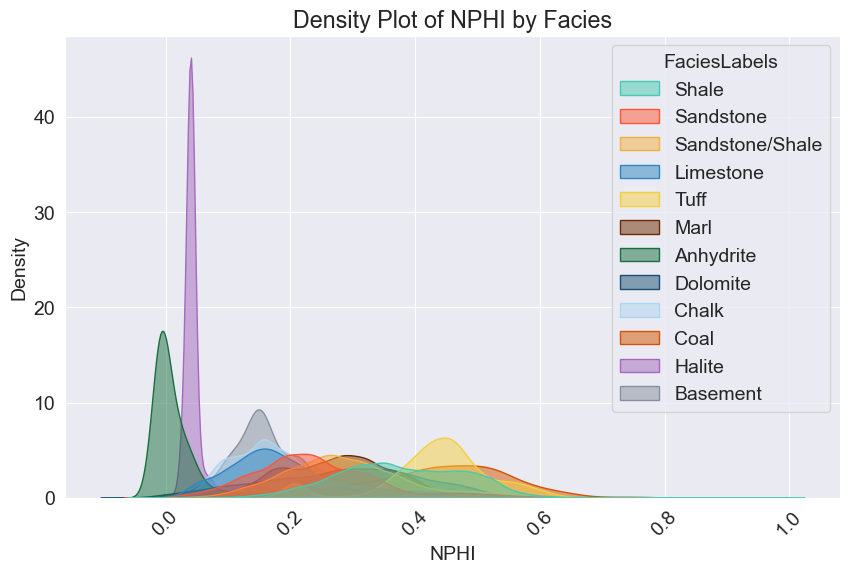

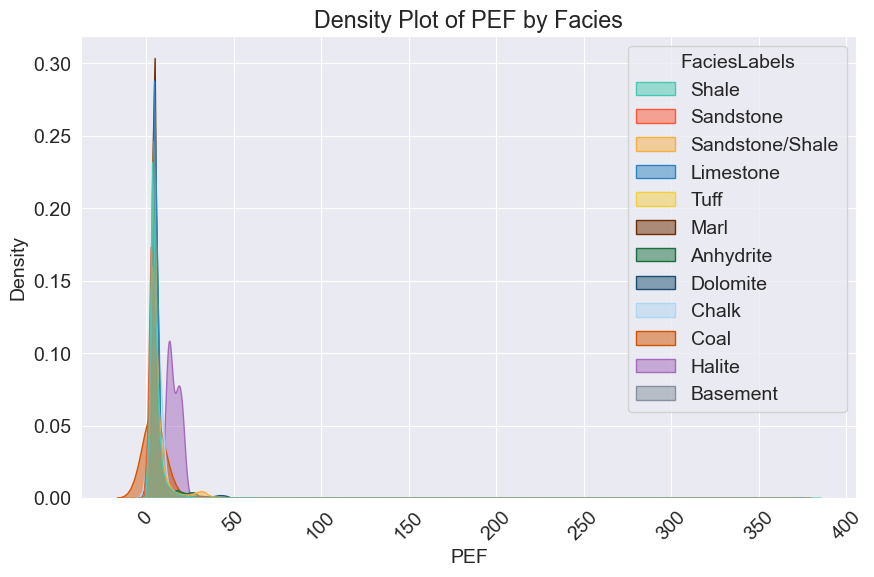

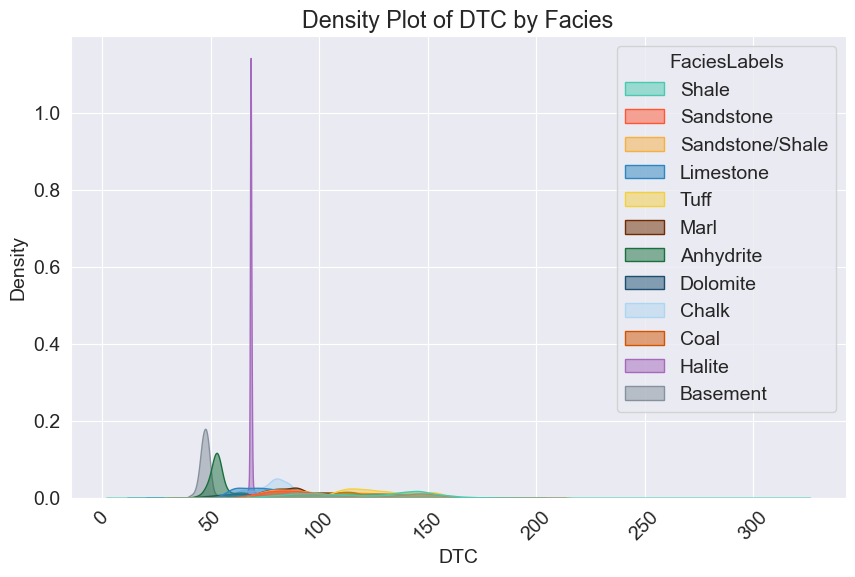

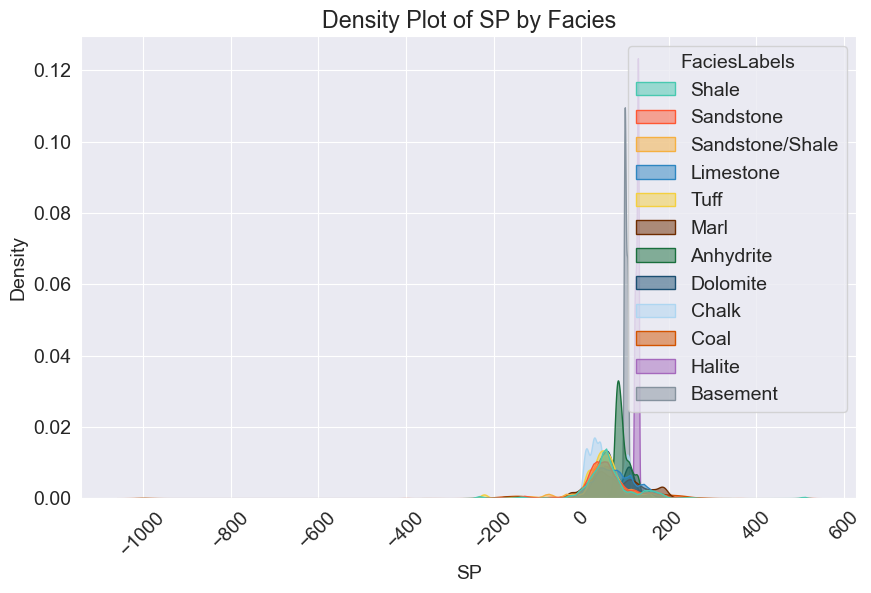

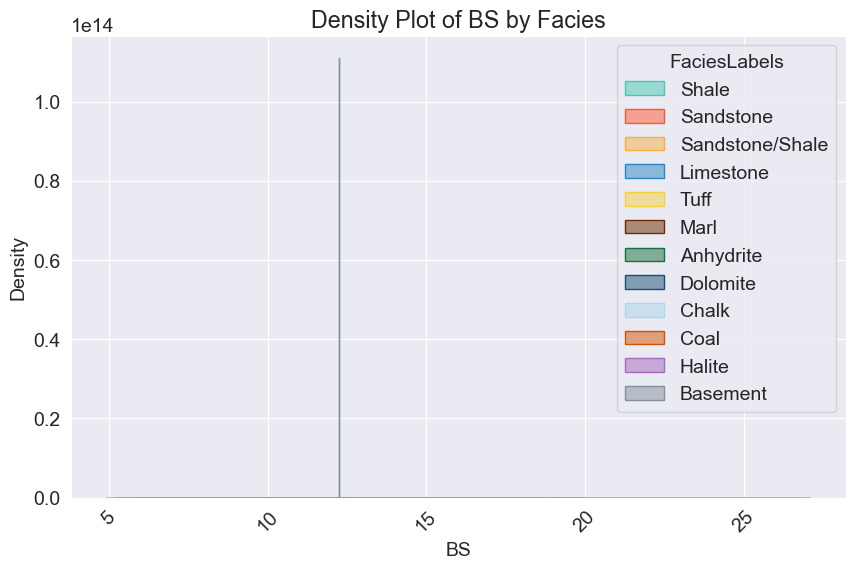

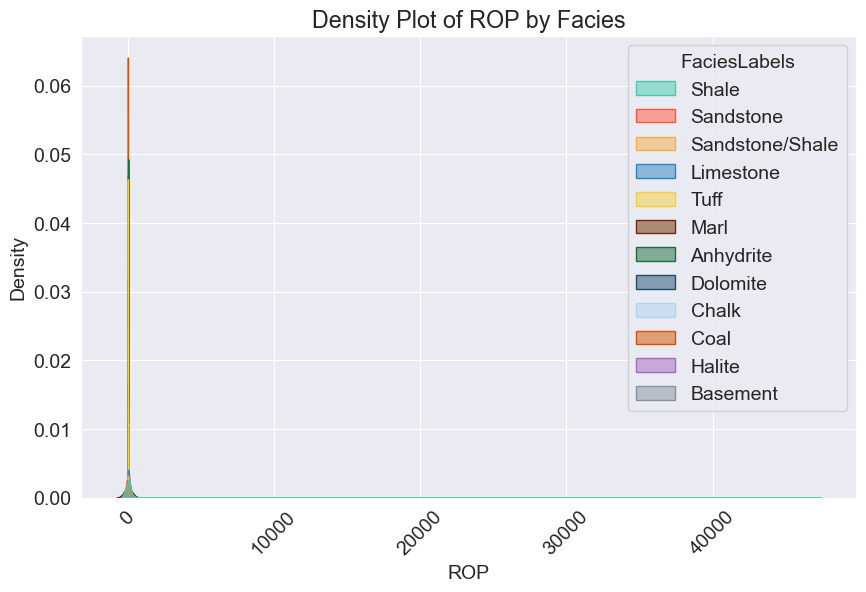

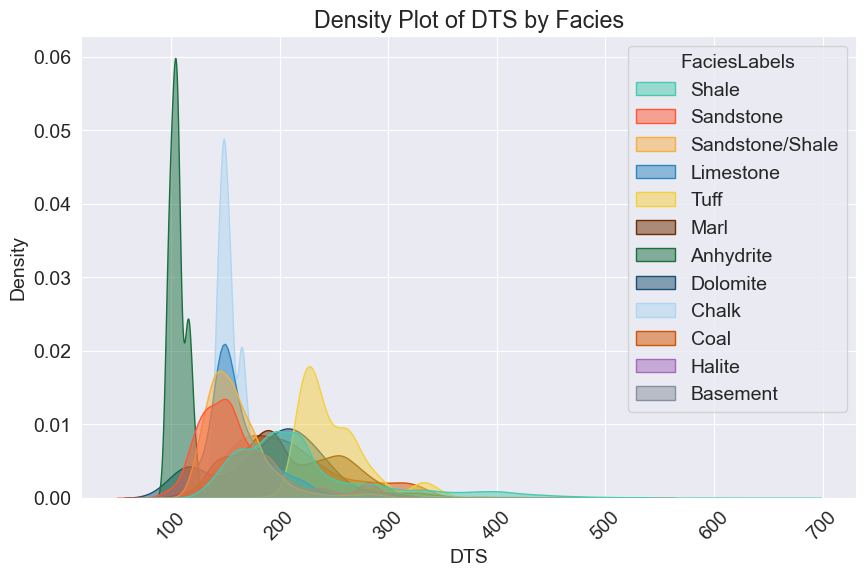

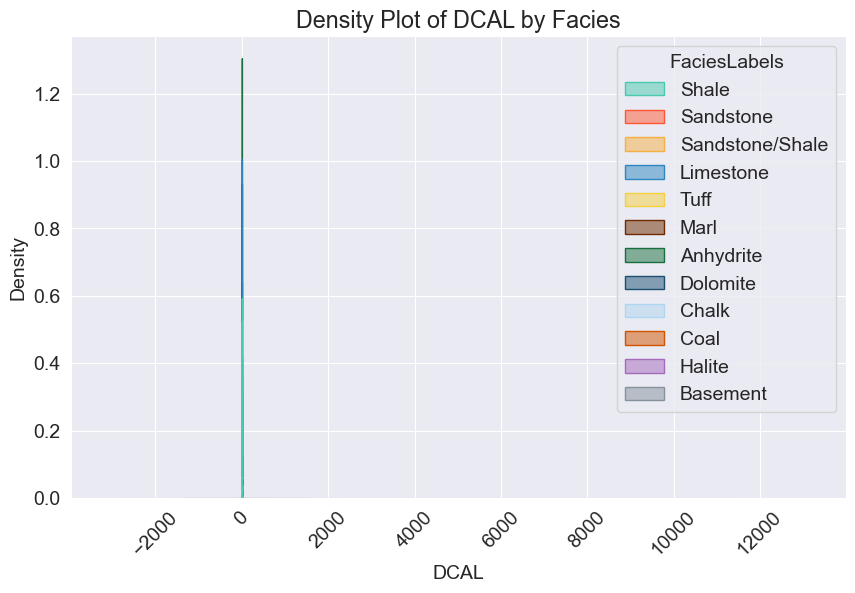

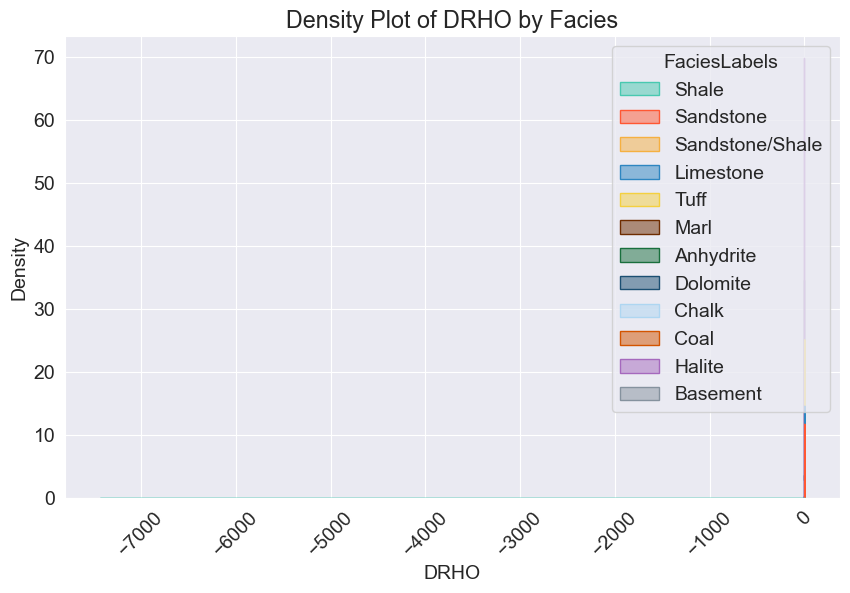

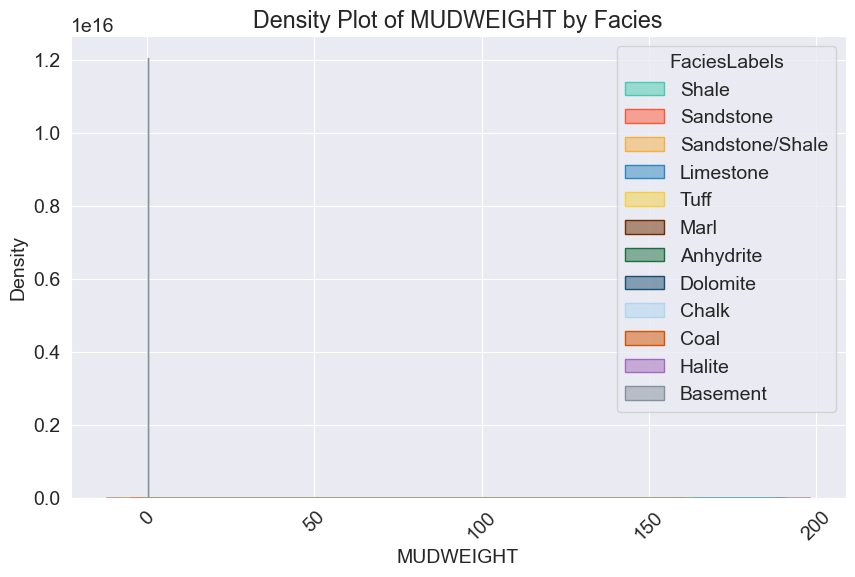

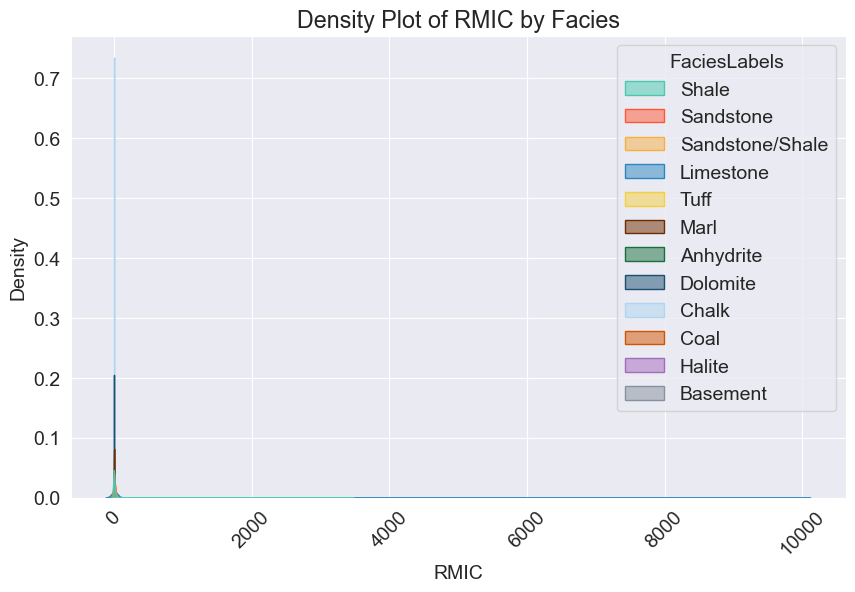

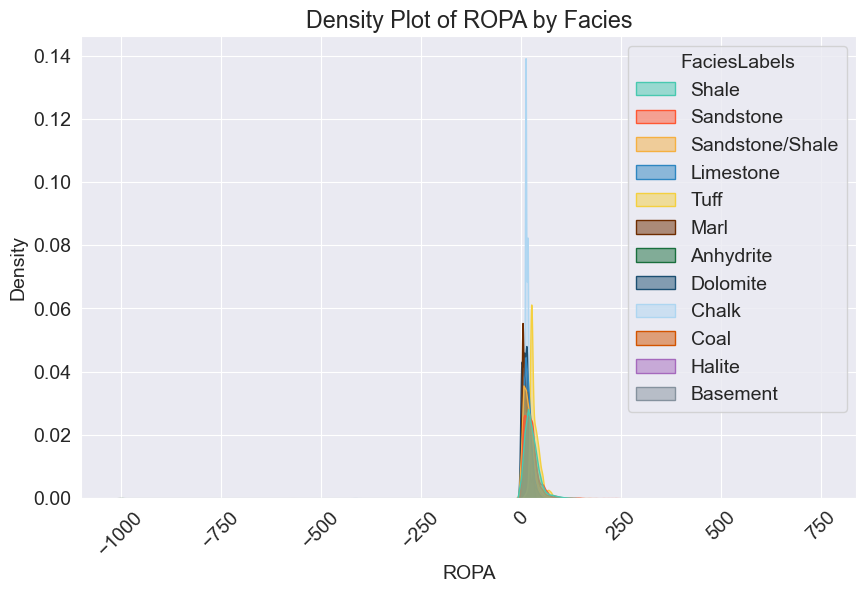

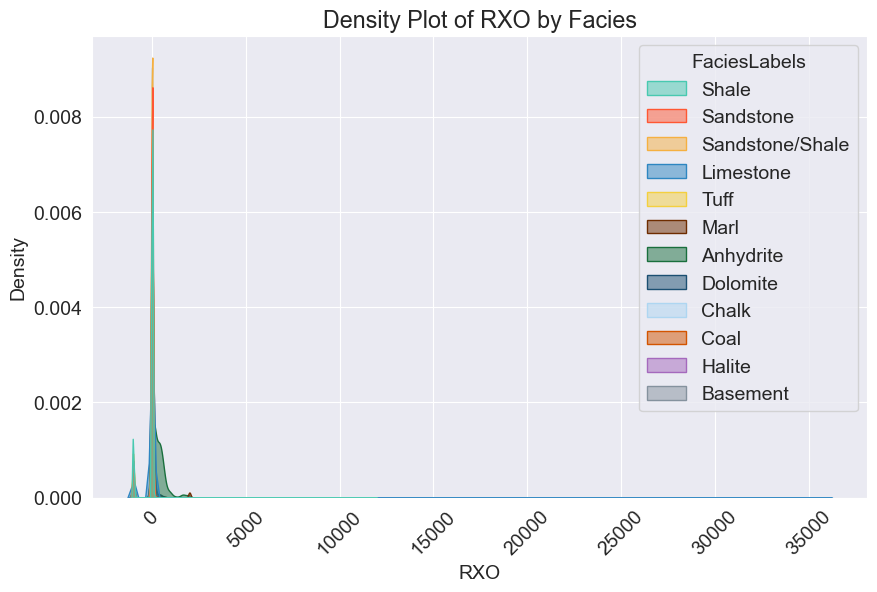

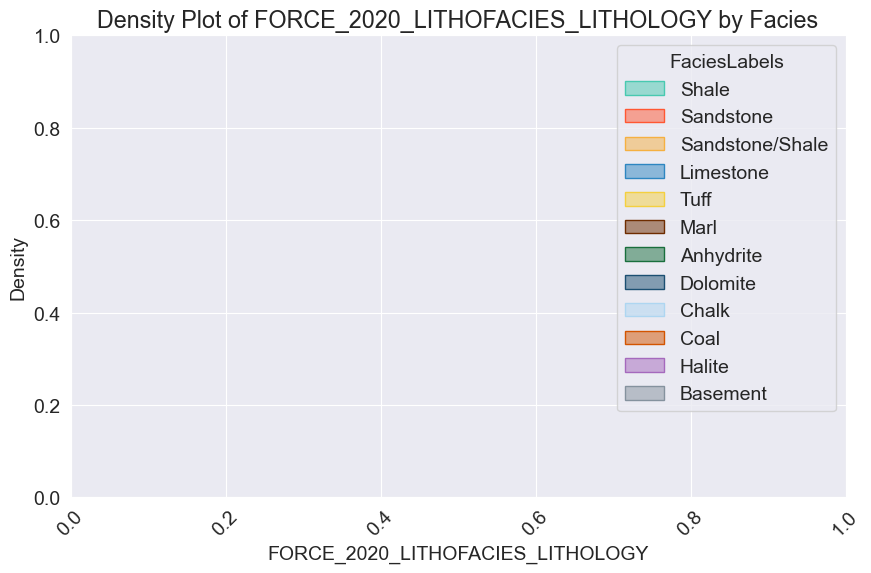

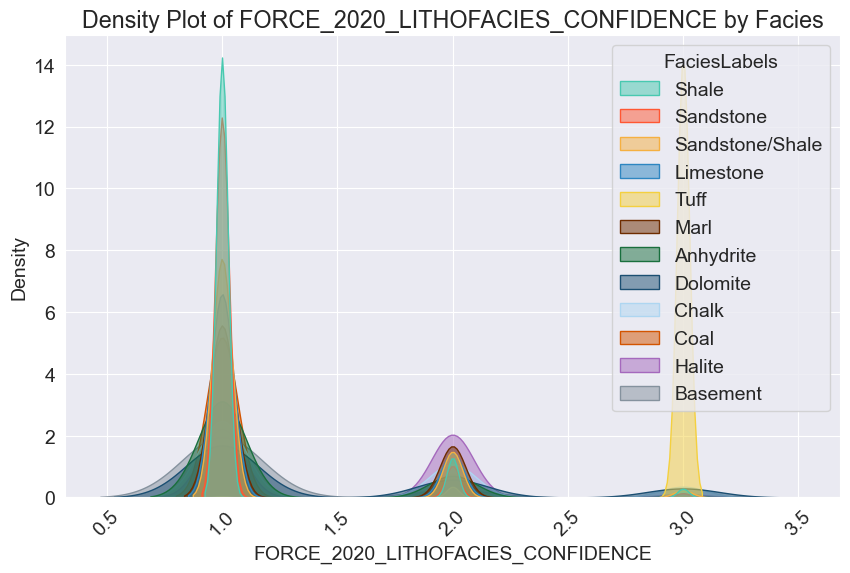

In [46]:
for col in numeric_columns[1:]:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x=col, hue='FaciesLabels', fill=True, common_norm=False, palette=facies_colors, alpha=0.5)
    plt.title(f'Density Plot of {col} by Facies')
    plt.xlabel(col)
    plt.ylabel('Density')
    #legend_labels = [facies_colors[color] for color in facies_colors.values()]
    # plt.legend(title='Facies', labels=legend_labels)
    #plt.legend(title='Facies')
    plt.xticks(rotation=45) 
    plt.show()

Подсчет количества уникальных и пропущенных значений

In [29]:
dftype = pd.DataFrame(df.dtypes, columns=['Data_Type'])
dftype['Number_Unique'] = df.nunique()
dftype['Nan_bool'] = df.isna().any()
dftype['Number_of_Nan'] = df.isna().sum()
dftype

Data_Type  Number_Unique  Nan_bool  \
WELL                                 object             98     False   
DEPTH_MD                            float64        1146418     False   
X_LOC                               float64         166525      True   
Y_LOC                               float64          17481      True   
Z_LOC                               float64        1128126      True   
GROUP                                object             14      True   
FORMATION                            object             69      True   
CALI                                float64         874208      True   
RSHA                                float64         619225      True   
RMED                                float64        1104594      True   
RDEP                                float64        1131288      True   
RHOB                                float64         874676      True   
GR                                  float64        1133878     False   
SGR                                 float64          68776      True   
NPHI                                float64         736868      True   
PEF                                 float64         657490      True   
DTC                                 float64        1027931      True   
SP                                  float64         832034      True   
BS                                  float64            152      True   
ROP                                 float64         447585      True   
DTS                                 float64         172930      True   
DCAL                                float64         264010      True   
DRHO                                float64         930870      True   
MUDWEIGHT                           float64            276      True   
RMIC                                float64         175417      True   
ROPA                                float64         184033      True   
RXO                                 float64         289703      True   
FORCE_2020_LITHOFACIES_LITHOLOGY      int64             12     False   
FORCE_2020_LITHOFACIES_CONFIDENCE   float64              3      True   
FaciesLabels                         object             12     False   

                                   Number_of_Nan  
WELL                                           0  
DEPTH_MD                                       0  
X_LOC                                      10775  
Y_LOC                                      10775  
Z_LOC                                      10775  
GROUP                                       1278  
FORMATION                                 136994  
CALI                                       87877  
RSHA                                      539861  
RMED                                       38993  
RDEP                                       11015  
RHOB                                      161269  
GR                                             0  
SGR                                      1101158  
NPHI                                      405102  
PEF                                       498819  
DTC                                        80863  
SP                                        306264  
BS                                        487854  
ROP                                       635440  
DTS                                       995898  
DCAL                                      871678  
DRHO                                      182654  
MUDWEIGHT                                 854360  
RMIC                                      994351  
ROPA                                      978186  
RXO                                       843084  
FORCE_2020_LITHOFACIES_LITHOLOGY               0  
FORCE_2020_LITHOFACIES_CONFIDENCE            179  
FaciesLabels                                   0

Замена пропущенных значений в численных колонках средним значением

In [16]:
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

In [17]:
df[numeric_columns].isna().sum()

DEPTH_MD                             0
X_LOC                                0
Y_LOC                                0
Z_LOC                                0
CALI                                 0
RSHA                                 0
RMED                                 0
RDEP                                 0
RHOB                                 0
GR                                   0
SGR                                  0
NPHI                                 0
PEF                                  0
DTC                                  0
SP                                   0
BS                                   0
ROP                                  0
DTS                                  0
DCAL                                 0
DRHO                                 0
MUDWEIGHT                            0
RMIC                                 0
ROPA                                 0
RXO                                  0
FORCE_2020_LITHOFACIES_LITHOLOGY     0
FORCE_2020_LITHOFACIES_CO

### 2.4 Нормализация данных

Выбор признаков, которые будут использоваться для классификации

In [18]:
features = ['RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS']

In [19]:
df[features].head()

RSHA      RMED      RDEP      RHOB         GR      NPHI        PEF  \
0  10.694664  1.611410  1.798681  1.884186  80.200851  0.331966  20.915468   
1  10.694664  1.618070  1.795641  1.889794  79.262886  0.331966  19.383013   
2  10.694664  1.626459  1.800733  1.896523  74.821999  0.331966  22.591518   
3  10.694664  1.621594  1.801517  1.891913  72.878922  0.331966  32.191910   
4  10.694664  1.602679  1.795299  1.880034  71.729141  0.331966  38.495632   

          DTC         BS        ROP         DTS  
0  161.131180  11.931432  34.636410  204.655019  
1  160.603470  11.931432  34.636410  204.655019  
2  160.173615  11.931432  34.779556  204.655019  
3  160.149429  11.931432  39.965164  204.655019  
4  160.128342  11.931432  57.483765  204.655019

In [20]:
scaler = MinMaxScaler().fit(df[features])

In [201]:
transformed_df = df

transformed_df[features] = scaler.transform(df[features])

In [202]:
transformed_df.describe()

DEPTH_MD         X_LOC         Y_LOC         Z_LOC          CALI  \
count  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   2.184087e+03  4.856310e+05  6.681276e+06 -2.138527e+03  1.318568e+01   
std    9.971821e+02  3.439699e+04  1.275612e+05  9.664633e+02  3.653522e+00   
min    1.360860e+02  4.268988e+05  6.406641e+06 -5.395563e+03  2.344000e+00   
25%    1.418597e+03  4.548019e+05  6.593126e+06 -2.804552e+03  9.882808e+00   
50%    2.076605e+03  4.777699e+05  6.732132e+06 -2.055283e+03  1.272100e+01   
75%    2.864393e+03  5.201314e+05  6.784877e+06 -1.397964e+03  1.574931e+01   
max    5.436632e+03  5.726328e+05  6.856661e+06 -1.110860e+02  2.827900e+01   

               RSHA          RMED          RDEP          RHOB            GR  \
count  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   2.176335e-06  5.496603e-06 -1.318621e-05 -5.462682e-02 -4.042625e-05   
std    1.534803e-05  1.359276e-05  2.835675e-05  3.139895e-02  2.951968e-05   
min   -4.558084e-08  4.233426e-06 -1.585143e-05 -2.634311e-01 -1.014848e-04   
25%    2.236978e-07  4.470473e-06 -1.563060e-05 -7.623841e-02 -6.050746e-05   
50%    2.113474e-06  4.612286e-06 -1.549685e-05 -5.462682e-02 -4.262187e-05   
75%    2.176335e-06  5.000695e-06 -1.520533e-05 -3.086406e-02 -2.479882e-05   
max    4.557628e-04  5.070935e-04  4.841847e-04  1.019526e-01  8.271457e-04   

       ...           ROP           DTS          DCAL          DRHO  \
count  ...  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   ...  2.571534e-06 -1.134976e-01  1.223849e+00  1.219638e-02   
std    ...  4.708550e-07  7.439700e-05  2.747313e+01  6.869624e+00   
min    ...  2.509335e-06 -1.138648e-01 -1.221546e+01 -7.429339e+03   
25%    ...  2.518713e-06 -1.134976e-01  1.223849e+00 -6.882701e-03   
50%    ...  2.571534e-06 -1.134976e-01  1.223849e+00  6.651836e-03   
75%    ...  2.571534e-06 -1.134976e-01  1.223849e+00  1.555134e-02   
max    ...  2.377903e-05 -1.122185e-01  1.001142e+04  2.836938e+00   

          MUDWEIGHT          RMIC          ROPA           RXO  \
count  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   1.216329e+00  7.796809e+00  2.350507e+01 -9.577950e+01   
std    5.291056e+00  3.481446e+01  9.174184e+00  1.845736e+02   
min    1.258177e-01  5.658556e-02 -9.992501e+02 -9.999000e+02   
25%    1.216329e+00  7.796809e+00  2.350507e+01 -9.577950e+01   
50%    1.216329e+00  7.796809e+00  2.350507e+01 -9.577950e+01   
75%    1.216329e+00  7.796809e+00  2.350507e+01  1.201068e-01   
max    1.857309e+02  1.000000e+04  7.427979e+02  3.593067e+04   

       FORCE_2020_LITHOFACIES_LITHOLOGY  FORCE_2020_LITHOFACIES_CONFIDENCE  
count                      1.170511e+06                       1.170511e+06  
mean                       6.138598e+04                       1.164258e+00  
std                        1.389170e+04                       4.450840e-01  
min                        3.000000e+04                       1.000000e+00  
25%                        6.500000e+04                       1.000000e+00  
50%                        6.500000e+04                       1.000000e+00  
75%                        6.500000e+04                       1.000000e+00  
max                        9.900000e+04                       3.000000e+00  

[8 rows x 26 columns]

In [38]:
transformed_df

WELL   DEPTH_MD         X_LOC         Y_LOC        Z_LOC  \
0        15/9-13   494.5280  437641.96875  6.470972e+06  -469.501831   
1        15/9-13   494.6800  437641.96875  6.470972e+06  -469.653809   
2        15/9-13   494.8320  437641.96875  6.470972e+06  -469.805786   
3        15/9-13   494.9840  437641.96875  6.470972e+06  -469.957794   
4        15/9-13   495.1360  437641.96875  6.470972e+06  -470.109772   
...          ...        ...           ...           ...          ...   
1170506  7/1-2 S  3169.3124  485631.03274  6.681276e+06 -2138.527143   
1170507  7/1-2 S  3169.4644  485631.03274  6.681276e+06 -2138.527143   
1170508  7/1-2 S  3169.6164  485631.03274  6.681276e+06 -2138.527143   
1170509  7/1-2 S  3169.7684  485631.03274  6.681276e+06 -2138.527143   
1170510  7/1-2 S  3169.9204  485631.03274  6.681276e+06 -2138.527143   

                GROUP  FORMATION       CALI      RSHA      RMED  ...  \
0        NORDLAND GP.        NaN  19.480835  0.004875  0.000815  ...   
1        NORDLAND GP.        NaN  19.468800  0.004875  0.000818  ...   
2        NORDLAND GP.        NaN  19.468800  0.004875  0.000822  ...   
3        NORDLAND GP.        NaN  19.459282  0.004875  0.000820  ...   
4        NORDLAND GP.        NaN  19.453100  0.004875  0.000810  ...   
...               ...        ...        ...       ...       ...  ...   
1170506  VESTLAND GP.  Bryne Fm.   8.423170  0.004875  0.002512  ...   
1170507  VESTLAND GP.  Bryne Fm.   8.379244  0.004875  0.002512  ...   
1170508  VESTLAND GP.  Bryne Fm.   8.350248  0.004875  0.002512  ...   
1170509  VESTLAND GP.  Bryne Fm.   8.313779  0.004875  0.002512  ...   
1170510  VESTLAND GP.  Bryne Fm.   8.294910  0.004875  0.002512  ...   

              DTS      DCAL      DRHO  MUDWEIGHT      RMIC       ROPA  \
0        0.223063  1.223849 -0.574928   1.216329  7.796809  23.505069   
1        0.223063  1.223849 -0.570188   1.216329  7.796809  23.505069   
2        0.223063  1.223849 -0.574245   1.216329  7.796809  23.505069   
3        0.223063  1.223849 -0.586315   1.216329  7.796809  23.505069   
4        0.223063  1.223849 -0.597914   1.216329  7.796809  23.505069   
...           ...       ...       ...        ...       ...        ...   
1170506  0.223063  1.223849 -0.001763   1.216329  7.796809  26.673708   
1170507  0.223063  1.223849 -0.007600   1.216329  7.796809  26.840818   
1170508  0.223063  1.223849 -0.018297   1.216329  7.796809  27.007942   
1170509  0.223063  1.223849 -0.011438   1.216329  7.796809  27.175179   
1170510  0.223063  1.223849 -0.011398   1.216329  7.796809  27.342442   

               RXO  FORCE_2020_LITHOFACIES_LITHOLOGY  \
0       -95.779496                             65000   
1       -95.779496                             65000   
2       -95.779496                             65000   
3       -95.779496                             65000   
4       -95.779496                             65000   
...            ...                               ...   
1170506 -95.779496                             30000   
1170507 -95.779496                             65030   
1170508 -95.779496                             65030   
1170509 -95.779496                             65030   
1170510 -95.779496                             65030   

         FORCE_2020_LITHOFACIES_CONFIDENCE     FaciesLabels  
0                                      1.0            Shale  
1                                      1.0            Shale  
2                                      1.0            Shale  
3                                      1.0            Shale  
4                                      1.0            Shale  
...                                    ...              ...  
1170506                                2.0        Sandstone  
1170507                                2.0  Sandstone/Shale  
1170508                                2.0  Sandstone/Shale  
1170509                                2.0  Sandstone/Shale  
1170510                                2.0  Sandst

In [203]:
#Сохранение в файл 
selected_columns = features + ['FaciesLabels', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'WELL', 'DEPTH_MD']

# Сохранение DataFrame в файл CSV
transformed_df[selected_columns].to_csv('../data/processed_data/transformed_data.csv', 
                                        index=False)

## 3. Подготовка данных

In [28]:
transformed_df = pd.read_csv('../data/processed_data/transformed_data.csv')

In [29]:
transformed_df

RSHA      RMED      RDEP      RHOB        GR      NPHI       PEF  \
0        0.004875  0.000815  0.000884  0.425020  0.074375  0.355216  0.054345   
1        0.004875  0.000818  0.000882  0.427069  0.073504  0.355216  0.050344   
2        0.004875  0.000822  0.000885  0.429527  0.069381  0.355216  0.058721   
3        0.004875  0.000820  0.000885  0.427843  0.067576  0.355216  0.083785   
4        0.004875  0.000810  0.000882  0.423503  0.066508  0.355216  0.100243   
...           ...       ...       ...       ...       ...       ...       ...   
1170506  0.004875  0.002512  0.005330  0.660253  0.072011  0.355216  0.011714   
1170507  0.004875  0.002512  0.005330  0.663771  0.069884  0.355216  0.018067   
1170508  0.004875  0.002512  0.005330  0.647054  0.061609  0.355216  0.023366   
1170509  0.004875  0.002512  0.005330  0.630860  0.051702  0.355216  0.022986   
1170510  0.004875  0.002512  0.005330  0.624713  0.044874  0.355216  0.023628   

              DTC        BS       ROP       DTS     FaciesLabels  \
0        0.491006  0.296572  0.000739  0.223063            Shale   
1        0.489320  0.296572  0.000739  0.223063            Shale   
2        0.487947  0.296572  0.000742  0.223063            Shale   
3        0.487870  0.296572  0.000853  0.223063            Shale   
4        0.487802  0.296572  0.001225  0.223063            Shale   
...           ...       ...       ...       ...              ...   
1170506  0.338407  0.125000  0.000591  0.223063        Sandstone   
1170507  0.338407  0.125000  0.000599  0.223063  Sandstone/Shale   
1170508  0.338407  0.125000  0.000600  0.223063  Sandstone/Shale   
1170509  0.338407  0.125000  0.000598  0.223063  Sandstone/Shale   
1170510  0.338407  0.125000  0.000555  0.223063  Sandstone/Shale   

         FORCE_2020_LITHOFACIES_LITHOLOGY     WELL  
0                                   65000  15/9-13  
1                                   65000  15/9-13  
2                                   65000  15/9-13  
3                                   65000  15/9-13  
4                                   65000  15/9-13  
...                                   ...      ...  
1170506                             30000  7/1-2 S  
1170507                             65030  7/1-2 S  
1170508                             65030  7/1-2 S  
1170509                             65030  7/1-2 S  
1170510                             65030  7/1-2 S  

[1170511 rows x 14 columns]

In [97]:
transformed_df = transformed_df[transformed_df['FaciesLabels'] != 'Basement']

transformed_df['WELL'].value_counts().head()

25/2-7     25131
29/6-1     24464
25/7-2     23879
35/11-6    23544
34/2-4     23403
Name: WELL, dtype: int64

#### 3.1 Выбор валидационной части

In [98]:
transformed_df['WELL'].unique()

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

Возьмем 10 последних скважин для валидации

In [99]:
all_wells = transformed_df['WELL'].unique().tolist()
validation_wells = all_wells[:10]

# Определяем тренировочные скважины, исключая скважины из валидационного набора
training_wells = [well for well in all_wells if well not in validation_wells]

In [100]:
print("Скважины из валидационного набора:", validation_wells)

print("Скважины из тренировочного набора:", training_wells)

Скважины из валидационного набора: ['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1', '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3']
Скважины из тренировочного набора: ['16/2-11 A', '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5', '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5', '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1', '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S', '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S', '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9', '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5', '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S', '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33', '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4', '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13', '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1', '35/11-10', '35/11-11', '35/11-12', '35/11-13', '35/11-15 S', '35/

In [101]:
# Выбираем строки для валидационного набора
validation_data = transformed_df[transformed_df['WELL'].isin(validation_wells)]

In [102]:
validation_data['WELL'].value_counts()

15/9-13        18270
15/9-15        17717
16/10-1        17675
15/9-17        17350
16/10-3        15956
16/11-1 ST3    14938
16/1-6 A        3623
16/10-5         2765
16/10-2         2437
16/1-2          1734
Name: WELL, dtype: int64

#### 3.2 Выбор тренировочной части

In [103]:
# Выбираем строки для тренировочного набора
training_data = transformed_df[~transformed_df['WELL'].isin(validation_wells)]

In [104]:
training_data.head()

RSHA      RMED      RDEP      RHOB        GR      NPHI       PEF  \
112465  0.004875  0.000712  0.000721  0.571466  0.110399  0.355216  0.016239   
112466  0.004875  0.000706  0.000716  0.571466  0.115526  0.355216  0.016239   
112467  0.004875  0.000697  0.000702  0.571466  0.117630  0.355216  0.016239   
112468  0.004875  0.000693  0.000694  0.571466  0.118007  0.355216  0.016239   
112469  0.004875  0.000695  0.000698  0.571466  0.116149  0.355216  0.016239   

             DTC       BS       ROP       DTS FaciesLabels  \
112465  0.469520  0.19375  0.000575  0.223063        Shale   
112466  0.471340  0.19375  0.000558  0.223063        Shale   
112467  0.473858  0.19375  0.000587  0.223063        Shale   
112468  0.475216  0.19375  0.000613  0.223063        Shale   
112469  0.477934  0.19375  0.000619  0.223063        Shale   

        FORCE_2020_LITHOFACIES_LITHOLOGY       WELL  
112465                             65000  16/2-11 A  
112466                             65000  16/2-11 A  
112467                             65000  16/2-11 A  
112468                             65000  16/2-11 A  
112469                             65000  16/2-11 A

In [105]:
training_data.shape, validation_data.shape

((1057943, 14), (112465, 14))

### 3.3 Разбиение на признаки и целевую переменную обеих частей

#### 3.3.1 Тенировочная часть

In [106]:
y_train = training_data['FaciesLabels']
X_train = training_data[features]

In [107]:
y_train.shape[0], X_train.shape 

(1057943, (1057943, 11))

#### 3.3.2 Валидационная часть

In [108]:
y_val = validation_data['FaciesLabels']
X_val = validation_data[features]

In [109]:
y_val.shape[0], X_val.shape

(112465, (112465, 11))

### 3.4 Определение функций для визуализации 

In [417]:
#Формирование датеферйма для визуализации классификации из тестовых данных
results_df = transformed_df[transformed_df['WELL'].isin(validation_wells)]

lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

lithology_keys = {'Sandstone' : 30000,
                 'Sandstone/Shale' : 65030,
                 'Shale' : 65000,
                 'Marl' : 80000,
                 'Dolomite' : 74000,
                 'Limestone' : 70000,
                 'Chalk' : 70032,
                 'Halite' : 88000,
                 'Anhydrite' : 86000,
                 'Tuff' : 99000,
                 'Coal' : 90000,
                 'Basement' : 93000}

results_df['Facies'] = results_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)
results_df['Depth'] = results_df['DEPTH_MD']

selected_logs = ['CALI', 'GR', 'RHOB', 'NPHI', 'RDEP', 'PEF']

facies_names = lithology_keys.values()

facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']

In [412]:
def log_plot(dataframe, logs, well_name, predicted_col):
        
    # Убедимся, что логи отсортированы по глубине
    facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']
    
    cmap_facies = ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']

    ztop=dataframe['Depth'].min(); zbot=dataframe['Depth'].max()
    
    cluster1 = np.repeat(np.expand_dims(dataframe['Facies'].values, 1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(dataframe[predicted_col].values, 1), 100, 1)
    num_curves = len(logs)
    
    # Определяем фигуру и оси
    f, ax = plt.subplots(nrows=1, ncols=num_curves+2, figsize=(16, 16))
    
    # Рисуем логи
    for ic, col in enumerate(logs):
        if np.all(np.isnan(dataframe[col])):
            log = np.empty(dataframe[col].values.shape)
            log[:] = np.nan
            
        else:
            log = dataframe[col]
            
        ax[ic].plot(log, dataframe['Depth'], colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([])

    # Рисуем cluster1
    im1 = ax[num_curves].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies, vmin=0, vmax=len(facies_colors) - 1)
    
    # Рисуем cluster2
    im2 = ax[num_curves + 1].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies, vmin=0, vmax=len(facies_colors) - 1)

    # Добавляем цветовую шкалу для cluster2
    divider = make_axes_locatable(ax[num_curves + 1])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_label((12*' ').join(['SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', 'Chlk ', 
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1))
    cbar.set_ticklabels('')
    
    # Настройка других параметров графика
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid(False)
        ax[i].locator_params(axis='x', nbins=2)
        ax[i].set_xticks([])

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Facies')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    ax[num_curves + 1].set_xlabel('Predicted')
    ax[num_curves + 1].set_yticklabels([])
    ax[num_curves + 1].set_xticklabels([])
    
    f.subplots_adjust(wspace=0.1) 
    f.suptitle('Well: %s'% well_name, fontsize=20, y=0.9)


In [422]:
def compare_facies(dataframe, well_name, predicted_col):
    
    facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']
    
    cmap_facies = ListedColormap(facies_colors, 'indexed')
    ztop=dataframe['Depth'].min(); zbot=dataframe['Depth'].max()
    
    cluster1 = np.repeat(np.expand_dims(dataframe['Facies'].values, 1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(dataframe[predicted_col].values, 1), 100, 1)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 10))
    
    im1 = ax[0].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies, vmin=0, vmax=len(facies_colors) - 1)
    
    im2 = ax[1].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies, vmin=0, vmax=len(facies_colors) - 1)

    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_label((5*' ').join(['SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', ' Chlk ', 
                                '  Hal', 'Anhy', ' Tuf', '  Coal ', 'Bsmt']))
    cbar.set_ticks(range(0,1)); 
    cbar.set_ticklabels('')
    ax[0].set_ylabel("DEPTH")
    ax[0].set_xlabel('Facies')
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[1].set_xlabel('Predicted Facies')
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[0].grid(False)
    ax[1].grid(False)
    
    f.subplots_adjust(wspace=0.1)
    f.suptitle('Well: %s'% well_name, fontsize=12, x = 0.5, y = 0.9)

## 4. Обучение моделей

### 4.1 Логистическая регрессия

In [ ]:
%%time
model_logreg = LogisticRegression()

logreg_params = {
    'penalty': ['l1', 'l2'],  # тип регуляризации
    'C': [0.001, 0.01, 0.1, 1, 10],  # параметр регуляризации
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']  # алгоритм оптимизации
}

rs_logreg = RandomizedSearchCV(estimator=model_logreg, param_distributions=logreg_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)

rs_logreg.fit(X_train, y_train)

In [ ]:
rs_logreg.best_params_

Обучение модели логистической регресии

In [110]:
model_logreg = LogisticRegression(solver = 'liblinear')

In [111]:
%%time
model_logreg.fit(X_train, y_train)

Wall time: 37.5 s


LogisticRegression(solver='liblinear')

Получение предсказаний

In [112]:
LR_train_preds = model_logreg.predict(X_train)
print(LR_train_preds)

['Shale' 'Shale' 'Shale' ... 'Shale' 'Shale' 'Shale']


Вероятности, с которой модель отнесла первый элемент из тренировочного набора к каждому из классов

In [113]:
LR_probs = model_logreg.predict_proba(X_train)[39393]
LR_classes = model_logreg.classes_

for class_, prob in zip(LR_classes, LR_probs):
    print(f"Class '{class_}': Probability {prob:.4f}")

Class 'Anhydrite': Probability 0.0000
Class 'Chalk': Probability 0.0353
Class 'Coal': Probability 0.0022
Class 'Dolomite': Probability 0.0016
Class 'Halite': Probability 0.0004
Class 'Limestone': Probability 0.1031
Class 'Marl': Probability 0.0259
Class 'Sandstone': Probability 0.5449
Class 'Sandstone/Shale': Probability 0.1837
Class 'Shale': Probability 0.0850
Class 'Tuff': Probability 0.0179


Точность на тренировочной и тестовой выборках

In [114]:
LR_train_accuracy = accuracy_score(y_train, LR_train_preds)
print(f"Accuracy на тренировочной выборке: {LR_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 0.691


In [115]:
LR_val_preds = model_logreg.predict(X_val)

In [116]:
LR_val_accuracy = accuracy_score(y_val, LR_val_preds)
print(f"Accuracy на валидационной выборке: {LR_val_accuracy:.3f}")

Accuracy на валидационной выборке: 0.700


Отчет о классификации на валидационной выборке

In [117]:
print(classification_report(y_val, LR_val_preds, digits = 3))

                 precision    recall  f1-score   support

      Anhydrite      1.000     0.515     0.680       299
          Chalk      0.000     0.000     0.000      5129
           Coal      0.188     0.259     0.217        58
       Dolomite      0.000     0.000     0.000       188
         Halite      0.000     0.000     0.000      4314
      Limestone      0.512     0.042     0.077      8839
           Marl      0.000     0.000     0.000      2702
      Sandstone      0.277     0.605     0.380     12675
Sandstone/Shale      0.077     0.004     0.007      5737
          Shale      0.845     0.989     0.911     71343
           Tuff      0.000     0.000     0.000      1181

       accuracy                          0.700    112465
      macro avg      0.263     0.219     0.207    112465
   weighted avg      0.614     0.700     0.629    112465



Вывод матрицы ошибок

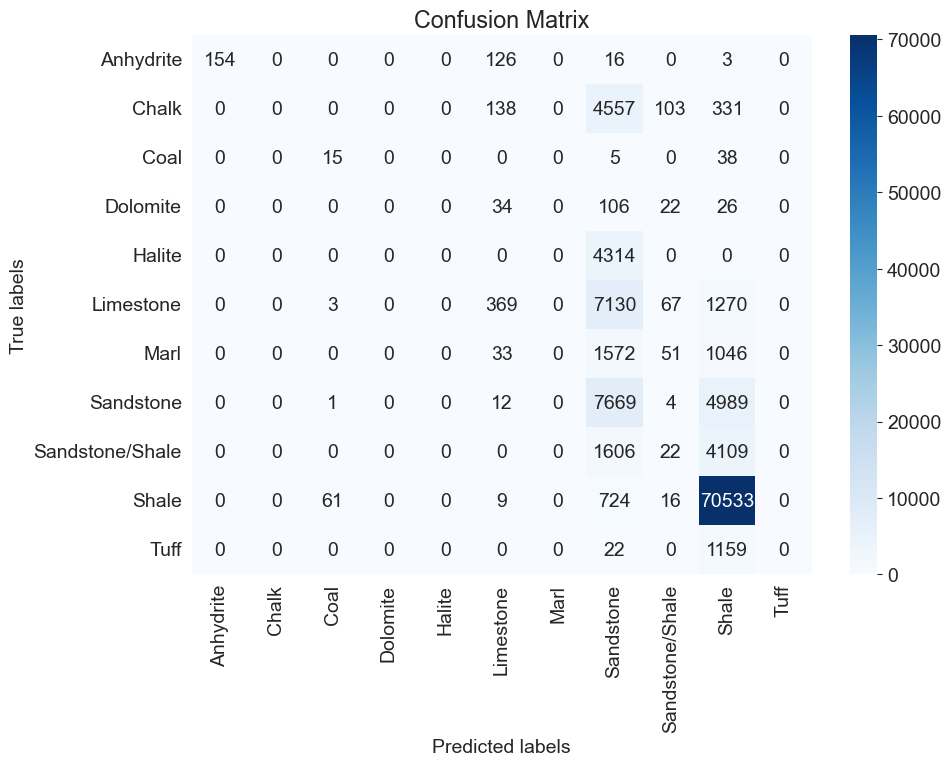

In [119]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_val, LR_val_preds)

conf_df = pd.DataFrame(conf_matrix, index = model_logreg.classes_, columns = model_logreg.classes_)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Визуализация результатов классификации

In [419]:
results_df['LR_predictions'] = model_logreg.predict(X_val)
results_df['LR_predictions'] = results_df['LR_predictions'].map(lithology_keys).map(lithology_numbers)

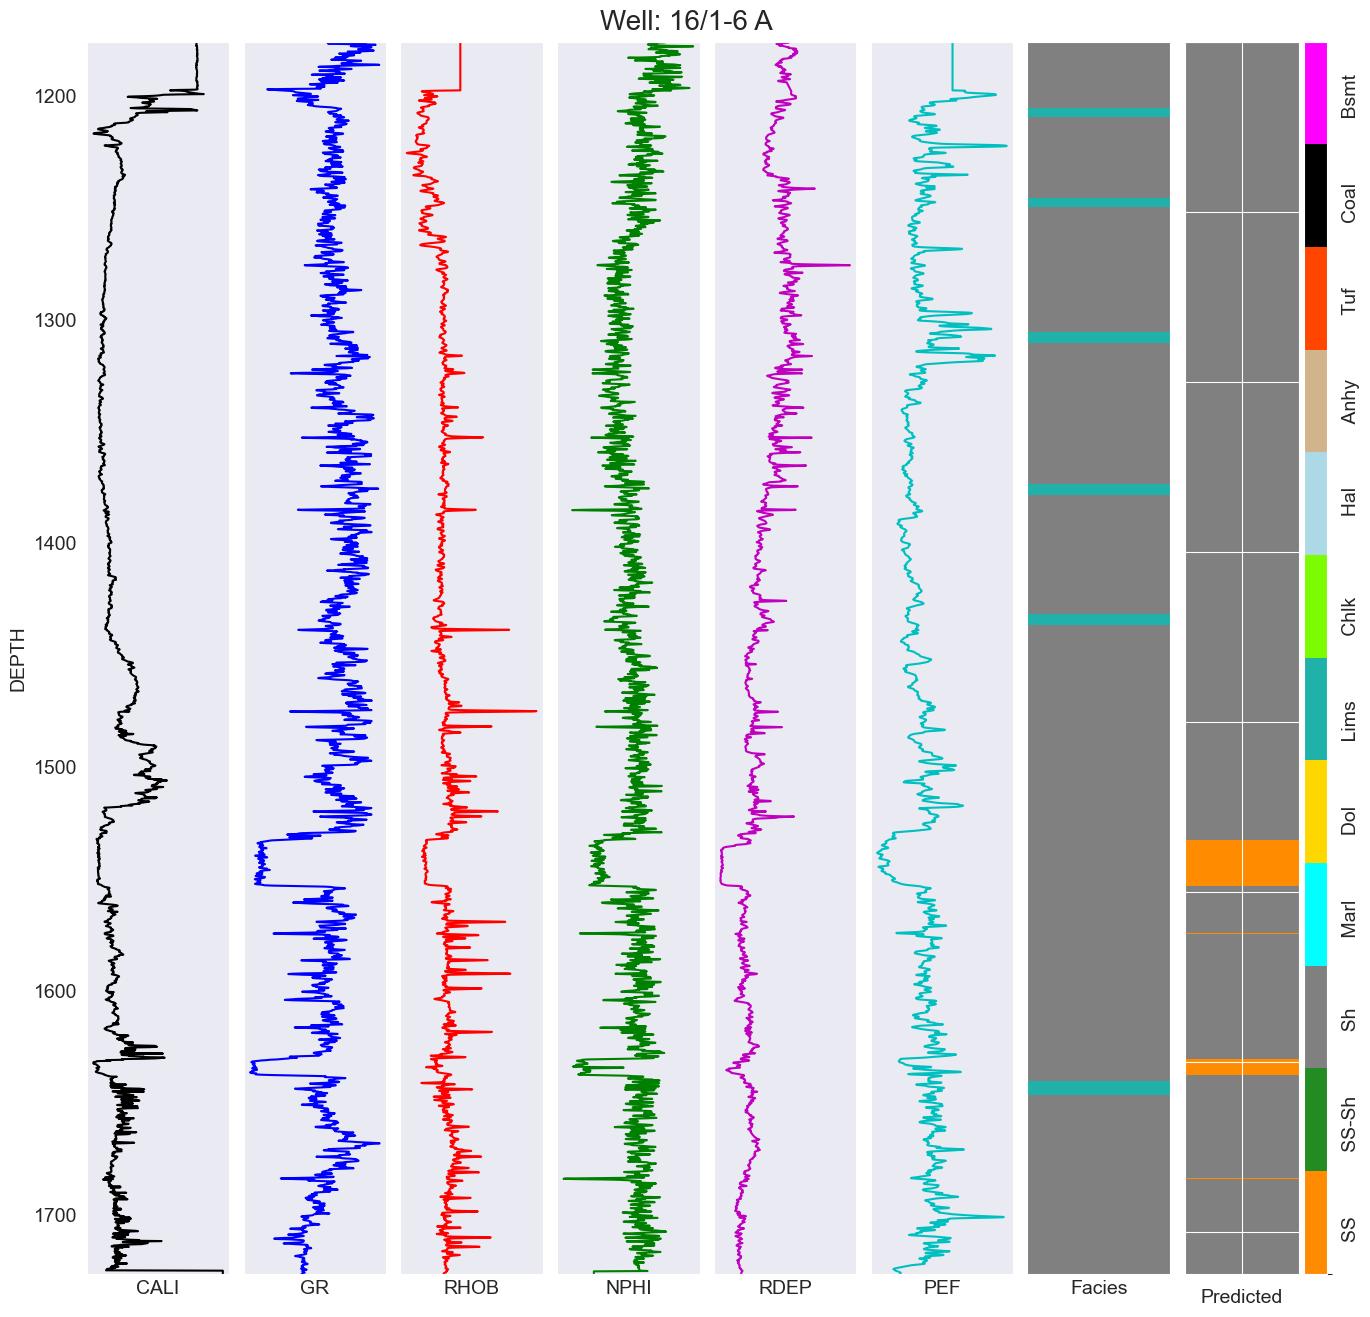

In [420]:
well_no = 4
log_plot(results_df[results_df['WELL'] == validation_wells[well_no]], selected_logs, validation_wells[well_no], 'LR_predictions')

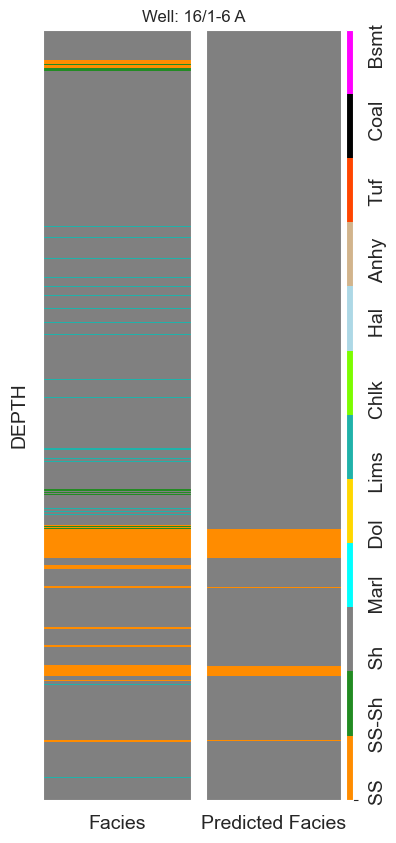

In [423]:
compare_facies(results_df[results_df['WELL'] == validation_wells[well_no]], validation_wells[well_no], 'LR_predictions')


### 4.2 Решающее дерево

In [120]:
model_tree = DecisionTreeClassifier(random_state=42)

Обучение решающего дерева

In [121]:
%%time
model_tree.fit(X_train, y_train)

Wall time: 26.8 s


DecisionTreeClassifier(random_state=42)

Точность на тренировочной и тестовой выборках

In [122]:
DTC_train_preds = model_tree.predict(X_train)

In [123]:
DTC_train_accuracy = accuracy_score(DTC_train_preds, y_train)
print(f"Accuracy на тренировочной выборке: {DTC_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 1.000


In [124]:
DTC_train_probs = model_tree.predict_proba(X_train)

In [125]:
DTC_train_probs

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [129]:
DTC_val_preds = model_tree.predict(X_val)

In [130]:
DTC_val_accuracy = accuracy_score(y_val, DTC_val_preds)
print(f"Accuracy на валидационной выборке: {DTC_val_accuracy:.3f}")

Accuracy на валидационной выборке: 0.544


In [131]:
print(classification_report(y_val, DTC_val_preds))

                 precision    recall  f1-score   support

      Anhydrite       0.12      0.05      0.07       299
          Chalk       0.32      0.06      0.11      5129
           Coal       0.12      0.48      0.19        58
       Dolomite       0.00      0.02      0.01       188
         Halite       0.00      0.00      0.00      4314
      Limestone       0.35      0.37      0.36      8839
           Marl       0.08      0.06      0.07      2702
      Sandstone       0.26      0.45      0.33     12675
Sandstone/Shale       0.08      0.15      0.11      5737
          Shale       0.81      0.71      0.76     71343
           Tuff       0.05      0.17      0.08      1181

       accuracy                           0.54    112465
      macro avg       0.20      0.23      0.19    112465
   weighted avg       0.59      0.54      0.56    112465



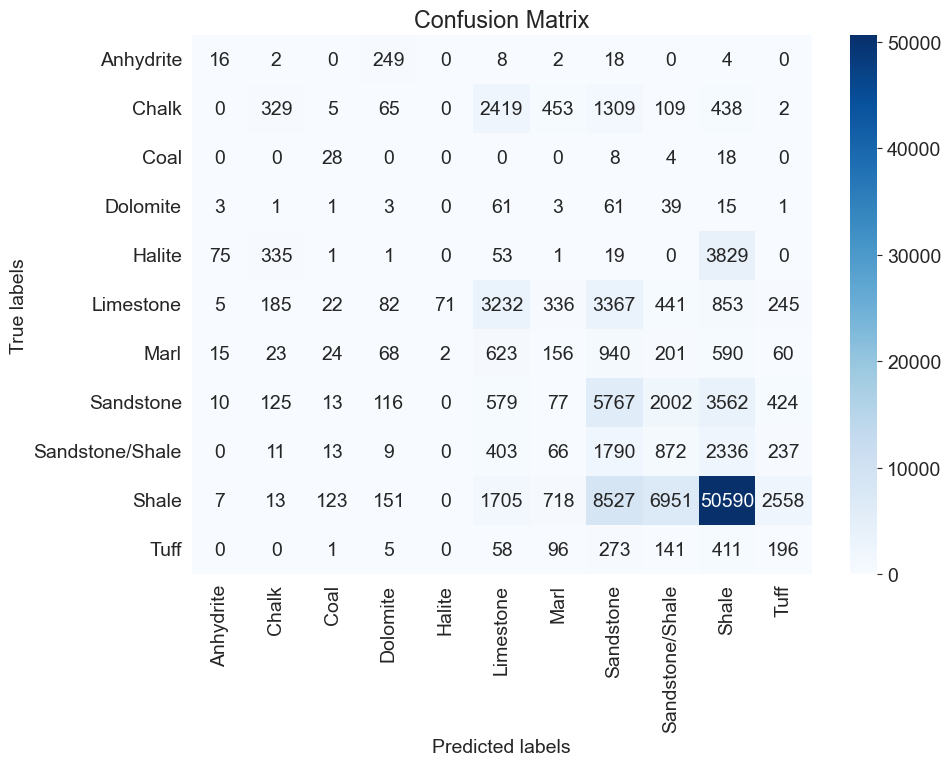

In [132]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_val, DTC_val_preds)

conf_df = pd.DataFrame(conf_matrix, index = model_tree.classes_, columns = model_tree.classes_)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Ограничим глубину дерева

In [133]:
model_tree2 = DecisionTreeClassifier(max_depth=8, random_state=42)

In [134]:
%%time
model_tree2.fit(X_train, y_train)

Wall time: 9.8 s


DecisionTreeClassifier(max_depth=8, random_state=42)

Точность на тренировочной и тестовой выборках

In [135]:
DTC2_train_preds = model_tree2.predict(X_train)
DTC2_train_accuracy = accuracy_score(DTC2_train_preds, y_train)
print(f"Accuracy на тренировочной выборке: {DTC2_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 0.749


In [136]:
DTC2_val_preds = model_tree2.predict(X_val)

In [137]:
DTC2_val_preds

array(['Shale', 'Shale', 'Shale', ..., 'Limestone', 'Limestone',
       'Limestone'], dtype=object)

In [138]:
DTC2_val_accuracy = accuracy_score(y_val, DTC2_val_preds)
print(f"Accuracy на валидационной выборке: {DTC2_val_accuracy:.3f}")

Accuracy на валидационной выборке: 0.712


Отчет о классификации на валидационной выборке

In [139]:
print(classification_report(y_val, DTC2_val_preds))

                 precision    recall  f1-score   support

      Anhydrite       0.46      0.86      0.60       299
          Chalk       0.51      0.05      0.09      5129
           Coal       0.71      0.29      0.41        58
       Dolomite       0.00      0.00      0.00       188
         Halite       0.00      0.00      0.00      4314
      Limestone       0.30      0.39      0.34      8839
           Marl       0.08      0.04      0.05      2702
      Sandstone       0.41      0.55      0.47     12675
Sandstone/Shale       0.24      0.09      0.13      5737
          Shale       0.86      0.96      0.91     71343
           Tuff       0.46      0.01      0.03      1181

       accuracy                           0.71    112465
      macro avg       0.37      0.30      0.28    112465
   weighted avg       0.66      0.71      0.67    112465



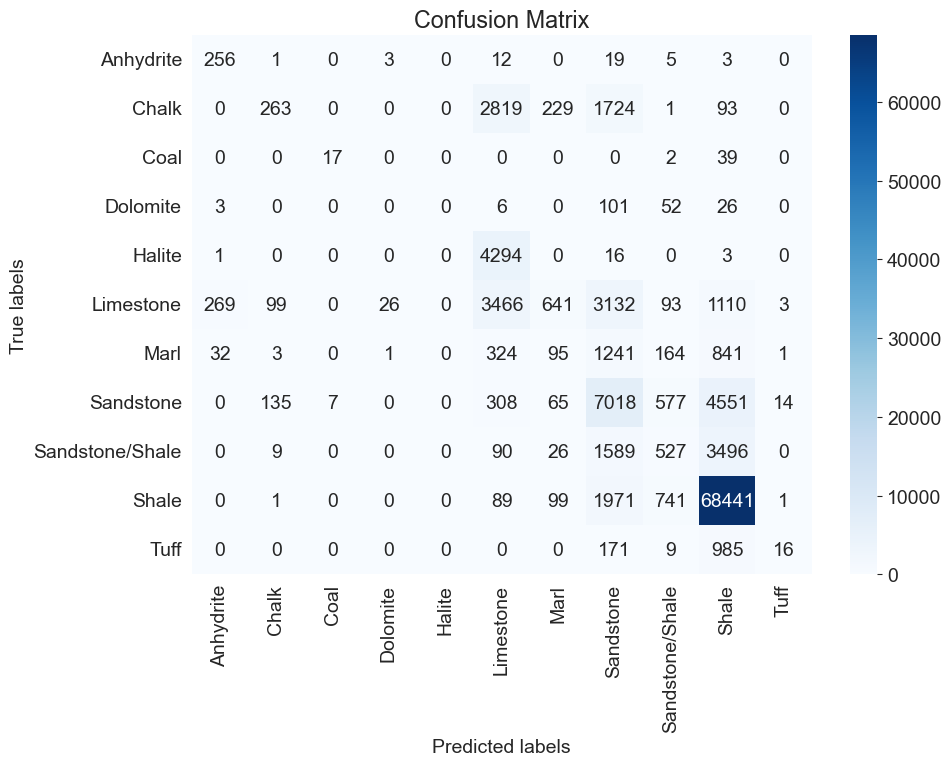

In [140]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_val, DTC2_val_preds)

conf_df = pd.DataFrame(conf_matrix, index = model_tree2.classes_, columns = model_tree2.classes_)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [421]:
results_df['DT_predictions'] = model_tree2.predict(X_val)
results_df['DT_predictions'] = results_df['DT_predictions'].map(lithology_keys).map(lithology_numbers)

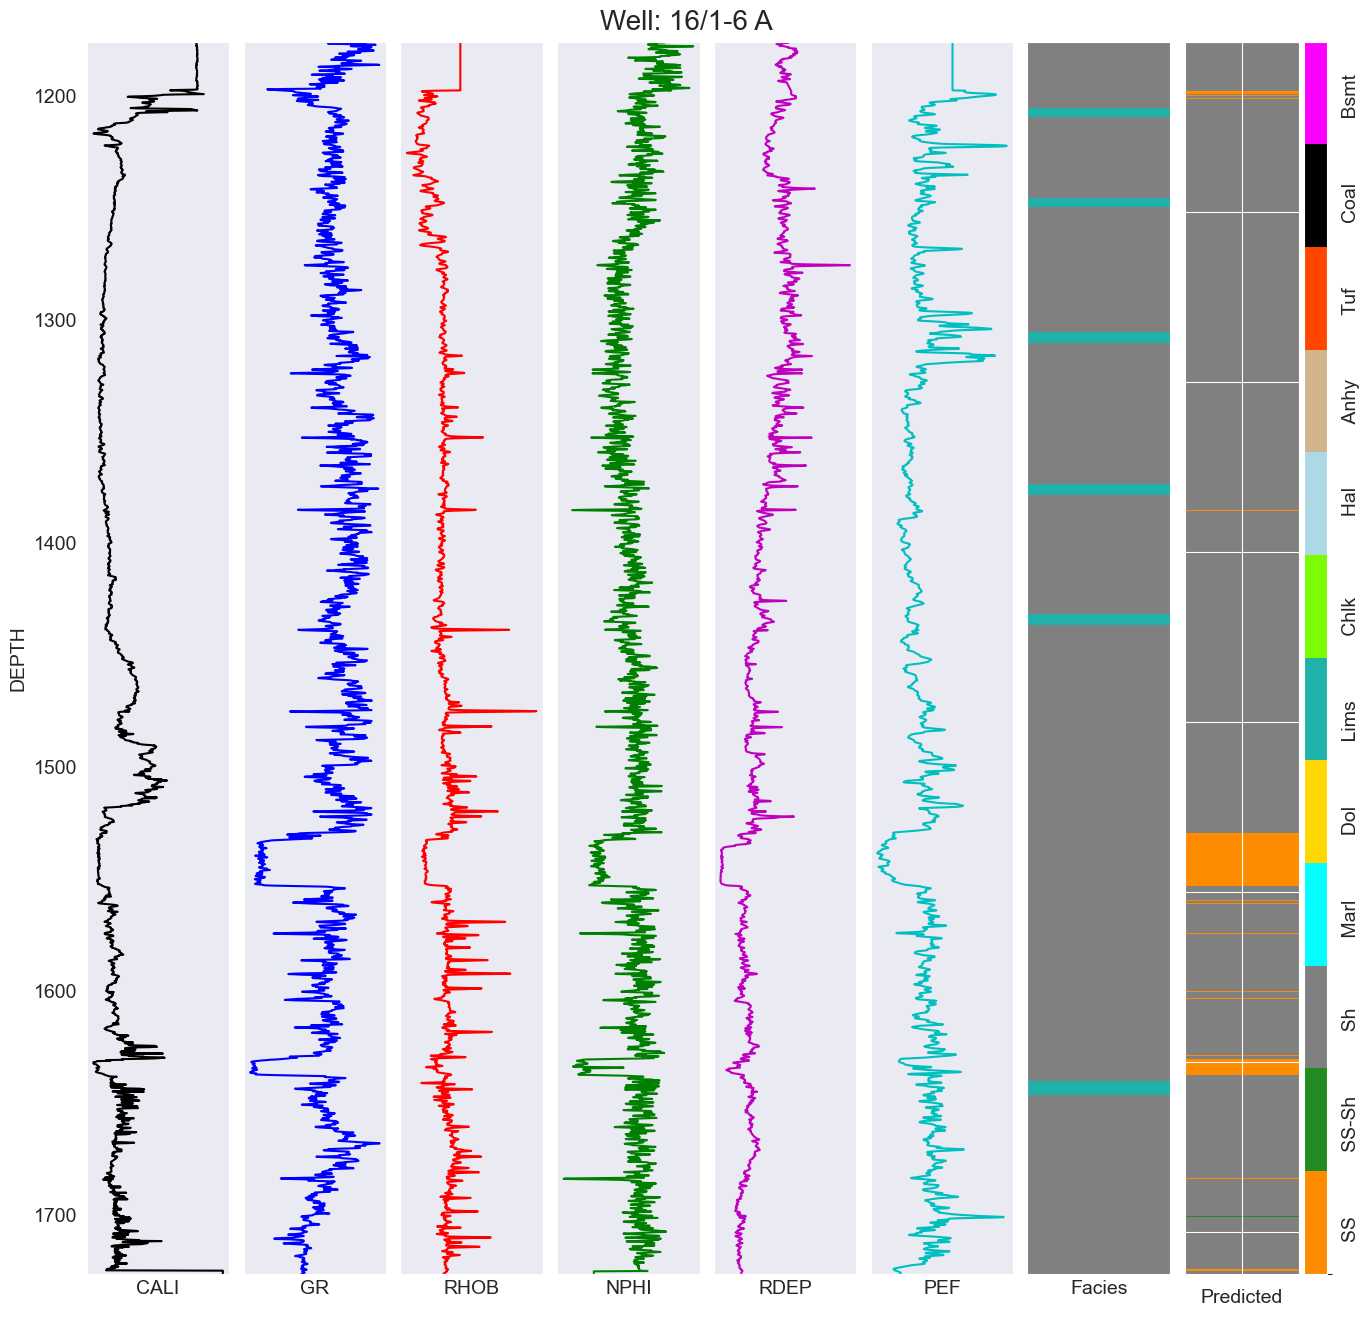

In [425]:
log_plot(results_df[results_df['WELL'] == validation_wells[well_no]], selected_logs, validation_wells[well_no], 'DT_predictions')

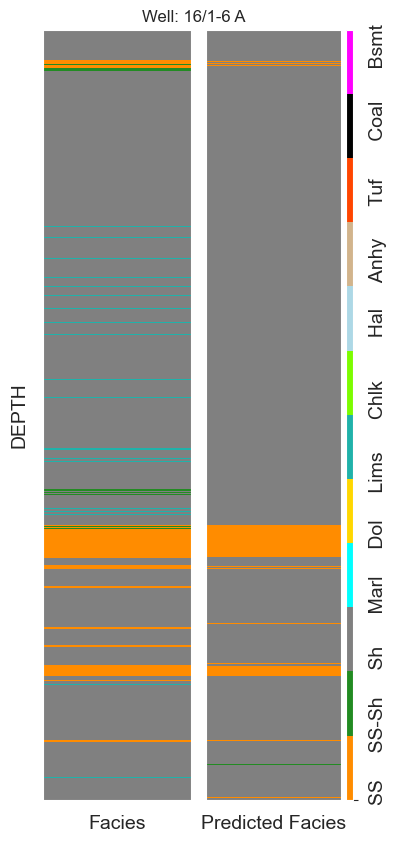

In [424]:
compare_facies(results_df[results_df['WELL'] == validation_wells[well_no]], validation_wells[well_no], 'DT_predictions')

### 4.3 Случайный лес

In [219]:
%%time

RF_model = RandomForestClassifier()

RF_params = {
    'n_estimators': [100, 200, 500, 700],  # количество деревьев в лесу
    'criterion': ['gini', 'entropy'],  # критерий разделения
    'max_depth': [None, 10, 20, 30, 40, 50],  # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # минимальное количество выборок для разделения узла
    'min_samples_leaf': [1, 2, 4],  # минимальное количество выборок в листовом узле
}

rs_randforest =  RandomizedSearchCV(estimator=RF_model, param_distributions=RF_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)

rs_randforest.fit(X_train, y_train)

Wall time: 9h 53s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 700]},
                   random_state=42, scoring='accuracy')

In [223]:
rs_randforest.best_params_

{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'entropy'}

In [89]:
model_randomforest = RandomForestClassifier()

In [225]:
model_randomforest.set_params(**rs_randforest.best_params_)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=700)

In [ ]:
model_randomforest.fit(X_train, y_train)

In [229]:
RF_train_preds = model_randomforest.predict(X_train)
RF_train_preds

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [230]:
accuracy_score(RF_train_preds, y_train)

0.8169222038742133

In [ ]:
val_preds_ranfor = model_randomforest.predict(X_val)

In [232]:
val_preds_ranfor

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [233]:
accuracy_score(val_preds_ranfor, y_val)

0.6716673766012488

In [135]:
model_randomforest.score(inputs_val, targets_val)

0.7179856267397677

In [140]:
print(classification_report(targets_val, val_preds_ranfor))

                 precision    recall  f1-score   support

      Anhydrite       0.00      0.00      0.00         0
          Chalk       0.70      0.16      0.26      2041
           Coal       1.00      0.17      0.29        89
       Dolomite       0.00      0.00      0.00        19
      Limestone       0.31      0.41      0.35      3540
           Marl       0.03      0.04      0.03      2079
      Sandstone       0.60      0.65      0.62     10105
Sandstone/Shale       0.44      0.31      0.36     11975
          Shale       0.83      0.86      0.85     64512
           Tuff       0.00      0.00      0.00       121

       accuracy                           0.72     94481
      macro avg       0.39      0.26      0.28     94481
   weighted avg       0.72      0.72      0.71     94481



### 4.5 X-GB Classifier

In [141]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

In [144]:
model_XGboost = XGBClassifier(random_state=42)

In [220]:
%%time

XGboost_params = {
    'n_estimators': [100, 200, 300, 350],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}

gs_XGboost = RandomizedSearchCV(estimator=model_XGboost, param_distributions=XGboost_params, cv=3, scoring='accuracy', n_jobs=-1)

gs_XGboost.fit(X_train, y_train_encoded)

KeyboardInterrupt: 

In [221]:
gs_XGboost.best_params_

{'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01}

In [83]:
gs_XGboost.best_estimator_.score(inputs_train, targets_train_encoded)

0.718678847244036

In [145]:
XGboost_best_params = {'n_estimators': 100,
                       'max_depth': 3,
                       'learning_rate': 0.01}

In [148]:
model_XGboost.set_params(**XGboost_best_params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [149]:
%%time
model_XGboost.fit(X_train, y_train_encoded)

Wall time: 38.9 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Оценка метрик на обучающих и валидационных выборках

In [158]:
XGboost_train_preds = model_XGboost.predict(X_train)

print("Accuracy на тестовой выборке:", accuracy_score(XGboost_train_preds, y_train_encoded))

Accuracy на тестовой выборке: 0.7087130403055741


In [160]:
y_val_encoded = label_encoder.fit_transform(y_val)

XGboost_val_preds = model_XGboost.predict(X_val)

print("Accuracy на валидационной выборке:", accuracy_score(XGboost_val_preds, y_val_encoded))

Accuracy на валидационной выборке: 0.7379984884186191


Отчет о классификации

In [161]:
print(classification_report(y_val_encoded, XGboost_val_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.981     0.873     0.924       299
           1      0.911     0.208     0.339      5129
           2      0.926     0.431     0.588        58
           3      0.000     0.000     0.000       188
           4      0.000     0.000     0.000      4314
           5      0.655     0.506     0.571      8839
           6      0.000     0.000     0.000      2702
           7      0.340     0.551     0.421     12675
           8      0.089     0.005     0.009      5737
           9      0.842     0.983     0.907     71343
          10      0.000     0.000     0.000      1181

    accuracy                          0.738    112465
   macro avg      0.431     0.323     0.342    112465
weighted avg      0.673     0.738     0.686    112465



Матрица ошибок

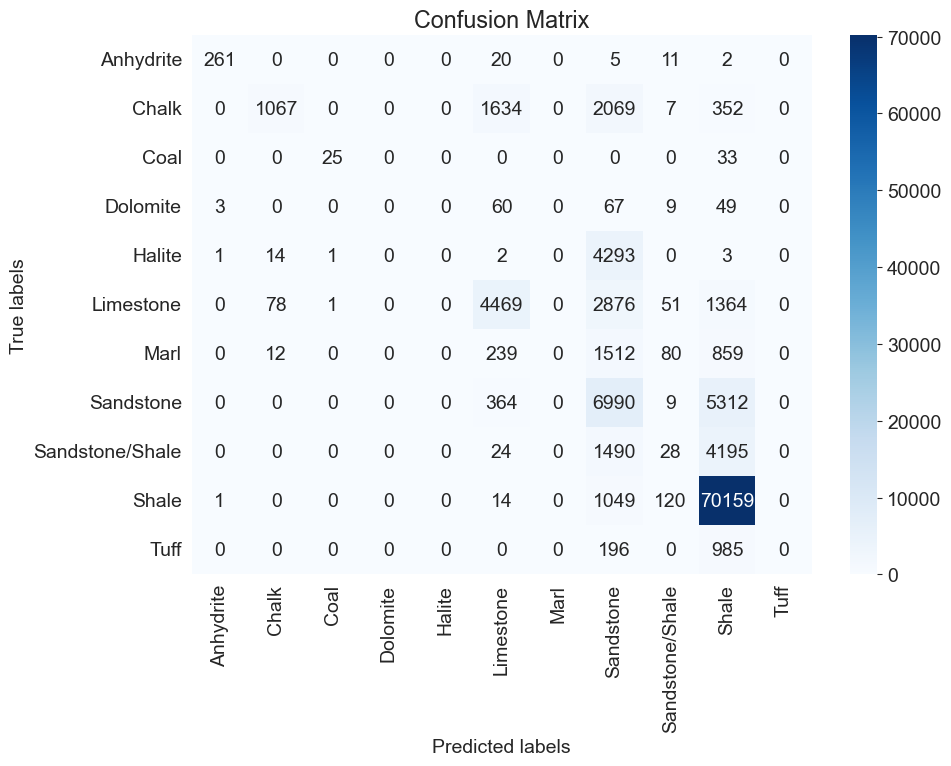

In [166]:
conf_matrix = confusion_matrix(y_val_encoded, XGboost_val_preds)

classes = ['Anhydrite', 'Chalk', 'Coal', 'Dolomite', 'Halite', 'Limestone',
       'Marl', 'Sandstone', 'Sandstone/Shale', 'Shale', 'Tuff']

conf_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Визуализация результатов классификации

In [183]:
clf_xgboost = xgb.XGBClassifier(
                                n_estimators = 108,
                                learning_rate = 0.058341077396837984,
                                max_depth = 10,
                                min_child_weight = 3.975751644687145,
                                gamma = 3.2978917680925592,
                                subsample = 0.660954379979485,
                                colsample_bytree = 0.35601189656690413
                                )

In [185]:
clf_xgboost.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.35601189656690413, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.2978917680925592,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.058341077396837984,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3.975751644687145, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=108,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [186]:
train_preds_clf_xgboost = clf_xgboost.predict(X_train)
train_preds_clf_xgboost

array([9, 9, 9, ..., 8, 8, 9], dtype=int64)

In [187]:
accuracy_score(train_preds_clf_xgboost, y_train_encoded)

0.8380161655615258

In [181]:
clf_xgboost.score(inputs_train, y_train)

0.8291776251591498

In [188]:
val_preds_clf_xgboost = clf_xgboost.predict(X_val)
val_preds_clf_xgboost

array([9, 9, 9, ..., 9, 9, 9], dtype=int64)

In [189]:
from sklearn.metrics import accuracy_score

# Преобразуем строковые метки классов в числовые метки для валидационного набора данных
numeric_targets_val = label_encoder.fit_transform(y_val)

# Вычисляем предсказания модели для валидационного набора данных
val_preds_clf_xgboost = clf_xgboost.predict(X_val)

# Вычисляем точность модели на валидационном наборе данных
accuracy_score(val_preds_clf_xgboost, numeric_targets_val)

0.6888824244439135

In [ ]:
accuracy_score(val_preds_clf_xgboost, targets_val)

In [ ]:
clf_xgboost.score(inputs_val, targets_val)

### 4.6 LGBM Classifier

In [167]:
param = {'num_leaves': 150, #120,
         'num_iterations': 500, #400,
         'max_depth': 15,
         'learning_rate': 0.05,
         'feature_fraction': 0.4, #0.5,
         'class_weight': None,
         'bagging_fraction': 0.9 #0.8
        }

In [184]:
seed_value = 42
np.random.seed(seed_value)


In [168]:
model_lgbm = lgbm.LGBMClassifier()

In [169]:
model_lgbm.set_params(**param)

LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.4, learning_rate=0.05,
               max_depth=15, num_iterations=500, num_leaves=150)

Обучение LGBM Classifier

In [170]:
model_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 1057943, number of used features: 11
[LightGBM] [Info] Start training from score -7.204880
[LightGBM] [Info] Start training from score -5.280650
[LightGBM] [Info] Start training from score -5.639131
[LightGBM] [Info] Start training from score -6.558617
[LightGBM] 

LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.4, learning_rate=0.05,
               max_depth=15, num_iterations=500, num_leaves=150)

Получение предсказаний

In [171]:
LGBM_train_preds = model_lgbm.predict(X_train)
LGBM_train_preds

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


array(['Shale', 'Shale', 'Shale', ..., 'Sandstone/Shale',
       'Sandstone/Shale', 'Sandstone/Shale'], dtype=object)

In [173]:
LGBM_val_preds = model_lgbm.predict(X_val)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


Точность на тренировочной и тестовой выборках

In [174]:
LGBM_train_accuracy = accuracy_score(LGBM_train_preds, y_train)
print(f"Accuracy на тренировочной выборке: {LGBM_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 0.912


In [175]:
LGBM_val_accuracy = accuracy_score(LGBM_val_preds, y_val)
print(f"Accuracy на валидационной выборке: {LGBM_val_accuracy:.3f}")

Accuracy на валидационной выборке: 0.721


Отчет о классификации

In [176]:
print(classification_report(y_val, LGBM_val_preds, digits = 3))

                 precision    recall  f1-score   support

      Anhydrite      0.386     0.823     0.525       299
          Chalk      0.139     0.010     0.018      5129
           Coal      0.044     0.466     0.080        58
       Dolomite      0.005     0.032     0.009       188
         Halite      0.859     0.052     0.099      4314
      Limestone      0.387     0.566     0.460      8839
           Marl      0.207     0.020     0.037      2702
      Sandstone      0.454     0.627     0.527     12675
Sandstone/Shale      0.146     0.031     0.051      5737
          Shale      0.875     0.941     0.907     71343
           Tuff      0.253     0.191     0.218      1181

       accuracy                          0.721    112465
      macro avg      0.341     0.342     0.266    112465
   weighted avg      0.692     0.721     0.683    112465



Матрица ошибок

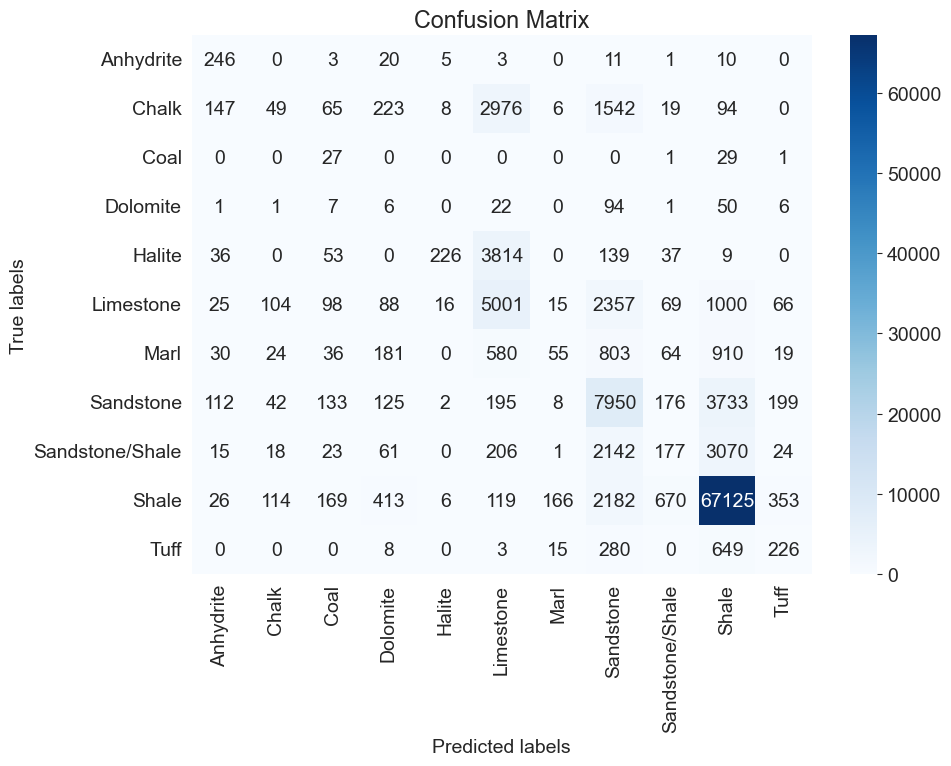

In [179]:
conf_matrix = confusion_matrix(y_val, LGBM_val_preds)

conf_df = pd.DataFrame(conf_matrix, index=model_lgbm.classes_, columns=model_lgbm.classes_)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 4.7 Catboost Classifier

In [184]:
catboost_model = CatBoostClassifier()

In [ ]:
%%time

CatBoost_params = {
    'iterations': [1200, 300, 400, 500],  # количество итераций
    'learning_rate': [0.01, 0.05, 0.1],  # скорость обучения
    'depth': [4, 6, 8],  # глубина деревьев
    'l2_leaf_reg': [1, 3, 5],  # коэффициент L2-регуляризации
    'border_count': [32, 64, 128],  # число бинов для числовых признаков
}


rs_catboost =  RandomizedSearchCV(estimator=catboost_classifier, param_distributions=CatBoost_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)

rs_catboost.fit(inputs_train, targets_train)

In [ ]:
rs_catboost.best_params_

In [185]:
catboost_best_params = {'learning_rate': 0.01,
          'l2_leaf_reg': 1,
          'iterations': 400,
          'depth': 4,
          'border_count': 64}

catboost_model.set_params(**catboost_best_params)

In [186]:
%%time
catboost_model.fit(X_train, y_train)

0:	learn: 2.3490733	total: 681ms	remaining: 4m 31s
1:	learn: 2.3039979	total: 1.2s	remaining: 3m 59s
2:	learn: 2.2621316	total: 1.71s	remaining: 3m 46s
3:	learn: 2.2230511	total: 2.21s	remaining: 3m 38s
4:	learn: 2.1864711	total: 2.71s	remaining: 3m 34s
5:	learn: 2.1520607	total: 3.2s	remaining: 3m 29s
6:	learn: 2.1196152	total: 3.77s	remaining: 3m 31s
7:	learn: 2.0888532	total: 4.25s	remaining: 3m 28s
8:	learn: 2.0594303	total: 4.7s	remaining: 3m 24s
9:	learn: 2.0315961	total: 5.17s	remaining: 3m 21s
10:	learn: 2.0050022	total: 5.65s	remaining: 3m 19s
11:	learn: 1.9796957	total: 6.08s	remaining: 3m 16s
12:	learn: 1.9554726	total: 6.55s	remaining: 3m 15s
13:	learn: 1.9322804	total: 7.01s	remaining: 3m 13s
14:	learn: 1.9099634	total: 7.45s	remaining: 3m 11s
15:	learn: 1.8884701	total: 7.95s	remaining: 3m 10s
16:	learn: 1.8676746	total: 8.45s	remaining: 3m 10s
17:	learn: 1.8476745	total: 8.94s	remaining: 3m 9s
18:	learn: 1.8280205	total: 9.43s	remaining: 3m 9s
19:	learn: 1.8094745	total:

158:	learn: 0.9983892	total: 1m 19s	remaining: 2m
159:	learn: 0.9965884	total: 1m 19s	remaining: 1m 59s
160:	learn: 0.9948104	total: 1m 20s	remaining: 1m 59s
161:	learn: 0.9930924	total: 1m 20s	remaining: 1m 58s
162:	learn: 0.9914116	total: 1m 21s	remaining: 1m 58s
163:	learn: 0.9897131	total: 1m 21s	remaining: 1m 57s
164:	learn: 0.9880263	total: 1m 21s	remaining: 1m 56s
165:	learn: 0.9864242	total: 1m 22s	remaining: 1m 56s
166:	learn: 0.9847302	total: 1m 22s	remaining: 1m 55s
167:	learn: 0.9829664	total: 1m 23s	remaining: 1m 55s
168:	learn: 0.9814049	total: 1m 23s	remaining: 1m 54s
169:	learn: 0.9797364	total: 1m 24s	remaining: 1m 54s
170:	learn: 0.9782545	total: 1m 24s	remaining: 1m 53s
171:	learn: 0.9766704	total: 1m 25s	remaining: 1m 52s
172:	learn: 0.9751637	total: 1m 25s	remaining: 1m 52s
173:	learn: 0.9735304	total: 1m 26s	remaining: 1m 51s
174:	learn: 0.9719903	total: 1m 26s	remaining: 1m 51s
175:	learn: 0.9705278	total: 1m 26s	remaining: 1m 50s
176:	learn: 0.9690454	total: 1m 

312:	learn: 0.8526316	total: 2m 30s	remaining: 41.8s
313:	learn: 0.8521529	total: 2m 30s	remaining: 41.3s
314:	learn: 0.8517014	total: 2m 31s	remaining: 40.8s
315:	learn: 0.8512455	total: 2m 31s	remaining: 40.3s
316:	learn: 0.8506496	total: 2m 32s	remaining: 39.9s
317:	learn: 0.8501418	total: 2m 32s	remaining: 39.4s
318:	learn: 0.8497046	total: 2m 33s	remaining: 38.9s
319:	learn: 0.8492179	total: 2m 33s	remaining: 38.4s
320:	learn: 0.8486920	total: 2m 34s	remaining: 37.9s
321:	learn: 0.8482072	total: 2m 34s	remaining: 37.4s
322:	learn: 0.8477615	total: 2m 34s	remaining: 36.9s
323:	learn: 0.8472093	total: 2m 35s	remaining: 36.5s
324:	learn: 0.8467957	total: 2m 35s	remaining: 36s
325:	learn: 0.8463682	total: 2m 36s	remaining: 35.5s
326:	learn: 0.8459740	total: 2m 36s	remaining: 35s
327:	learn: 0.8455438	total: 2m 37s	remaining: 34.5s
328:	learn: 0.8450961	total: 2m 37s	remaining: 34s
329:	learn: 0.8446597	total: 2m 38s	remaining: 33.5s
330:	learn: 0.8441703	total: 2m 38s	remaining: 33.1s

Получение предсказаний

In [188]:
CB_train_preds = catboost_classifier.predict(X_train)

In [189]:
CB_val_preds = catboost_classifier.predict(X_val)

Точность на тренировочной и тестовой выборках

In [190]:
CB_train_accuracy = accuracy_score(CB_train_preds, y_train)
print(f"Accuracy на тренировочной выборке: {CB_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 0.730


In [191]:
CB_val_accuracy = accuracy_score(CB_val_preds, y_val)
print(f"Accuracy на валидационной выборке: {CB_val_accuracy:.3f}")

Accuracy на валидационной выборке: 0.741


In [192]:
print(classification_report(y_val, CB_val_preds, digits = 3))

                 precision    recall  f1-score   support

      Anhydrite      0.000     0.000     0.000       299
          Chalk      0.000     0.000     0.000      5129
           Coal      0.806     0.500     0.617        58
       Dolomite      0.000     0.000     0.000       188
         Halite      0.000     0.000     0.000      4314
      Limestone      0.526     0.570     0.547      8839
           Marl      1.000     0.000     0.001      2702
      Sandstone      0.390     0.625     0.480     12675
Sandstone/Shale      0.312     0.014     0.026      5737
          Shale      0.855     0.985     0.915     71343
           Tuff      0.000     0.000     0.000      1181

       accuracy                          0.741    112465
      macro avg      0.354     0.245     0.235    112465
   weighted avg      0.668     0.741     0.679    112465



Матрица ошибок

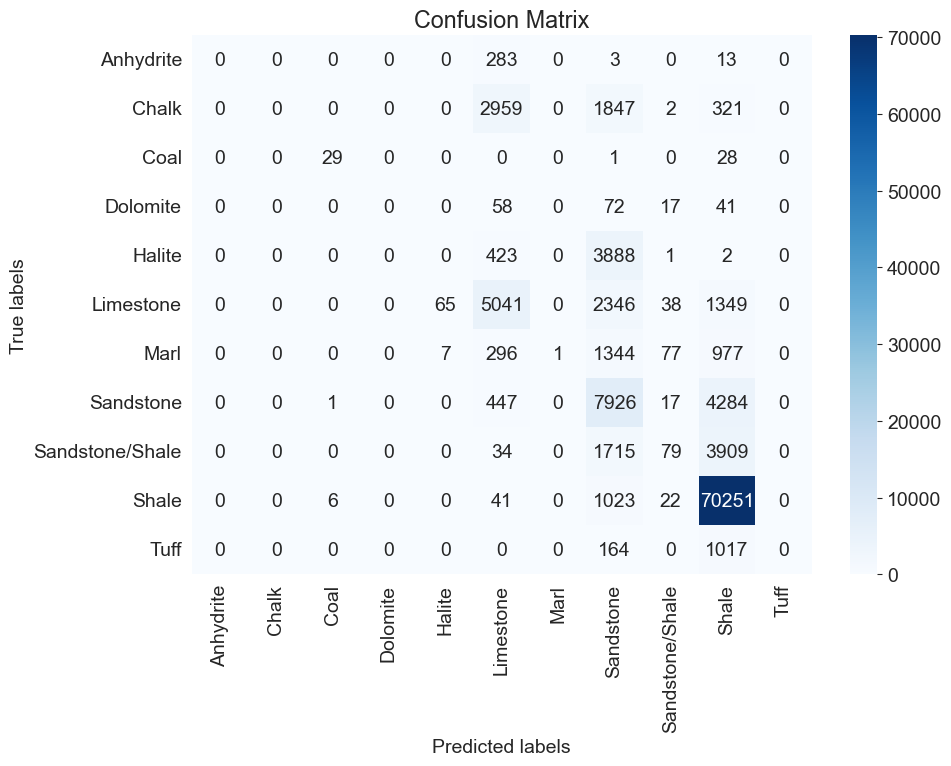

In [193]:
conf_matrix = confusion_matrix(y_val, CB_val_preds)

conf_df = pd.DataFrame(conf_matrix, index=catboost_classifier.classes_, columns=catboost_classifier.classes_)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 5. Сравнение метрик